In [1]:
import pandas as pd
import re

class Prof:

    def __init__(self):
        """
        Class initialization
        """

        self.prof_table = pd.read_csv("prof_table.tsv", sep="\t")

    def obfuscate_string(self, text, lang="any"):
        """
        Predicts the emotion for the sentences in input
        @param text: text to be obfuscated
        @param lang: text's language
        @return: obfuscated text
        """

        if lang != "any":
            assert lang in ['EN', 'FR', 'DE', 'IT', 'ES']
            prof_table_lang = self.prof_table[self.prof_table['language'] == lang]
        else:
            prof_table_lang = self.prof_table
        replacements = prof_table_lang[['profanity', 'obfuscation']].to_numpy()
        for k,v in replacements:
            text = re.sub(f'(?<![a-zA-Z]){k}(?![a-z-Z])', v, text)

        return text

    def reveal_profanity(self, profanity_obfuscated, lang="any"):
        """
        Predicts the emotion for the sentences in input
        @param profanity: profanity to be revealed
        @param lang: text's language
        @return: revealed profanity
        """

        if lang != "any":
            assert lang in ['EN', 'FR', 'DE', 'IT', 'ES']
            prof_table_lang = self.prof_table[self.prof_table['language'] == lang]
        else:
            prof_table_lang = self.prof_table

        profanity = prof_table_lang[prof_table_lang['obfuscation'] == profanity_obfuscated]['profanity']

        profanity = profanity.unique()[0]

        return profanity

In [2]:
prof = Prof()
obfuscator = prof

print(obfuscator.obfuscate_string("puta mierda"))

print(obfuscator.obfuscate_string("mother fucker"))

print(obfuscator.obfuscate_string("motherfucker"))

print(obfuscator.obfuscate_string("he is porca puttana","IT"))

print(obfuscator.obfuscate_string("porn"))


p*ta m*erda
mother fucker
motherfucker
he is p*rca p*ttana
porn


In [3]:
p = pd.read_csv("prof_table.tsv", sep="\t")
p.head()
#	id	comment_text	lang	toxic

,profanity,obfuscation,pos,definition,language
0,ass,a*s,NOUN,https://babelnet.org/synset?id=bn:00005914n&la...,EN
1,ass,a*s,ADV,https://babelnet.org/synset?id=bn:27111230r&la...,EN
2,assfucked,assf*cked,NOUN,https://babelnet.org/synset?id=bn%3A00003771n&...,EN
3,asshole,a*shole,NOUN,https://babelnet.org/synset?id=bn:00006506n&la...,EN
4,bitch,b*tch,NOUN,https://babelnet.org/synset?id=bn:00010740n&la...,EN


In [4]:
p['toxic'] = 1
p['profanity'] = p['profanity'].rename('comment_text')
p = p.rename(columns={'profanity': 'comment_text', "language": "lang"})
p = p.drop(columns = ['obfuscation','pos','definition'])
p = p.reset_index()
p = p.rename(columns={'index': 'id'})

In [5]:
p['lang'] = p['lang'].str.lower()

In [6]:
p['lang'].value_counts()

en    53
es    48
it    47
fr    44
de    19
Name: lang, dtype: int64

In [7]:
#pip install transformers

In [8]:
#pip install imblearn

In [9]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
#from kaggle_datasets import KaggleDatasets
import transformers
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer

In [10]:
valid = pd.read_csv('validation.csv')
test = pd.read_csv('test.csv')
train= pd.read_csv('jigsaw-toxic-comment-train.csv')

In [11]:
train_es = pd.read_csv('jigsaw-toxic-comment-train-google-es-cleaned.csv')
train_fr = pd.read_csv('jigsaw-toxic-comment-train-google-fr-cleaned.csv')
train_it = pd.read_csv('jigsaw-toxic-comment-train-google-it-cleaned.csv')
train_tr = pd.read_csv('jigsaw-toxic-comment-train-google-tr-cleaned.csv')

In [12]:
train_es = train_es.drop(columns = [ 'Unnamed: 0', 'Unnamed: 0.1'])

In [13]:
train_fr

,Unnamed: 0,Unnamed: 0.1,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,000113f07ec002fd,"Hé mec, je n'essaye vraiment pas de modifier l...",0,0,0,0,0,0
1,1,1,00025465d4725e87,"""\n\nFélicitations de ma part également, utili...",0,0,0,0,0,0
2,2,2,0009801bd85e5806,Le point Mitsurugi n'avait aucun sens - pourqu...,0,0,0,0,0,0
3,3,3,0001b41b1c6bb37e,"""\nPlus\nJe ne peux pas faire de véritables su...",0,0,0,0,0,0
4,4,4,00040093b2687caa,alignement sur ce sujet et qui sont contraires...,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
223389,223544,223544,fff8f521a7dbcd47,fermez la frontière mexicaine sans mal paraître.,0,0,0,0,0,0
223390,223545,223545,fffa8a11c4378854,== honte à vous tous !!! ==\n\n Vous voulez pa...,0,0,0,0,0,0
223391,223546,223546,fff7159b3ee95618,"== Votre nom mentionné ==\n Salut, je pensais ...",0,0,0,0,0,0
223392,223547,223547,fffb5451268fb5ba,"""\n\n == Découverte de l'antre de la licorne =...",0,0,1,0,1,0


In [ ]:
# When the model was trained with first dataset, after checking behavioural metrics, the model failed invariance test.
# It didn't learn interpreting nouns such as locations and human names. 
# So, using data perturbations, inputs containing human names and locations have been created and added to dataset followed by training again.

In [14]:
import re

def extract_words(input_string):
    # Use regular expression to remove numbers and extract words
    words_only = re.findall(r'\b[A-Za-z]+\b', input_string)

    # Join the extracted words into a single string
    result_string = ' '.join(words_only)

    return result_string

# Example usage
#input_string = "'Shawn'.255"
result = extract_words("'Shawn'.255")

# Print the result
print(result)


Shawn


In [15]:
t =pd.read_csv('w1.tsv')

In [16]:
t = pd.DataFrame(t.T).reset_index()

In [17]:
r =pd.read_csv('w2.tsv')

In [18]:
r = pd.DataFrame(r.T).reset_index()


In [19]:
t = pd.DataFrame(t)

In [20]:
t['index'].iloc[0]

"'John Smith.'"

In [21]:
for i in range(len(t)):
    t['index'].iloc[i] = extract_words( t['index'].iloc[i])

In [22]:
t

,index
0,John Smith
1,Michael King
2,Christopher Collins
3,Matthew Watson
4,David Turner
...,...
11259,Amanda
11260,Sydney
11261,Erica
11262,Madison


In [23]:
r = pd.DataFrame(r)

In [24]:
for i in range(len(r)):
    r['index'].iloc[i] = extract_words( r['index'].iloc[i])

In [25]:
t = t.rename(columns = {'index': 'comment_text'})

In [26]:
nl = pd.DataFrame(list(t['comment_text'].iloc[:]) + list(r['index'].iloc[:]))
n1 = nl.rename(columns = {0: 'comment_text'})

In [27]:
n1 = n1.reset_index()

In [28]:
n1

,index,comment_text
0,0,John Smith
1,1,Michael King
2,2,Christopher Collins
3,3,Matthew Watson
4,4,David Turner
...,...,...
18299,18299,Poland
18300,18300,Bangladesh
18301,18301,Vietnam
18302,18302,Madagascar


In [29]:
n1['toxic'] = 0
n1['severe_toxic'] = 0
n1['obscene'] = 0
n1['threat'] = 0
n1['insult'] = 0
n1['identity_hate'] = 0
n1

,index,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,John Smith,0,0,0,0,0,0
1,1,Michael King,0,0,0,0,0,0
2,2,Christopher Collins,0,0,0,0,0,0
3,3,Matthew Watson,0,0,0,0,0,0
4,4,David Turner,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
18299,18299,Poland,0,0,0,0,0,0
18300,18300,Bangladesh,0,0,0,0,0,0
18301,18301,Vietnam,0,0,0,0,0,0
18302,18302,Madagascar,0,0,0,0,0,0


In [30]:
n2 = n1[:500]

In [31]:
n2 = n2.append(n1[9000:9500])

In [32]:
n2 = n2.rename(columns = {'index': 'id'})

In [33]:
n1 = n1.rename(columns = {'index': 'id'})

In [34]:
n2

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,John Smith,0,0,0,0,0,0
1,1,Michael King,0,0,0,0,0,0
2,2,Christopher Collins,0,0,0,0,0,0
3,3,Matthew Watson,0,0,0,0,0,0
4,4,David Turner,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
9495,9495,Samantha,0,0,0,0,0,0
9496,9496,Julia,0,0,0,0,0,0
9497,9497,Erica,0,0,0,0,0,0
9498,9498,Christine,0,0,0,0,0,0


In [35]:
train_es.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,000113f07ec002fd,"Hola hombre, realmente no estoy tratando de ed...",0,0,0,0,0,0
1,000b08c464718505,"""\n\n Con respecto a tus ediciones recientes\n...",0,0,0,0,0,0
2,001325b8b20ea8aa,Alabanza\n\nLeí este artículo hace unos 6 mese...,0,0,0,0,0,0
3,001c557175094f10,"En otras palabras, eres demasiado vago como pa...",0,0,0,0,0,0
4,00031b1e95af7921,Su vandalismo al artículo de Matt Shirvington ...,0,0,0,0,0,0


In [36]:
train_fr.head()

,Unnamed: 0,Unnamed: 0.1,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,000113f07ec002fd,"Hé mec, je n'essaye vraiment pas de modifier l...",0,0,0,0,0,0
1,1,1,00025465d4725e87,"""\n\nFélicitations de ma part également, utili...",0,0,0,0,0,0
2,2,2,0009801bd85e5806,Le point Mitsurugi n'avait aucun sens - pourqu...,0,0,0,0,0,0
3,3,3,0001b41b1c6bb37e,"""\nPlus\nJe ne peux pas faire de véritables su...",0,0,0,0,0,0
4,4,4,00040093b2687caa,alignement sur ce sujet et qui sont contraires...,0,0,0,0,0,0


In [37]:
train_new = train[0:180000]
train_new = train_new.append(train_fr[0:180000])
train_new = train_new.append(train_it[0:180000])
train_new = train_new.append(train_es[0:180000])
train_new = train_new.append(train_tr[0:180000])
train_new

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,Unnamed: 0,Unnamed: 0.1
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,NaN,NaN
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,NaN,NaN
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,NaN,NaN
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,NaN,NaN
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
179995,51a25a5be831f2be,": Adil nokta, B'yi Λ olarak değiştireceğim (bu...",0,0,1,0,1,0,180107.0,180107.0
179996,51937100747bf8d1,== Senden hoşlanmıyorum ... ==\n\n Seni hiç se...,1,0,0,0,0,0,180108.0,180108.0
179997,51a5b43ddc29f92f,"""\n\n == Geri dönüşler ve diğer editörlere kar...",0,0,0,0,0,0,180109.0,180109.0
179998,51ac72b7a51585b3,":: Görmek istediğim, twitter'ı, takip ettiği k...",0,0,0,0,0,0,180110.0,180110.0


In [38]:
train_labels = np.where(train_new['obscene'] | train_new['severe_toxic'] == 1,1,0)
pd.DataFrame(train_labels).value_counts()

0    851564
1     48436
dtype: int64

In [39]:
trainl1 = pd.DataFrame(train_labels)
trainl_index_list1 = trainl1[trainl1[0] == 0].index
l1 = list(trainl_index_list1)
train_new_resampled1 = train_new.iloc[l1]
train_new_resampled1[0:48436].head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,Unnamed: 0,Unnamed: 0.1
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,NaN,NaN
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,NaN,NaN
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,NaN,NaN
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,NaN,NaN
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,NaN,NaN


In [40]:
trainl2 = pd.DataFrame(train_labels)
trainl_index_list2 = trainl2[trainl2[0] == 1].index
l2 = list(trainl_index_list2)
train_new_resampled2 = train_new.iloc[l2]
train_new_resampled2.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,Unnamed: 0,Unnamed: 0.1
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,NaN,NaN
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1,NaN,NaN
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0,NaN,NaN
51,001dc38a83d420cf,GET FUCKED UP. GET FUCKEEED UP. GOT A DRINK T...,1,0,1,0,0,0,NaN,NaN
55,0020e7119b96eeeb,Stupid peace of shit stop deleting my stuff as...,1,1,1,0,1,0,NaN,NaN


In [41]:
train_resampled = train_new_resampled1[0:48436].append(train_new_resampled2)
train_resampled

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,Unnamed: 0,Unnamed: 0.1
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,NaN,NaN
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,NaN,NaN
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,NaN,NaN
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,NaN,NaN
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
179894,51440bad024144d3,"""\n\n : Vikipedi olarak: Hızlı silme kriterler...",0,0,1,1,1,0,180006.0,180006.0
179932,51624313f87d04ff,Bu saçmalığı hafifletmek için bir önerim var. ...,0,0,1,0,0,0,180044.0,180044.0
179965,518c28e39587deba,"""\n\n == Adil Kullanım ==\n\n (Kimden)\n\n Jim...",0,0,1,0,0,0,180077.0,180077.0
179975,5191417852058f99,== Gösterinin Saldırısı == Bildiğiniz LIP'leri...,0,0,1,0,0,0,180087.0,180087.0


In [42]:
n2

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,John Smith,0,0,0,0,0,0
1,1,Michael King,0,0,0,0,0,0
2,2,Christopher Collins,0,0,0,0,0,0
3,3,Matthew Watson,0,0,0,0,0,0
4,4,David Turner,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
9495,9495,Samantha,0,0,0,0,0,0
9496,9496,Julia,0,0,0,0,0,0
9497,9497,Erica,0,0,0,0,0,0
9498,9498,Christine,0,0,0,0,0,0


In [43]:
train_resampled3 = train_resampled.append(n2)
train_resampled3

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,Unnamed: 0,Unnamed: 0.1
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,NaN,NaN
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,NaN,NaN
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,NaN,NaN
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,NaN,NaN
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
9495,9495,Samantha,0,0,0,0,0,0,NaN,NaN
9496,9496,Julia,0,0,0,0,0,0,NaN,NaN
9497,9497,Erica,0,0,0,0,0,0,NaN,NaN
9498,9498,Christine,0,0,0,0,0,0,NaN,NaN


In [44]:
train_resampled = train_resampled3

In [45]:
trainl1 = pd.DataFrame(train_labels)
trainl_index_list1 = trainl1[trainl1[0] == 0].index
l1 = list(trainl_index_list1)
train_new_labels_resampled1 = trainl1.iloc[l1]
train_new_labels_resampled1[0:48436]

,0
0,0
1,0
2,0
3,0
4,0
...,...
51148,0
51149,0
51150,0
51151,0


In [46]:
trainl1 = pd.DataFrame(train_labels)
trainl_index_list1 = trainl1[trainl1[0] == 1].index
l1 = list(trainl_index_list1)
train_new_labels_resampled2 = trainl1.iloc[l1]
train_new_labels_resampled2

,0
6,1
42,1
43,1
51,1
55,1
...,...
899894,1
899932,1
899965,1
899975,1


In [47]:
len(n1)

18304

In [48]:
train_labels_resampled = train_new_labels_resampled1[0:48436].append(train_new_labels_resampled2)
train_labels_resampled

,0
0,0
1,0
2,0
3,0
4,0
...,...
899894,1
899932,1
899965,1
899975,1


In [49]:
list_wl = [0]*1000

In [50]:
train_labels_resampled3 = train_labels_resampled.append(pd.DataFrame(list_wl))

In [51]:
len(train_labels_resampled3)

97872

In [52]:
train_labels_resampled = train_labels_resampled3

In [53]:
valid_new = train[180001:200000]
valid_new = valid_new.append(train_fr[180001:200000])
valid_new = valid_new.append(train_it[180001:200000])
valid_new = valid_new.append(train_es[180001:200000])
valid_new = valid_new.append(train_tr[180001:200000])
valid_new

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,Unnamed: 0,Unnamed: 0.1
180001,5143c3da6bbbb52c,::Fab. Thanks.,0,0,0,0,0,0,NaN,NaN
180002,5143e99fd752abb2,what the hell i havent vandalisesd any thing y...,0,0,0,0,0,0,NaN,NaN
180003,51440bad024144d3,""" \n\n :As Wikipedia:Criteria for speedy delet...",0,0,0,0,0,0,NaN,NaN
180004,51475906c42a7f35,"== Demarest Hall == \n\n Hey, I have copyright...",0,0,0,0,0,0,NaN,NaN
180005,5147935de26c3372,REDIRECTTalk:Epsom Mad Funkers: The Best of EMF,0,0,0,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
199995,a1b194c7ed1f5a78,== ח ט י ך כ ם מ ן נ ס ע ף פ צ ק ר ש ת ׳ ״ װ ױ...,0,0,0,0,0,0,200124.0,200124.0
199996,a1b1d8938d23b057,"""Ayrıca birçok şarkıcı en belirsiz şarkıları b...",0,0,0,0,0,0,200125.0,200125.0
199997,a1abc37cfbd968c3,"""\n == Editörlere Not ==\n Özellikle wikipedia...",0,0,0,0,0,0,200127.0,200127.0
199998,a1b3112c0f50abab,ne kadar berbat olduğu için yakında iptal edil...,1,0,0,0,0,0,200128.0,200128.0


In [54]:
valid_labels = np.where(valid_new['obscene'] | valid_new['severe_toxic'] == 1,1,0)
pd.DataFrame(valid_labels).value_counts()

0    94100
1     5895
dtype: int64

In [55]:
validl1 = pd.DataFrame(valid_labels)
validl_index_list1 = validl1[validl1[0] == 0].index
l1 = list(validl_index_list1)
valid_new_resampled1 = valid_new.iloc[l1]
valid_new_resampled1

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,Unnamed: 0,Unnamed: 0.1
180001,5143c3da6bbbb52c,::Fab. Thanks.,0,0,0,0,0,0,NaN,NaN
180002,5143e99fd752abb2,what the hell i havent vandalisesd any thing y...,0,0,0,0,0,0,NaN,NaN
180003,51440bad024144d3,""" \n\n :As Wikipedia:Criteria for speedy delet...",0,0,0,0,0,0,NaN,NaN
180004,51475906c42a7f35,"== Demarest Hall == \n\n Hey, I have copyright...",0,0,0,0,0,0,NaN,NaN
180005,5147935de26c3372,REDIRECTTalk:Epsom Mad Funkers: The Best of EMF,0,0,0,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
199995,a1b194c7ed1f5a78,== ח ט י ך כ ם מ ן נ ס ע ף פ צ ק ר ש ת ׳ ״ װ ױ...,0,0,0,0,0,0,200124.0,200124.0
199996,a1b1d8938d23b057,"""Ayrıca birçok şarkıcı en belirsiz şarkıları b...",0,0,0,0,0,0,200125.0,200125.0
199997,a1abc37cfbd968c3,"""\n == Editörlere Not ==\n Özellikle wikipedia...",0,0,0,0,0,0,200127.0,200127.0
199998,a1b3112c0f50abab,ne kadar berbat olduğu için yakında iptal edil...,1,0,0,0,0,0,200128.0,200128.0


In [56]:
validl1 = pd.DataFrame(valid_labels)
validl_index_list1 = validl1[validl1[0] == 1].index
l1 = list(validl_index_list1)
valid_new_resampled2 = valid_new.iloc[l1]
valid_new_resampled2

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,Unnamed: 0,Unnamed: 0.1
180006,514893b564055692,== Babyfuck == \n\n It has been reported that ...,1,0,1,1,1,0,NaN,NaN
180044,516248b47256b3c8,""":Speech is never free and free speech is an i...",1,0,1,0,0,0,NaN,NaN
180077,518a4efd17f8a522,F.U.C.K YOU! DONT BLANK PAGES!,1,0,1,0,0,0,NaN,NaN
180087,51928314e1b91801,"==Dear Smalljim== \n Sob sob. Please help me, ...",1,0,1,0,0,0,NaN,NaN
180107,51a52e1b9b3e939a,Your post count has nothing to do with how coo...,1,0,1,0,1,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
199923,a1675202dbaf46c2,"""2014 (UTC)\n : Grubun sözde tasfiyesine ilişk...",0,0,1,0,0,0,200052.0,200052.0
199934,a174f8c120d33678,":: Hayır, şimdi dürüst ol. Bir makaleyi silinm...",0,0,1,0,1,1,200063.0,200063.0
199945,a179020fcec93c1a,"""\n\n == Seks? ==\n\n Makale şöyle diyor: """" S...",0,0,1,0,0,0,200074.0,200074.0
199973,a18fe3306cd15eb2,"""\n\n == Kaynak ihtiyacı ==\n Makale şöyle diy...",0,0,1,0,1,0,200102.0,200102.0


In [57]:
valid_resampled = valid_new_resampled1[0:5895].append(valid_new_resampled2)
valid_resampled

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,Unnamed: 0,Unnamed: 0.1
180001,5143c3da6bbbb52c,::Fab. Thanks.,0,0,0,0,0,0,NaN,NaN
180002,5143e99fd752abb2,what the hell i havent vandalisesd any thing y...,0,0,0,0,0,0,NaN,NaN
180003,51440bad024144d3,""" \n\n :As Wikipedia:Criteria for speedy delet...",0,0,0,0,0,0,NaN,NaN
180004,51475906c42a7f35,"== Demarest Hall == \n\n Hey, I have copyright...",0,0,0,0,0,0,NaN,NaN
180005,5147935de26c3372,REDIRECTTalk:Epsom Mad Funkers: The Best of EMF,0,0,0,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
199923,a1675202dbaf46c2,"""2014 (UTC)\n : Grubun sözde tasfiyesine ilişk...",0,0,1,0,0,0,200052.0,200052.0
199934,a174f8c120d33678,":: Hayır, şimdi dürüst ol. Bir makaleyi silinm...",0,0,1,0,1,1,200063.0,200063.0
199945,a179020fcec93c1a,"""\n\n == Seks? ==\n\n Makale şöyle diyor: """" S...",0,0,1,0,0,0,200074.0,200074.0
199973,a18fe3306cd15eb2,"""\n\n == Kaynak ihtiyacı ==\n Makale şöyle diy...",0,0,1,0,1,0,200102.0,200102.0


In [58]:
validl1 = pd.DataFrame(valid_labels)
validl_index_list1 = validl1[validl1[0] == 0].index
l1 = list(validl_index_list1)
valid_new_labels_resampled1 = validl1.iloc[l1]
valid_new_labels_resampled1

,0
0,0
1,0
2,0
3,0
4,0
...,...
99990,0
99991,0
99992,0
99993,0


In [59]:
validl1 = pd.DataFrame(valid_labels)
validl_index_list1 = validl1[validl1[0] == 1].index
l1 = list(validl_index_list1)
valid_new_labels_resampled2 = validl1.iloc[l1]
valid_new_labels_resampled2

,0
5,1
43,1
76,1
86,1
106,1
...,...
99918,1
99929,1
99940,1
99968,1


In [60]:
valid_labels_resampled = valid_new_labels_resampled1[0:5895].append(valid_new_labels_resampled2)
valid_labels_resampled

,0
0,0
1,0
2,0
3,0
4,0
...,...
99918,1
99929,1
99940,1
99968,1


In [294]:
test_fr = train_fr[200001:223393]
test_it = train_it[200001:223393]
test_es = train_es[200001:223393]
test_tr = train_tr[200001:223393]

In [61]:
test_new = train[200001:223393]
test_new = test_new.append(train_fr[200001:223393])
test_new = test_new.append(train_it[200001:223393])
test_new = test_new.append(train_es[200001:223393])
test_new = test_new.append(train_tr[200001:223393])
test_new

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,Unnamed: 0,Unnamed: 0.1
200001,a13b903c1d43dc21,"""Welcome to Wikipedia, Mhowman!Thank you for y...",0,0,0,0,0,0,NaN,NaN
200002,a13c5c0b07b7deec,==Youngest== \n L Ron ... \n\n others ... \n\n...,0,0,0,0,0,0,NaN,NaN
200003,a13d4d4ee2f6ea5f,""" \n ::::ChrisO, I don't think your use of the...",0,0,0,0,0,0,NaN,NaN
200004,a13da05c92ca7a25,The Kknb is a cheap KKK ripoff and is mad eup ...,0,0,0,0,0,0,NaN,NaN
200005,a13dfcd7d26b5720,you're a shitty little fucktard aren't you?,1,0,1,0,1,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
223388,fff5c4a77fe0c05f,"""== Maungaturoto'ya yaptığınız düzenleme ==\n ...",0,0,0,0,0,0,223543.0,223543.0
223389,fffac2a094c8e0e2,"MEL GIBSON, SHITTY FİLMLERİ YAPAN NAZI HATTI. ...",1,0,0,0,0,0,223544.0,223544.0
223390,fffb5451268fb5ba,"""\n\n == Unicorn inine keşif ==\n\n Sözde, Kuz...",0,0,0,0,0,0,223545.0,223545.0
223391,fffa8a11c4378854,== hepinize utanç !!! ==\n\n Geylerden bahsetm...,0,0,0,0,0,0,223546.0,223546.0


In [62]:
test_labels = np.where(test_new['obscene'] | test_new['severe_toxic'] == 1,1,0)
pd.DataFrame(test_labels).value_counts()

0    110214
1      6731
dtype: int64

In [296]:
test_noneng_labels = np.where(test_fr['obscene'] | test_fr['severe_toxic'] == 1,1,0)
pd.DataFrame(test_noneng_labels).value_counts()

0    22046
1     1346
dtype: int64

In [63]:
testl1 = pd.DataFrame(test_labels)
testl_index_list1 = testl1[testl1[0] == 0].index
l1 = list(testl_index_list1)
test_new_resampled1 = test_new.iloc[l1]
test_new_resampled1

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,Unnamed: 0,Unnamed: 0.1
200001,a13b903c1d43dc21,"""Welcome to Wikipedia, Mhowman!Thank you for y...",0,0,0,0,0,0,NaN,NaN
200002,a13c5c0b07b7deec,==Youngest== \n L Ron ... \n\n others ... \n\n...,0,0,0,0,0,0,NaN,NaN
200003,a13d4d4ee2f6ea5f,""" \n ::::ChrisO, I don't think your use of the...",0,0,0,0,0,0,NaN,NaN
200004,a13da05c92ca7a25,The Kknb is a cheap KKK ripoff and is mad eup ...,0,0,0,0,0,0,NaN,NaN
200006,a13e1c449177c90e,). But you cant jump off a window- you have t...,0,0,0,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
223387,fff9d70fe0722906,== Şanslı piç ==\n http://wikimediafoundation....,0,0,0,0,0,0,223542.0,223542.0
223388,fff5c4a77fe0c05f,"""== Maungaturoto'ya yaptığınız düzenleme ==\n ...",0,0,0,0,0,0,223543.0,223543.0
223389,fffac2a094c8e0e2,"MEL GIBSON, SHITTY FİLMLERİ YAPAN NAZI HATTI. ...",1,0,0,0,0,0,223544.0,223544.0
223390,fffb5451268fb5ba,"""\n\n == Unicorn inine keşif ==\n\n Sözde, Kuz...",0,0,0,0,0,0,223545.0,223545.0


In [64]:
testl1 = pd.DataFrame(test_labels)
testl_index_list1 = testl1[testl1[0] == 1].index
l1 = list(testl_index_list1)
test_new_resampled2 = test_new.iloc[l1]
test_new_resampled2

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,Unnamed: 0,Unnamed: 0.1
200005,a13dfcd7d26b5720,you're a shitty little fucktard aren't you?,1,0,1,0,1,0,NaN,NaN
200024,a15304514263877d,. Go fuck yourself cunt. I'm gonna but rape yo...,1,0,1,1,1,1,NaN,NaN
200026,a15415574f020a4e,== You are a complete fucking arsehole == \n\n...,1,0,1,0,1,0,NaN,NaN
200035,a159deff528192c6,==Fuck You Mark Zuckerburg==,1,0,1,0,1,0,NaN,NaN
200036,a159ef740c42cc95,"Everybody hates the economy, why bitch why. I'...",1,0,1,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
223232,ff52ae871842fecf,:: Namecheck ve dosyadaki çalışmalarınız için ...,0,0,1,0,1,0,223386.0,223386.0
223244,ff5aa087a13351ab,"Bunu, Vikipedi'yi hukuk mahkemelerine getirebi...",0,0,1,0,0,0,223398.0,223398.0
223282,ff89183fed44ee6d,== Hırsızlık / Sahtecilik ==\n\n Burada 500 bi...,0,0,1,0,1,0,223436.0,223436.0
223378,ffe6cd34eb78031a,":: Ayrıca, paragrafın kanıt eksikliğini ve teo...",0,0,1,0,0,0,223533.0,223533.0


In [65]:
test_resampled = test_new_resampled1[0:6731].append(test_new_resampled2)
test_resampled

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,Unnamed: 0,Unnamed: 0.1
200001,a13b903c1d43dc21,"""Welcome to Wikipedia, Mhowman!Thank you for y...",0,0,0,0,0,0,NaN,NaN
200002,a13c5c0b07b7deec,==Youngest== \n L Ron ... \n\n others ... \n\n...,0,0,0,0,0,0,NaN,NaN
200003,a13d4d4ee2f6ea5f,""" \n ::::ChrisO, I don't think your use of the...",0,0,0,0,0,0,NaN,NaN
200004,a13da05c92ca7a25,The Kknb is a cheap KKK ripoff and is mad eup ...,0,0,0,0,0,0,NaN,NaN
200006,a13e1c449177c90e,). But you cant jump off a window- you have t...,0,0,0,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
223232,ff52ae871842fecf,:: Namecheck ve dosyadaki çalışmalarınız için ...,0,0,1,0,1,0,223386.0,223386.0
223244,ff5aa087a13351ab,"Bunu, Vikipedi'yi hukuk mahkemelerine getirebi...",0,0,1,0,0,0,223398.0,223398.0
223282,ff89183fed44ee6d,== Hırsızlık / Sahtecilik ==\n\n Burada 500 bi...,0,0,1,0,1,0,223436.0,223436.0
223378,ffe6cd34eb78031a,":: Ayrıca, paragrafın kanıt eksikliğini ve teo...",0,0,1,0,0,0,223533.0,223533.0


In [66]:
testl1 = pd.DataFrame(test_labels)
testl_index_list1 = testl1[testl1[0] == 0].index
l1 = list(testl_index_list1)
test_new_labels_resampled1 = testl1.iloc[l1]
test_new_labels_resampled1

,0
0,0
1,0
2,0
3,0
5,0
...,...
116939,0
116940,0
116941,0
116942,0


In [67]:
testl1 = pd.DataFrame(test_labels)
testl_index_list1 = testl1[testl1[0] == 1].index
l1 = list(testl_index_list1)
test_new_labels_resampled2 = testl1.iloc[l1]
test_new_labels_resampled2

,0
4,1
23,1
25,1
34,1
35,1
...,...
116784,1
116796,1
116834,1
116930,1


In [68]:
test_labels_resampled =test_new_labels_resampled1[0:6731].append(test_new_labels_resampled2)
test_labels_resampled

,0
0,0
1,0
2,0
3,0
5,0
...,...
116784,1
116796,1
116834,1
116930,1


In [69]:
print(train_resampled.shape)
print(train_labels_resampled.shape)
print(valid_resampled.shape)
print(valid_labels_resampled.shape)
print(test_resampled.shape)
print(test_labels_resampled.shape)

(97872, 10)
(97872, 1)
(11790, 10)
(11790, 1)
(13462, 10)
(13462, 1)


In [70]:
vw = valid_resampled

In [300]:
#train_n = train.append(train_fr)
test_fr.shape,test_noneng_labels.shape

((23392, 10), (23392,))

In [72]:
#train_n = train_n.append(train_it)

In [73]:
#train_n = train_n.append(train_es)

In [74]:
#train_n = train_n.append(train_tr)

In [75]:
#reference code for deciding y_labels

In [76]:
#t_new = train_n[50:60]
#t_new

In [77]:
#y = np.where(t_new['obscene'] == 1,1,0)
#y

In [78]:
#y = np.where(t_new['obscene'] | t_new['severe_toxic'] == 1,1,0)
#y

In [79]:
#Label_testing done

In [80]:
#labels = np.where(train_n['obscene'] | train_n['severe_toxic'] == 1,1,0)
#len(labels)

In [81]:
#train_n.head()

In [301]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=192):
    """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
    """
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(length=maxlen)
    all_ids = []

    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])

    return np.array(all_ids)

In [302]:
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts,
        truncation=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen
    )

    return np.array(enc_di['input_ids'])

In [303]:
def build_model(transformer, max_len=512):
    """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
    """
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)

    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [85]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [86]:
AUTO = tf.data.experimental.AUTOTUNE

# Data access
#GCS_DS_PATH = KaggleDatasets().get_gcs_path()

# Configuration
EPOCHS = 1
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MAX_LEN = 192

In [87]:
'''train1 = pd.read_csv("jigsaw-toxic-comment-train.csv")
train2 = pd.read_csv("jigsaw-unintended-bias-train.csv")
train2.toxic = train2.toxic.round().astype(int)

valid = pd.read_csv('validation.csv')
test = pd.read_csv('test.csv')'''

'train1 = pd.read_csv("jigsaw-toxic-comment-train.csv")\ntrain2 = pd.read_csv("jigsaw-unintended-bias-train.csv")\ntrain2.toxic = train2.toxic.round().astype(int)\n\nvalid = pd.read_csv(\'validation.csv\')\ntest = pd.read_csv(\'test.csv\')'

In [88]:
'''train = pd.concat([
    train1[['comment_text', 'toxic']],
    train2[['comment_text', 'toxic']].query('toxic==1'),
    train2[['comment_text', 'toxic']].query('toxic==0').sample(n=150000, random_state=0)
])'''

"train = pd.concat([\n    train1[['comment_text', 'toxic']],\n    train2[['comment_text', 'toxic']].query('toxic==1'),\n    train2[['comment_text', 'toxic']].query('toxic==0').sample(n=150000, random_state=0)\n])"

In [89]:
#781978 - train
#223421 - valid
#111710 - test
#train_n
test_resampled

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,Unnamed: 0,Unnamed: 0.1
200001,a13b903c1d43dc21,"""Welcome to Wikipedia, Mhowman!Thank you for y...",0,0,0,0,0,0,NaN,NaN
200002,a13c5c0b07b7deec,==Youngest== \n L Ron ... \n\n others ... \n\n...,0,0,0,0,0,0,NaN,NaN
200003,a13d4d4ee2f6ea5f,""" \n ::::ChrisO, I don't think your use of the...",0,0,0,0,0,0,NaN,NaN
200004,a13da05c92ca7a25,The Kknb is a cheap KKK ripoff and is mad eup ...,0,0,0,0,0,0,NaN,NaN
200006,a13e1c449177c90e,). But you cant jump off a window- you have t...,0,0,0,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
223232,ff52ae871842fecf,:: Namecheck ve dosyadaki çalışmalarınız için ...,0,0,1,0,1,0,223386.0,223386.0
223244,ff5aa087a13351ab,"Bunu, Vikipedi'yi hukuk mahkemelerine getirebi...",0,0,1,0,0,0,223398.0,223398.0
223282,ff89183fed44ee6d,== Hırsızlık / Sahtecilik ==\n\n Burada 500 bi...,0,0,1,0,1,0,223436.0,223436.0
223378,ffe6cd34eb78031a,":: Ayrıca, paragrafın kanıt eksikliğini ve teo...",0,0,1,0,0,0,223533.0,223533.0


In [90]:
train = train_resampled
valid = valid_resampled
test =  test_resampled
'''train = train_new
valid = valid_new
test = test_new'''

'train = train_new\nvalid = valid_new\ntest = test_new'

In [91]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=False)
fast_tokenizer

Tokenizer(vocabulary_size=119547, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=False, wordpieces_prefix=##)

In [92]:
train = train.drop(columns = ['id'])

In [93]:
valid = valid.drop(columns = ['id'])

In [94]:
test = test.drop(columns = ['id'])

In [95]:
p = pd.read_csv('prof_table.tsv',sep = '\t')
p = pd.DataFrame(p)
p = p['profanity']
#p.rename(columns = {'profanity':'comment_text'})
p

0            ass
1            ass
2      assfucked
3        asshole
4          bitch
         ...    
207    subnormal
208       sudaca
209        verga
210       vergar
211        zorra
Name: profanity, Length: 212, dtype: object

In [96]:
valid_new.comment_text

180001                                      ::Fab.  Thanks.
180002    what the hell i havent vandalisesd any thing y...
180003    " \n\n :As Wikipedia:Criteria for speedy delet...
180004    == Demarest Hall == \n\n Hey, I have copyright...
180005      REDIRECTTalk:Epsom Mad Funkers: The Best of EMF
                                ...                        
199995    == ח ט י ך כ ם מ ן נ ס ע ף פ צ ק ר ש ת ׳ ״ װ ױ...
199996    "Ayrıca birçok şarkıcı en belirsiz şarkıları b...
199997    "\n == Editörlere Not ==\n Özellikle wikipedia...
199998    ne kadar berbat olduğu için yakında iptal edil...
199999    "\n\n  Lütfen sayfalarda bu düzenlemeyi Austra...
Name: comment_text, Length: 99995, dtype: object

In [97]:
valid_with_profanity = valid['comment_text']
valid_with_profanity = valid_with_profanity.append(p)
valid_with_profanity

180001                                      ::Fab.  Thanks.
180002    what the hell i havent vandalisesd any thing y...
180003    " \n\n :As Wikipedia:Criteria for speedy delet...
180004    == Demarest Hall == \n\n Hey, I have copyright...
180005      REDIRECTTalk:Epsom Mad Funkers: The Best of EMF
                                ...                        
207                                               subnormal
208                                                  sudaca
209                                                   verga
210                                                  vergar
211                                                   zorra
Length: 12002, dtype: object

In [98]:
l = [] + 212*[1]
len(l)

212

In [99]:
valid_labels_resampled

,0
0,0
1,0
2,0
3,0
4,0
...,...
99918,1
99929,1
99940,1
99968,1


In [100]:
valid_labels_profanity = valid_labels_resampled.append(l)
valid_labels_profanity

,0
0,0
1,0
2,0
3,0
4,0
...,...
207,1
208,1
209,1
210,1


In [101]:
#p['id'] = p['id']+8000

In [102]:
'''p = p.drop(columns = ['id','lang'])
p['severe_toxic'] = 1
p['obscene'] = 1
p['threat'] = 1
p['insult'] = 1
p['identity_hate'] = 1
p'''

"p = p.drop(columns = ['id','lang'])\np['severe_toxic'] = 1\np['obscene'] = 1\np['threat'] = 1\np['insult'] = 1\np['identity_hate'] = 1\np"

In [103]:
#p['lang']= p['lang'].str.lower()
#p

In [104]:
#val_data = valid.append(p)
#val_data[7998:8010]

In [105]:
#valid = val_data

In [106]:
#valid

In [304]:

x_test_fr = fast_encode(test_fr.comment_text.astype(str), fast_tokenizer)
#x_valid = fast_encode(valid_with_profanity.astype(str), fast_tokenizer)
x_test_es = fast_encode(test_es.comment_text.astype(str), fast_tokenizer)
x_test_it = fast_encode(test_it.comment_text.astype(str), fast_tokenizer)
x_test_tr = fast_encode(test_tr.comment_text.astype(str), fast_tokenizer)



  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

In [310]:
test_noneng_labels = pd.DataFrame(test_noneng_labels.reshape(len(test_noneng_labels),1))

In [107]:
x_train = fast_encode(train.comment_text.astype(str), fast_tokenizer)
#x_valid = fast_encode(valid_with_profanity.astype(str), fast_tokenizer)
x_valid = fast_encode(valid.comment_text.astype(str), fast_tokenizer)
x_test = fast_encode(test.comment_text.astype(str), fast_tokenizer)

y_train = train_labels_resampled
#y_valid = valid_labels_profanity
y_valid = valid_labels_resampled
y_test = test_labels_resampled



  0%|          | 0/383 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

In [108]:
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(x_test.shape)
print(y_test.shape)


(97872, 192)
(97872, 1)
(11790, 192)
(11790, 1)
(13462, 192)
(13462, 1)


In [109]:
'''train_dataset1 = (
    tf.data.Dataset
    .from_tensor_slices((x_train1, y_train1))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset1 = (
    tf.data.Dataset
    .from_tensor_slices((x_valid1, y_valid1))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)


test_dataset1 = (
    tf.data.Dataset
    .from_tensor_slices(x_test1)
    .batch(BATCH_SIZE)
)'''

'train_dataset1 = (\n    tf.data.Dataset\n    .from_tensor_slices((x_train1, y_train1))\n    .repeat()\n    .shuffle(2048)\n    .batch(BATCH_SIZE)\n    .prefetch(AUTO)\n)\n\nvalid_dataset1 = (\n    tf.data.Dataset\n    .from_tensor_slices((x_valid1, y_valid1))\n    .batch(BATCH_SIZE)\n    .cache()\n    .prefetch(AUTO)\n)\n\n\ntest_dataset1 = (\n    tf.data.Dataset\n    .from_tensor_slices(x_test1)\n    .batch(BATCH_SIZE)\n)'

In [110]:
'''x_train1 = tf.convert_to_tensor(x_train)
x_valid1 = tf.convert_to_tensor(x_valid)
x_test1 = tf.convert_to_tensor(x_test)
y_train1 = tf.convert_to_tensor(y_train)
y_valid1 = tf.convert_to_tensor(y_valid)'''

'x_train1 = tf.convert_to_tensor(x_train)\nx_valid1 = tf.convert_to_tensor(x_valid)\nx_test1 = tf.convert_to_tensor(x_test)\ny_train1 = tf.convert_to_tensor(y_train)\ny_valid1 = tf.convert_to_tensor(y_valid)'

In [111]:
x_valid_prof = fast_encode(valid_with_profanity.astype(str), fast_tokenizer)
y_valid_prof = valid_labels_profanity

  0%|          | 0/47 [00:00<?, ?it/s]

In [112]:
valid_dataset_prof = (
    tf.data.Dataset
    .from_tensor_slices((x_valid_prof, y_valid_prof))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO))

2023-12-04 12:20:42.735449: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-04 12:20:43.027155: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7947 MB memory:  -> device: 0, name: NVIDIA A100-SXM-80GB MIG 1g.10gb, pci bus id: 0000:c1:00.0, compute capability: 8.0


In [113]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

In [114]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 192), dtype=tf.int64, name=None), TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))>

In [115]:
%%time
with strategy.scope():
    transformer_layer = (
        transformers.TFDistilBertModel
        .from_pretrained('distilbert-base-multilingual-cased')
    )
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()

2023-12-04 12:20:45.443960: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2023-12-04 12:20:45.989851: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a B

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 192)]            0         
                                                                 
 tf_distil_bert_model (TFDis  TFBaseModelOutput(last_h  134734080
 tilBertModel)               idden_state=(None, 192,             
                             768),                               
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem (S  (None, 768)              0         
 licingOpLambda)                                                 
                                                                 
 dense (Dense)               (None, 1)                 769       
                                                             

/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [328]:
n_steps = x_train.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS*4
)

Epoch 1/4
6117/6117 [==============================] - 1582s 259ms/step - loss: 0.0104 - accuracy: 0.9965 - val_loss: 0.4494 - val_accuracy: 0.8947
Epoch 2/4
6117/6117 [==============================] - 1582s 259ms/step - loss: 0.0053 - accuracy: 0.9983 - val_loss: 0.2638 - val_accuracy: 0.9322
Epoch 3/4
6117/6117 [==============================] - 1582s 259ms/step - loss: 0.0041 - accuracy: 0.9987 - val_loss: 0.4258 - val_accuracy: 0.9165
Epoch 4/4
6117/6117 [==============================] - 1582s 259ms/step - loss: 0.0041 - accuracy: 0.9987 - val_loss: 0.2966 - val_accuracy: 0.9266


In [330]:
#model.save_weights('aryan_checkpoint_multilingual_best1_wordsaddedversion6.h5')

In [137]:
#model.save_weights('./aryan_checkpoint_multilingual_best1_wordsaddedversion2.h5')
#model2.load_weights('aryan_checkpoint.h5')

In [ ]:
%%time
with strategy.scope():
    transformer_layer = (
        transformers.TFDistilBertModel
        .from_pretrained('distilbert-base-multilingual-cased')
    )
    model1 = build_model(transformer_layer, max_len=MAX_LEN)
model1.summary()

In [116]:
model.load_weights('aryan_checkpoint_multilingual_best1_wordsaddedversion6.h5')
#model2.load_weights('aryan_checkpoint.h5')

In [ ]:
'''n_steps = x_train.shape[0] // BATCH_SIZE
train_history = model1.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS*1
)'''

In [259]:
n_steps = x_valid.shape[0] // BATCH_SIZE
train_history_2 = model.fit(
    valid_dataset_prof,
    steps_per_epoch=n_steps,
    epochs=EPOCHS
) 

736/736 [==============================] - 184s 250ms/step - loss: 0.0354 - accuracy: 0.9938


2023-12-04 04:18:12.958961: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [586]:
#fine tuning with highly profane words is leading the model with less accuracy.
#So, fine tuning this multilingual model with profane words is not as positively impactful as how it was in monolingual model(english)

In [588]:
#model.save_weights('./aryan_checkpoint_multilingual_prof.h5')
#model.load_weights('aryan_checkpoint_multilingual_best1.h5')

In [589]:
#s= model.predict(test_dataset, verbose=1)

In [590]:
#s

In [331]:
model

In [139]:
#model.save_weights('./aryan_checkpoint_multilingual.h5')
#model.load_weights('aryan_checkpoint.h5')

In [140]:
#using same model again for reusability

In [141]:
#s_true=pd.DataFrame(s)<0.5
#s_true.value_counts()

In [260]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/smothe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [345]:
from nltk.tokenize import word_tokenize
input = 'nigga' 
input1 =  word_tokenize(input)
print("input sentence: ",input)
test_sentence_or_word = fast_encode(pd.Series(input1),fast_tokenizer)
x_test5 = []
x_test5.append(test_sentence_or_word[0][:192])
y = np.array(x_test5)
test_dataset2 = (
    tf.data.Dataset
    .from_tensor_slices(y)
    .batch(1) )
result = model1.predict(test_dataset2)
print(result)
results = []
print("for each word in sentence")
if result>0:
    for word in input1:
                                          test_sentence_or_word = fast_encode(pd.Series(word),fast_tokenizer)
                                          x_test5 = []
                                          x_test5.append(test_sentence_or_word[0][:192])
                                          y = np.array(x_test5)
                                          test_dataset3 = (
                                              tf.data.Dataset
                                              .from_tensor_slices(y)
                                              .batch(1) )
                                          result = model.predict(test_dataset3)
                                          print(result)
                                          if result>0.75 :
                                             results.append(word)
print("profane words in a sentence: ",results)

input sentence:  nigga


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9330763]]
for each word in sentence


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.76231563]]
profane words in a sentence:  ['nigga']


In [346]:
test_dataset3 = (
    tf.data.Dataset
    .from_tensor_slices((x_test,y_test))
    .batch(1) )

In [347]:
test_dataset3

<BatchDataset element_spec=(TensorSpec(shape=(None, 192), dtype=tf.int64, name=None), TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))>

In [348]:
t3 = model.predict(test_dataset3)
t3

array([[5.8193314e-06],
       [2.8783208e-04],
       [1.8460558e-05],
       ...,
       [9.9999952e-01],
       [9.9999952e-01],
       [9.9999928e-01]], dtype=float32)

In [358]:
test_output = np.where(t3>=0.75,1,0)
pd.DataFrame(test_output).value_counts()

0    7789
1    5673
dtype: int64

In [359]:
y_test.value_counts()

0    6731
1    6731
dtype: int64

In [360]:
from sklearn.metrics import classification_report
print(classification_report(test_output,y_test))

              precision    recall  f1-score   support

           0       0.98      0.84      0.91      7789
           1       0.82      0.97      0.89      5673

    accuracy                           0.90     13462
   macro avg       0.90      0.91      0.90     13462
weighted avg       0.91      0.90      0.90     13462



In [122]:
p = pd.read_csv('prof_table.tsv',sep = '\t')
p

,profanity,obfuscation,pos,definition,language
0,ass,a*s,NOUN,https://babelnet.org/synset?id=bn:00005914n&la...,EN
1,ass,a*s,ADV,https://babelnet.org/synset?id=bn:27111230r&la...,EN
2,assfucked,assf*cked,NOUN,https://babelnet.org/synset?id=bn%3A00003771n&...,EN
3,asshole,a*shole,NOUN,https://babelnet.org/synset?id=bn:00006506n&la...,EN
4,bitch,b*tch,NOUN,https://babelnet.org/synset?id=bn:00010740n&la...,EN
...,...,...,...,...,...
207,subnormal,s*bnormal,NOUN,https://babelnet.org/synset?id=bn:0074936n&lan...,ES
208,sudaca,s*daca,NOUN,https://babelnet.org/synset?id=bn:0050166n&lan...,ES
209,verga,v*rga,NOUN,https://babelnet.org/synset?id=bn:00020263n&la...,ES
210,vergar,v*rgar,VERB,https://babelnet.org/synset?id=bn:00083081v&la...,ES


In [123]:
x_test6 = []
for i in range(len(p['profanity'])):
    e = fast_encode(pd.Series(p['profanity'][i]),fast_tokenizer)
    x_test6.append(e[0][:192])
bad_words_profanity_test= np.array(x_test6)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [124]:
bad_words_profanity_test

array([[  101, 13935,   102, ...,     0,     0,     0],
       [  101, 13935,   102, ...,     0,     0,     0],
       [  101, 13935, 20758, ...,     0,     0,     0],
       ...,
       [  101, 16719, 10483, ...,     0,     0,     0],
       [  101, 16719, 14415, ...,     0,     0,     0],
       [  101, 12555, 21084, ...,     0,     0,     0]])

In [376]:
test_dataset4 = (
    tf.data.Dataset
    .from_tensor_slices(bad_words_profanity_test)
    .batch(1) )


In [377]:
test_dataset4

<BatchDataset element_spec=TensorSpec(shape=(None, 192), dtype=tf.int64, name=None)>

In [378]:
final = model.predict(test_dataset4)
[np.round(final[i],2) for i in range(len(final))]
final>=.75

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [

In [380]:
r = []
x =[]
y=[]
for i in range(len(final)):
    r.append(float(final[i]))
r = pd.DataFrame(r)
x.append(i)
for i in [.1,.2,.3,.4,.5,.6,.7,.8,.9]:
    y.append(r[r>i].count()[0])
    print( "threshold count -" ,i,":", r[r>i].count()[0],"sentences fall under toxicity class less than",i)

threshold count - 0.1 : 157 sentences fall under toxicity class less than 0.1
threshold count - 0.2 : 143 sentences fall under toxicity class less than 0.2
threshold count - 0.3 : 129 sentences fall under toxicity class less than 0.3
threshold count - 0.4 : 119 sentences fall under toxicity class less than 0.4
threshold count - 0.5 : 116 sentences fall under toxicity class less than 0.5
threshold count - 0.6 : 112 sentences fall under toxicity class less than 0.6
threshold count - 0.7 : 97 sentences fall under toxicity class less than 0.7
threshold count - 0.8 : 84 sentences fall under toxicity class less than 0.8
threshold count - 0.9 : 66 sentences fall under toxicity class less than 0.9


In [381]:
y

[157, 143, 129, 119, 116, 112, 97, 84, 66]

<AxesSubplot:>

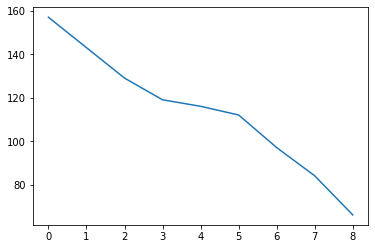

In [382]:
sns.lineplot(y)

In [383]:
#graph is linearly decreasing

In [384]:
#pip install seaborn

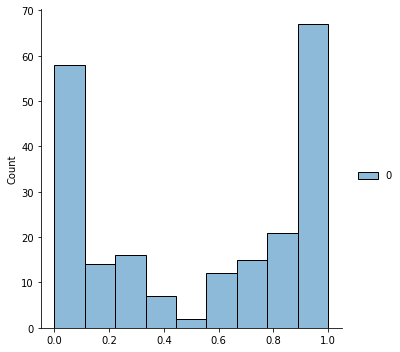

In [401]:
import seaborn as sns
sns.displot(r)

<AxesSubplot:ylabel='0'>

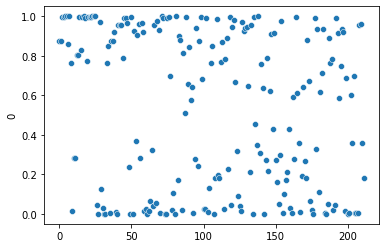

In [386]:
r1 = pd.DataFrame(r)
import seaborn as sns
sns.scatterplot(r1[0])

<AxesSubplot:ylabel='Count'>

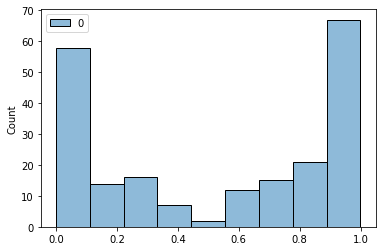

In [389]:
sns.histplot(r)

In [118]:
import nltk
nltk.download('words')

[nltk_data] Downloading package words to /home/smothe/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [119]:
from nltk.corpus import words
word_list = words.words()
# prints 236736
len(word_list)
w = word_list
w = list(w) # list of vocab words
len(w)

236736

In [125]:
c1 = []
for word in list(p['profanity']):

    if word in list(w):
        w.remove(word)
      #d = word_list[word_list[0] == word]
      #d = d.reset_index()
      #i = d['index'][0]
      #word_list = word_list.drop(word_list.index[i])
      #word_list.drop(index = i)

        c1.append(word)
pd.DataFrame(c1)

,0
0,ass
1,bitch
2,cock
3,coon
4,cripple
5,cum
6,dick
7,fag
8,hoe
9,homo


In [126]:
len(w)

236696

In [127]:
from nltk.tokenize import word_tokenize
input = 'bastard'
input1 =  word_tokenize(input)
print("input sentence: ",input)
test_sentence_or_word = fast_encode(pd.Series(input),fast_tokenizer)
x_test5 = []
x_test5.append(test_sentence_or_word[0][:192])
y = np.array(x_test5)
test_dataset2 = (
    tf.data.Dataset
    .from_tensor_slices(y)
    .batch(1) )
result = model.predict(test_dataset2)
#print(result)
results = []
print("for each word in sentence")
#if result>0.5:
for word in input1:
                                          test_sentence_or_word = fast_encode(pd.Series(word),fast_tokenizer)
                                          x_test5 = []
                                          x_test5.append(test_sentence_or_word[0][:192])
                                          y = np.array(x_test5)
                                          test_dataset3 = (
                                              tf.data.Dataset
                                              .from_tensor_slices(y)
                                              .batch(1) )
                                          result = model.predict(test_dataset3)
                                          print(result)
                                          if result>0.75 and word not in w:
                                             results.append(word)

if results:
    print("profane words in a sentence: ",results)
else:
    print("This is not a toxic sentence containing profanity words")

input sentence:  bastard


  0%|          | 0/1 [00:00<?, ?it/s]

for each word in sentence


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9951326]]
profane words in a sentence:  ['bastard']


In [128]:
from nltk.tokenize import word_tokenize
input = 'he is not an ass'
input1 =  word_tokenize(input)
print("input sentence: ",input)
test_sentence_or_word = fast_encode(pd.Series(input),fast_tokenizer)
x_test5 = []
x_test5.append(test_sentence_or_word[0][:192])
y = np.array(x_test5)
test_dataset2 = (
    tf.data.Dataset
    .from_tensor_slices(y)
    .batch(1) )
result = model.predict(test_dataset2)
print(result)
results = []
print("for each word in sentence")
#if result>0.04:
for word in input1:
                                          test_sentence_or_word = fast_encode(pd.Series(word),fast_tokenizer)
                                          x_test5 = []
                                          x_test5.append(test_sentence_or_word[0][:192])
                                          y = np.array(x_test5)
                                          test_dataset3 = (
                                              tf.data.Dataset
                                              .from_tensor_slices(y)
                                              .batch(1) )
                                          result = model.predict(test_dataset3)
                                          print(result)
                                          if result>0.75 and word not in w:
                                             results.append(word)

if results:
    print("profane words in a sentence: ",results)
else:
    print("This is not a toxic sentence containing profanity words")
input = 'he is an ass'
input1 =  word_tokenize(input)
print("input sentence: ",input)
test_sentence_or_word = fast_encode(pd.Series(input),fast_tokenizer)
x_test5 = []
x_test5.append(test_sentence_or_word[0][:192])
y = np.array(x_test5)
test_dataset2 = (
    tf.data.Dataset
    .from_tensor_slices(y)
    .batch(1) )
result = model.predict(test_dataset2)
print(result)
results = []
print("for each word in sentence")
#if result>0.04:
for word in input1:
                                          test_sentence_or_word = fast_encode(pd.Series(word),fast_tokenizer)
                                          x_test5 = []
                                          x_test5.append(test_sentence_or_word[0][:192])
                                          y = np.array(x_test5)
                                          test_dataset3 = (
                                              tf.data.Dataset
                                              .from_tensor_slices(y)
                                              .batch(1) )
                                          result = model.predict(test_dataset3)
                                          print(result)
                                          if result>0.75 and word not in w:
                                             results.append(word)
if results:
    print("profane words in a sentence: ",results)
else:
    print("This is not a toxic sentence containing profanity words")

input sentence:  he is not an ass


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8872776]]
for each word in sentence


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.0002332]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00104054]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00021128]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00193931]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]
profane words in a sentence:  ['ass']
input sentence:  he is an ass


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9737728]]
for each word in sentence


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.0002332]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00104054]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00193931]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]
profane words in a sentence:  ['ass']


In [ ]:
#AS SHOWN ABOVE, 

#THE TOXIC CALCULATION FOR SENTENCE ' HE IS NOT ASS' IS 87% AND TOXIC CALCULATION FOR SENTENCE 'HE IS ASS' IS 97% 

#TAKEAWAYS: THE MODEL PREDICTION OF PROFANITY WORDS CAN BE BASED ON CONTEXTUAL MEANING OR INTERPRETATION OF A SENTENCE

# AND ALSO THE INDIVIDUAL WORD PROBABILITIES CAN HELP FIND PROFANE WORDS IRRESPECTIVE OF THE CONTEXTUAL MEANING.

In [259]:
from nltk.tokenize import word_tokenize
input = 'Daniel Perez has 3 sisters.'
input1 =  word_tokenize(input)
print("input sentence: ",input)
test_sentence_or_word = fast_encode(pd.Series(input),fast_tokenizer)
x_test5 = []
x_test5.append(test_sentence_or_word[0][:192])
y = np.array(x_test5)
test_dataset2 = (
    tf.data.Dataset
    .from_tensor_slices(y)
    .batch(1) )
result = model.predict(test_dataset2)
print(result)
results = []
print("for each word in sentence")
#if result>0.04:
for word in input1:
                                          test_sentence_or_word = fast_encode(pd.Series(word),fast_tokenizer)
                                          x_test5 = []
                                          x_test5.append(test_sentence_or_word[0][:192])
                                          y = np.array(x_test5)
                                          test_dataset3 = (
                                              tf.data.Dataset
                                              .from_tensor_slices(y)
                                              .batch(1) )
                                          result = model.predict(test_dataset3)
                                          print(result)
                                          if result>0.9 and word not in w :
                                             results.append(word)
if results:
    print("profane words in a sentence: ",results)
else:
    print("This is not a toxic sentence containing profanity words")
input = 'Jennifer hates party'
input1 =  word_tokenize(input)
print("input sentence: ",input)
test_sentence_or_word = fast_encode(pd.Series(input),fast_tokenizer)
x_test5 = []
x_test5.append(test_sentence_or_word[0][:192])
y = np.array(x_test5)
test_dataset2 = (
    tf.data.Dataset
    .from_tensor_slices(y)
    .batch(1) )
result = model.predict(test_dataset2)
print(result)
results = []
print("for each word in sentence")
#if result>0.04:
for word in input1:
                                          test_sentence_or_word = fast_encode(pd.Series(word),fast_tokenizer)
                                          x_test5 = []
                                          x_test5.append(test_sentence_or_word[0][:192])
                                          y = np.array(x_test5)
                                          test_dataset3 = (
                                              tf.data.Dataset
                                              .from_tensor_slices(y)
                                              .batch(1) )
                                          result = model.predict(test_dataset3)
                                          print(result)
                                          if result>0.9 and word not in w:
                                             results.append(word)
if results:
    print("profane words in a sentence: ",results)
else:
    print("This is not a toxic sentence containing profanity words")

input sentence:  Daniel Perez has 3 sisters.


  0%|          | 0/1 [00:00<?, ?it/s]

[[7.954517e-05]]
for each word in sentence


  0%|          | 0/1 [00:00<?, ?it/s]

[[9.7655e-06]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[1.21377425e-05]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00057808]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00467912]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00011679]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00070994]]
This is not a toxic sentence containing profanity words
input sentence:  Jennifer hates party


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00011869]]
for each word in sentence


  0%|          | 0/1 [00:00<?, ?it/s]

[[1.6805881e-05]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.01200407]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00029376]]
This is not a toxic sentence containing profanity words


In [130]:
from nltk.tokenize import word_tokenize
input = 'this stupid motherfucker has'
input1 =  word_tokenize(input)
print("input sentence: ",input)
test_sentence_or_word = fast_encode(pd.Series(input),fast_tokenizer)
x_test5 = []
x_test5.append(test_sentence_or_word[0][:192])
y = np.array(x_test5)
test_dataset2 = (
    tf.data.Dataset
    .from_tensor_slices(y)
    .batch(1) )
result = model.predict(test_dataset2)
print(result)
results = []
print("for each word in sentence")
#if result>0.04:
for word in input1:
                                          test_sentence_or_word = fast_encode(pd.Series(word),fast_tokenizer)
                                          x_test5 = []
                                          x_test5.append(test_sentence_or_word[0][:192])
                                          y = np.array(x_test5)
                                          test_dataset3 = (
                                              tf.data.Dataset
                                              .from_tensor_slices(y)
                                              .batch(1) )
                                          result = model.predict(test_dataset3)
                                          print(result)
                                          if result>0.9 and word not in w :
                                             results.append(word)
if results:
    print("profane words in a sentence: ",results)
else:
    print("This is not a toxic sentence containing profanity words")
input = 'this stupid mothrfucker has'
input1 =  word_tokenize(input)
print("input sentence: ",input)
test_sentence_or_word = fast_encode(pd.Series(input),fast_tokenizer)
x_test5 = []
x_test5.append(test_sentence_or_word[0][:192])
y = np.array(x_test5)
test_dataset2 = (
    tf.data.Dataset
    .from_tensor_slices(y)
    .batch(1) )
result = model.predict(test_dataset2)
print(result)
results = []
print("for each word in sentence")
#if result>0.04:
for word in input1:
                                          test_sentence_or_word = fast_encode(pd.Series(word),fast_tokenizer)
                                          x_test5 = []
                                          x_test5.append(test_sentence_or_word[0][:192])
                                          y = np.array(x_test5)
                                          test_dataset3 = (
                                              tf.data.Dataset
                                              .from_tensor_slices(y)
                                              .batch(1) )
                                          result = model.predict(test_dataset3)
                                          print(result)
                                          if result>0.9 and word not in w:
                                             results.append(word)
if results:
    print("profane words in a sentence: ",results)
else:
    print("This is not a toxic sentence containing profanity words")

input sentence:  this stupid motherfucker has


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99411714]]
for each word in sentence


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.0002768]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.94025195]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99138945]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00057808]]
profane words in a sentence:  ['motherfucker']
input sentence:  this stupid mothrfucker has


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.87783086]]
for each word in sentence


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.0002768]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.94025195]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.14422353]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00057808]]
This is not a toxic sentence containing profanity words


In [ ]:
#Model is clearly sensitive to typos. Issue tackled using spell correctors

In [131]:
test = pd.read_csv('test165.csv')
test

,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,975,01a486143daf1fc6,"go to court? \n Shit, cause the judge look ju...",1,1,1,0,1,1
1,1521,028f7f59fdb9a631,"fuck islam , fuck Saud -Arabia",1,1,1,0,1,1
2,1841,03290c0e8afef0fb,== LUNA SANTIN IS A FUCKER WHO LIKES GAY NIGGE...,1,1,1,0,1,1
3,2182,03c6344729c4e665,Azerbaijanis Proud of Ramil Safarov \n If I h...,1,0,1,1,1,1
4,4803,082222a24e83a16b,Eat a dick fag.,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...
160,148957,f8fc48032f1af739,"Here you go you ass-hole, fucking ban me see i...",1,1,1,0,1,1
161,149799,fa6115113f432a40,== YOU SUCK!!! == \n\n YOU REALLY REALLY REALL...,1,1,1,1,1,0
162,150136,faebd256d585a0ee,Mexican dickhead \n\n You and your family shou...,1,0,1,1,1,1
163,150847,fc2b7140dce696bd,ANAL GAY RAPE MOLEST SHEMALE PORN. \n I HOPE Y...,1,0,1,1,1,1


In [132]:
test.comment_text[0]

"go to court? \n  Shit, cause the judge look just like that motherfucker put our ass on the boat and made me a nigga \n\n  [Outro] \n Mamma Rag is a nigga \n Du-Rag is a nigga \n Ballistics is a nigga \n And I'm Uretha's nigga \n  Nigga"

In [133]:
#s = test.comment_text[i]
input = "nigger"
input1 =  word_tokenize(input)
print("input sentence: ",input)
test_sentence_or_word = fast_encode(pd.Series(input),fast_tokenizer)
x_test5 = []
x_test5.append(test_sentence_or_word[0][:192])
y = np.array(x_test5)
test_dataset2 = (
        tf.data.Dataset
        .from_tensor_slices(y)
        .batch(1) )
result = model.predict(test_dataset2)
print(result)

input sentence:  nigger


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8511693]]


In [134]:
test_results = []
input_sentences = []
for i in range(10):
    s = test.comment_text[i]
    input = s
    input1 =  word_tokenize(input)
    print("input sentence: ",input)
    test_sentence_or_word = fast_encode(pd.Series(input),fast_tokenizer)
    x_test5 = []
    x_test5.append(test_sentence_or_word[0][:192])
    y = np.array(x_test5)
    test_dataset2 = (
        tf.data.Dataset
        .from_tensor_slices(y)
        .batch(1) )
    result = model.predict(test_dataset2)
    results = []
    print("for each word in sentence")
    #if result>0.04:
    input_sentences.append(input1)
    for word in input1:
                                          test_sentence_or_word = fast_encode(pd.Series(word),fast_tokenizer)
                                          x_test5 = []
                                          x_test5.append(test_sentence_or_word[0][:192])
                                          y = np.array(x_test5)
                                          test_dataset3 = (
                                              tf.data.Dataset
                                              .from_tensor_slices(y)
                                              .batch(1) )
                                          result = model.predict(test_dataset3)
                                          print(result)
                                          if result>0.75 and word not in w:
                                             results.append(word)
    if results:
        print("profane words in a sentence: ",set(results))
        test_results.append(1)
    else:
        print("This is not a toxic sentence containing profanity words")
        test_results.append(0)

input sentence:  go to court? 
  Shit, cause the judge look just like that motherfucker put our ass on the boat and made me a nigga 

  [Outro] 
 Mamma Rag is a nigga 
 Du-Rag is a nigga 
 Ballistics is a nigga 
 And I'm Uretha's nigga 
  Nigga


  0%|          | 0/1 [00:00<?, ?it/s]

for each word in sentence


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00187296]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00678039]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00020094]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00140416]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9353942]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00044256]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00028521]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00113925]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00011522]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00010719]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00394415]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00066183]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00113457]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99138945]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00808157]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00235646]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00028758]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00113925]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.0014749]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00166091]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00014417]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00172024]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00222164]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.76231563]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00057945]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00180741]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.06769408]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00030738]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.02138543]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00104054]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00222164]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.76231563]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.25750676]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00104054]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00222164]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.76231563]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00057093]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00104054]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00222164]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.76231563]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00010325]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00095059]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.02109407]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.01248429]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.0067817]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.76231563]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.18850933]]
profane words in a sentence:  {'motherfucker', 'ass', 'Shit', 'nigga'}
input sentence:  fuck islam , fuck Saud -Arabia


  0%|          | 0/1 [00:00<?, ?it/s]

for each word in sentence


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9943479]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00016213]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00044256]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9943479]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00115965]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[6.0230937e-05]]
profane words in a sentence:  {'fuck'}
input sentence:  == LUNA SANTIN IS A FUCKER WHO LIKES GAY NIGGERS == 

 GAY NIGGER-LOVER


  0%|          | 0/1 [00:00<?, ?it/s]

for each word in sentence


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00023697]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03820798]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00793581]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00084952]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00456659]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.98405683]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.0020946]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00279252]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00023697]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00279252]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.11716174]]
profane words in a sentence:  {'FUCKER'}
input sentence:  Azerbaijanis Proud of Ramil Safarov  
 If I had the same opportunity under same circumstances, i would kill both bastard and mother fucker armenians bitches soldiers for insulting Azerbaijani flag. Bastard gurgen lay in hell mother fucker. I fuck your soul and your whore mother. Assholes. Fuck armenian fascists and natinoalists.


  0%|          | 0/1 [00:00<?, ?it/s]

for each word in sentence


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.07988142]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.17138651]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00347292]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00213907]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1562628]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00040884]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00095059]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00039287]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00113925]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00025497]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00022831]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00013573]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00025497]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00011578]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00044256]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00900332]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00011264]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.0021721]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00032096]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9951326]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00166091]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00018938]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99810815]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00480571]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99071586]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00161939]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00020177]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00054493]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00657465]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00522903]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00070994]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.983173]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.2295027]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00278777]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00147984]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.3187111]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00018938]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99810815]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00070994]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00095059]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9943479]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.06373145]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00022502]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00166091]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.06373145]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9235714]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00018938]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00070994]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9937529]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00070994]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9951184]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00301098]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00169432]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00166091]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.0073722]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00070994]]
profane words in a sentence:  {'fucker', 'fuck', 'bitches', 'Fuck', 'whore', 'Assholes', 'bastard'}
input sentence:  Eat a dick fag.


  0%|          | 0/1 [00:00<?, ?it/s]

for each word in sentence


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00254964]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00222164]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8275487]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9962561]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00070994]]
profane words in a sentence:  {'fag', 'dick'}
input sentence:  ONLY STUPID NIGGERS LIKE ANTANDRUS LIKES THIS SHITONLY STUPID NIGGERS LIKE ANTANDRUS LIKES THIS SHITONLY STUPID NIGGERS LIKE ANTANDRUS LIKES THIS SHITONLY STUPID NIGGERS LIKE ANTANDRUS LIKES THIS SHITONLY STUPID NIGGERS LIKE ANTANDRUS LIKES THIS SHITONLY STUPID NIGGERS LIKE ANTANDRUS LIKES THIS SHITONLY STUPID NIGGERS LIKE ANTANDRUS LIKES THIS SHITONLY STUPID NIGGERS LIKE ANTANDRUS LIKES THIS SHITONLY STUPID NIGGERS LIKE ANTANDRUS LIKES THIS SHITONLY STUPID NIGGERS LIKE ANTANDRUS LIKES THIS SHITONLY STUPID NIGGERS LIKE ANTANDRUS LIKES THIS SHITONLY STUPID NIGGERS LIKE ANTANDRUS LIKES THIS SHITONLY STUPID NIGGERS LIKE ANTANDRUS LIKES THIS SHITONLY STUPID NIGGERS LIKE ANTANDRUS LIKES THIS SHITONLY STUPID NIGGERS LIKE ANTANDRUS LIKES THIS SHITONLY STUPID NIGGERS LIKE ANTANDRUS LIKES THIS SHITONLY STUPID NIGGERS LIKE ANTANDRUS LIKES THIS SHITONLY STUPID NIGGERS LIKE ANTANDRUS LIKES THIS SHITONLY STUPID NIGGERS LI

  0%|          | 0/1 [00:00<?, ?it/s]

for each word in sentence


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00105874]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00992715]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.1667896]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23021668]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349968]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00196466]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.132972]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00226248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03925803]]
This is not a toxic sentence containing profanity words
input sentence:  == fucking CU blocked, faggot ==


  0%|          | 0/1 [00:00<?, ?it/s]

for each word in sentence


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00023697]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99933404]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.02920011]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00013722]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00044256]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9993845]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00023697]]
profane words in a sentence:  {'faggot', 'fucking'}
input sentence:  Hey youre a fag. I wish you weren't a fag. Go fuck yourself


  0%|          | 0/1 [00:00<?, ?it/s]

for each word in sentence


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00176483]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.38685426]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00222164]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9962561]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00070994]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00095059]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00041234]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00592925]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00050024]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.38421512]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00222164]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9962561]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00070994]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00139027]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9943479]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.02442057]]
profane words in a sentence:  {'fag', 'fuck'}
input sentence:  Shawn DICKHEAD  
 a fucking faggot assholoe with small tits and big ass ass and no dick cuz hes a faggit and gay and sucks dick in the hallway of school cuz hes gayyyyyyyyy


  0%|          | 0/1 [00:00<?, ?it/s]

for each word in sentence


  0%|          | 0/1 [00:00<?, ?it/s]

[[1.3290688e-05]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.07527608]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00222164]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99933404]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9993845]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.867054]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00292248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00020236]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.38279486]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00166091]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00538746]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00166091]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.01323238]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8275487]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.98120075]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.007706]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00222164]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9934876]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00166091]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.014429]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00166091]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.97042817]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8275487]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00147984]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00113925]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00039107]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00347292]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[9.8843186e-05]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.98120075]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.007706]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.7058033]]
profane words in a sentence:  {'dick', 'faggot', 'faggit', 'cuz', 'ass', 'assholoe', 'fucking', 'sucks'}
input sentence:  Kermanshahi, sorry for me to say, but I really am your sockpuppet, you nasty li'll sockpuppeteer! Damn you, scurvy dog, I'll go to you home with a gun, rape your wife, burn the whole shit, and, last but not last: I will kill your hamster! Oh, en please, dear sockpuppeteer, go away from wikipedia, you damn liar!


  0%|          | 0/1 [00:00<?, ?it/s]

for each word in sentence


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9134759]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00044256]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.0012598]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00020177]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00172024]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00678039]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00026501]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00044256]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00030684]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00095059]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00237314]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00625563]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.06373145]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00037554]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00044256]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00592925]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.05077378]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.73677814]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.02810107]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00049767]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23556502]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.92779475]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00592925]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00044256]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.7133294]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00246692]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00044256]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00095059]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.02810107]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00187296]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00678039]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00592925]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00016038]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00292248]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00222164]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.01072687]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00044256]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00210633]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.06373145]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00033808]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00044256]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.01790819]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00113925]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00187395]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.95339966]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00044256]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00166091]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00044256]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.0015046]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00030684]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00021128]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.0015046]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00057857]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00095059]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00059179]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.0021721]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.06373145]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.0113582]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23556502]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00064578]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00044256]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.98942417]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00038892]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00044256]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.07028929]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00049767]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00044256]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00187296]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.0011663]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00126472]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00032073]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00044256]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00592925]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.97948486]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.40930098]]


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23556502]]
profane words in a sentence:  {'Damn', 'Kermanshahi', 'shit'}


In [135]:
test_results

[1, 1, 1, 1, 1, 0, 1, 1, 1, 1]

In [459]:
s1 = str.lower('only stupid niggers like antandrus likes this shit')
s1

'only stupid niggers like antandrus likes this shit'

In [457]:
from nltk.tokenize import word_tokenize
input = s1
input1 =  word_tokenize(input)
print("input sentence: ",input)
test_sentence_or_word = fast_encode(pd.Series(input),fast_tokenizer)
x_test5 = []
x_test5.append(test_sentence_or_word[0][:192])
y = np.array(x_test5)
test_dataset2 = (
    tf.data.Dataset
    .from_tensor_slices(y)
    .batch(1) )
result = model.predict(test_dataset2)
print(result)
results = []
print("for each word in sentence")
#if result>0.04:
for word in input1:
                                          test_sentence_or_word = fast_encode(pd.Series(word),fast_tokenizer)
                                          x_test5 = []
                                          x_test5.append(test_sentence_or_word[0][:192])
                                          y = np.array(x_test5)
                                          test_dataset3 = (
                                              tf.data.Dataset
                                              .from_tensor_slices(y)
                                              .batch(1) )
                                          result = model.predict(test_dataset3)
                                          print(result)
                                          print(word)
                                          if result>0.75 and word not in w :
                                             results.append(word)
if results:
    print("profane words in a sentence: ",set(results))
else:
    print("This is not a toxic sentence containing profanity words")

input sentence:  only stupid niggers like antandrus likes this shit


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9844413]]
for each word in sentence


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00075567]]
only


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.94025195]]
stupid


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.7935384]]
niggers


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00066183]]
like


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00419114]]
antandrus


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00122418]]
likes


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.0002768]]
this


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.95339966]]
shit
profane words in a sentence:  {'niggers', 'shit'}


In [138]:
test.comment_text[6]

'== fucking CU blocked, faggot =='

In [233]:
def clean(text):
    text = text.fillna("fillna").str.lower()
    text = text.map(lambda x: re.sub('\\n',' ',str(x)))
    text = text.map(lambda x: re.sub("\[\[User.*",'',str(x)))
    text = text.map(lambda x: re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",'',str(x)))
    text = text.map(lambda x: re.sub("\(http://.*?\s\(http://.*\)",'',str(x)))
    return text

#val["comment_text"] = clean(val["comment_text"])
test["comment_text"] = clean(test["comment_text"])

In [234]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', '\xa0', '\t',
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '\u3000', '\u202f',
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '«',
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

def clean_text(x):
    x = str(x).replace("\n","")
    for punct in puncts:
        x = x.replace(punct, '')
    return x
clean_text('i"m aryan')

'im aryan'

In [440]:
mispell_dict = {"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"couldnt" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"doesnt" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"havent" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"shouldnt" : "should not",
"that's" : "that is",
"thats" : "that is",
"there's" : "there is",
"theres" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"theyre":  "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying",
"arent" : "are not",
"cant" : "cannot",
"couldnt" : "could not",
"couldnt" : "could not",
"didnt" : "did not",
"doesnt" : "does not",
"doesnt" : "does not",
"dont" : "do not",
"hadnt" : "had not",
"hasnt" : "has not",
"havent" : "have not",
"havent" : "have not",
"hed" : "he would",
"hell" : "he will",
"hes" : "he is",
"id" : "I would",
"id" : "I had",
"ill" : "I will",
"im" : "I am",
"isnt" : "is not",
"its" : "it is",
"itll":"it will",
"ive" : "I have",
"lets" : "let us",
"mightnt" : "might not",
"mustnt" : "must not",
"shant" : "shall not",
"shed" : "she would",
"shell" : "she will",
"shes" : "she is",
"shouldnt" : "should not",
"shouldnt" : "should not",
"thats" : "that is",
"thats" : "that is",
"theres" : "there is",
"theres" : "there is",
"theyd" : "they would",
"theyll" : "they will",
"theyre" : "they are",
"theyre":  "they are",
"theyve" : "they have",
"wed" : "we would",
"were" : "we are",
"werent" : "were not",
"weve" : "we have",
"whatll" : "what will",
"whatre" : "what are",
"whats" : "what is",
"whatve" : "what have",
"wheres" : "where is",
"whod" : "who would",
"wholl" : "who will",
"whore" : "who are",
"whos" : "who is",
"whove" : "who have",
"wont" : "will not",
"wouldnt" : "would not",
"youd" : "you would",
"youll" : "you will",
"youre" : "you are",
"youve" : "you have",
"'re": " are",
"wasnt": "was not",
"well":" will",
"didnt": "did not",
"tryin":"trying"}

def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re


In [433]:
def clean_numbers(x):
    x = re.sub('[0-9]{5,}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    return x

from nltk.tokenize.treebank import TreebankWordTokenizer
tokenizer = TreebankWordTokenizer()

def handle_contractions(x):
    x = tokenizer.tokenize(x)
    return x

def fix_quote(x):
    x = [x_[1:] if x_.startswith("'") else x_ for x_ in x]
    x = ' '.join(x)
    return x

def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re


def replace_typical_misspell(text):
    mispellings, mispellings_re = _get_mispell(mispell_dict)

    def replace(match):
        return mispellings[match.group(0)]

    return mispellings_re.sub(replace, text)


def clean_data(df, columns: list):
    for col in columns:
        #df[col] = df[col].apply(lambda x: clean_numbers(x))
        df[col] = df[col].apply(lambda x: clean_text(x.lower()))
        df[col] = df[col].apply(lambda x: replace_typical_misspell(x))
        df[col] = df[col].apply(lambda x: handle_contractions(x))
        df[col] = df[col].apply(lambda x: fix_quote(x))

    return df

input_columns = [
    'comment_text'
]

'''applying text cleaning techniques like clean_text,replace_typical_misspell,handle_contractions,fix_quote
on train,test and validation set'''

test_cleaned = clean_data(test, input_columns )


In [437]:
x = str('isnt')
if x in mispell_dict:
    print('yes')
    x = mispell_dict['isnt']
    print(x)   
else:
     print('no')

yes
is not


In [443]:
def clean_data_dynamic(x):
        #for col in columns:
        #df[col] = df[col].apply(lambda x: clean_numbers(x))
        #x = pd.DataFrame(x)
        mispell_dict = {"aren't" : "are not",
        "can't" : "cannot",
        "couldn't" : "could not",
        "couldnt" : "could not",
        "didn't" : "did not",
        "doesn't" : "does not",
        "doesnt" : "does not",
        "don't" : "do not",
        "hadn't" : "had not",
        "hasn't" : "has not",
        "haven't" : "have not",
        "havent" : "have not",
        "he'd" : "he would",
        "he'll" : "he will",
        "he's" : "he is",
        "i'd" : "I would",
        "i'd" : "I had",
        "i'll" : "I will",
        "i'm" : "I am",
        "isn't" : "is not",
        "it's" : "it is",
        "it'll":"it will",
        "i've" : "I have",
        "let's" : "let us",
        "mightn't" : "might not",
        "mustn't" : "must not",
        "shan't" : "shall not",
        "she'd" : "she would",
        "she'll" : "she will",
        "she's" : "she is",
        "shouldn't" : "should not",
        "shouldnt" : "should not",
        "that's" : "that is",
        "thats" : "that is",
        "there's" : "there is",
        "theres" : "there is",
        "they'd" : "they would",
        "they'll" : "they will",
        "they're" : "they are",
        "theyre":  "they are",
        "they've" : "they have",
        "we'd" : "we would",
        "we're" : "we are",
        "weren't" : "were not",
        "we've" : "we have",
        "what'll" : "what will",
        "what're" : "what are",
        "what's" : "what is",
        "what've" : "what have",
        "where's" : "where is",
        "who'd" : "who would",
        "who'll" : "who will",
        "who're" : "who are",
        "who's" : "who is",
        "who've" : "who have",
        "won't" : "will not",
        "wouldn't" : "would not",
        "you'd" : "you would",
        "you'll" : "you will",
        "you're" : "you are",
        "you've" : "you have",
        "'re": " are",
        "wasn't": "was not",
        "we'll":" will",
        "didn't": "did not",
        "tryin'":"trying",
        "arent" : "are not",
        "cant" : "cannot",
        "couldnt" : "could not",
        "couldnt" : "could not",
        "didnt" : "did not",
        "doesnt" : "does not",
        "doesnt" : "does not",
        "dont" : "do not",
        "hadnt" : "had not",
        "hasnt" : "has not",
        "havent" : "have not",
        "havent" : "have not",
        "hed" : "he would",
        "hell" : "he will",
        "hes" : "he is",
        "id" : "I would",
        "id" : "I had",
        "ill" : "I will",
        "im" : "I am",
        "isnt" : "is not",
        "its" : "it is",
        "itll":"it will",
        "ive" : "I have",
        "lets" : "let us",
        "mightnt" : "might not",
        "mustnt" : "must not",
        "shant" : "shall not",
        "shed" : "she would",
        "shell" : "she will",
        "shes" : "she is",
        "shouldnt" : "should not",
        "shouldnt" : "should not",
        "thats" : "that is",
        "thats" : "that is",
        "theres" : "there is",
        "theres" : "there is",
        "theyd" : "they would",
        "theyll" : "they will",
        "theyre" : "they are",
        "theyre":  "they are",
        "theyve" : "they have",
        "wed" : "we would",
        "were" : "we are",
        "werent" : "were not",
        "weve" : "we have",
        "whatll" : "what will",
        "whatre" : "what are",
        "whats" : "what is",
        "whatve" : "what have",
        "wheres" : "where is",
        "whod" : "who would",
        "wholl" : "who will",
        "whore" : "who are",
        "whos" : "who is",
        "whove" : "who have",
        "wont" : "will not",
        "wouldnt" : "would not",
        "youd" : "you would",
        "youll" : "you will",
        "youre" : "you are",
        "youve" : "you have",
        "'re": " are",
        "wasnt": "was not",
        "well":" will",
        "didnt": "did not",
        "tryin":"trying"}

        
        x = clean_text(x.lower())
        x = replace_typical_misspell(x)
        x = handle_contractions(x)
        x = fix_quote(x)
        if x in mispell_dict:
            x = mispell_dict[x] 
        return x

In [444]:
clean_data_dynamic('isnt')

'is not'

In [239]:
test_cleaned.iloc[:10]

,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,975,01a486143daf1fc6,go to court shit cause the judge look just lik...,1,1,1,0,1,1
1,1521,028f7f59fdb9a631,fuck islam fuck saud arabia,1,1,1,0,1,1
2,1841,03290c0e8afef0fb,luna santin is a fucker who likes gay niggers ...,1,1,1,0,1,1
3,2182,03c6344729c4e665,azerbaijanis proud of ramil safarov if i had t...,1,0,1,1,1,1
4,4803,082222a24e83a16b,eat a dick fag,1,1,1,0,1,1
5,4954,085d509dbe43218f,only stupid niggers like antandrus likes this ...,1,1,1,0,1,1
6,5789,09c4bfe6a7bf4cd8,fucking cu blocked faggot,1,1,1,0,1,1
7,5858,09e3522f50ebcca8,hey youre a fag i wish you werent a fag go fuc...,1,1,1,0,1,1
8,5947,0a03b4273af37627,shawn dickhead a fucking faggot assholoe with ...,1,1,1,0,1,1
9,8614,0e7223e42fb8a4fe,kermanshahi sorry for me to say but i really a...,1,1,1,1,1,0


In [ ]:
test_results = []
input_sentences = []
for i in range(len(test_cleaned)):
    s = test_cleaned.comment_text[i+100]
    input = s
    input1 =  word_tokenize(input)
    print("input sentence: ",input)
    test_sentence_or_word = fast_encode(pd.Series(input),fast_tokenizer)
    x_test5 = []
    x_test5.append(test_sentence_or_word[0][:192])
    y = np.array(x_test5)
    test_dataset2 = (
        tf.data.Dataset
        .from_tensor_slices(y)
        .batch(1) )
    result = model.predict(test_dataset2)
    results = []
    print("for each word in sentence")
    #if result>0.04:
    input_sentences.append(input1)
    for word in input1:
                                          test_sentence_or_word = fast_encode(pd.Series(word),fast_tokenizer)
                                          x_test5 = []
                                          x_test5.append(test_sentence_or_word[0][:192])
                                          y = np.array(x_test5)
                                          test_dataset3 = (
                                              tf.data.Dataset
                                              .from_tensor_slices(y)
                                              .batch(1) )
                                          result = model.predict(test_dataset3)
                                          print(result)
                                          if result>0.75 and word not in w:
                                             results.append(word)
    if results:
        print("profane words in a sentence: ",set(results))
        test_results.append(1)
    else:
        print("This is not a toxic sentence containing profanity words")
        test_results.append(0)

In [241]:
len(test_results)

15

In [242]:
#All the Actual labels for the first 10 examples are 1. And the predicted labels for those first ten examples are 1's too
#Now lets see how it predicts for all the examples
pd.DataFrame(test_results).value_counts()

1    15
dtype: int64

In [243]:
#NOTE: This new dataset has only sentences containing profane words

In [244]:
import sklearn
from sklearn.metrics import classification_report
print(sklearn.metrics.accuracy_score(test_results,len(test_results)*[1]))

1.0


In [ ]:
# As observed, All the sentences containing profane words are classified as 1, which is good sign in terms of model's performance.


In [ ]:
#ROBUSTNESS

In [ ]:
#pip install checklist

In [ ]:
#pip install ekphrasis -U

In [446]:
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'url', 'date', 'number'],
    # terms that will be annotated
    annotate={"hashtag", "allcaps", "elongated", "repeated",
        'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens

    # corpus from which the word statistics are going to be used
    # for word segmentation
    segmenter="twitter",

    # corpus from which the word statistics are going to be used
    # for spell correction
    corrector="twitter",

    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words

    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,

    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)

sentences = [
    "CANT WAIT for the new season of #TwinPeaks ＼(^o^)／!!! #davidlynch #tvseries :)))",
    "I saw the new #johndoe movie and it suuuuucks!!! WAISTED $10... #badmovies :/",
    "@SentimentSymp:  can't wait for the Nov 9 #Sentiment talks!  YAAAAAAY !!! :-D http://sentimentsymposium.com/."
]

for s in sentences:
    print(" ".join(text_processor.pre_process_doc(s)))

Word statistics files not found!
Downloading... 

/home/smothe/.local/lib/python3.9/site-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /home/smothe/.ekphrasis/stats/twitter/counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams /home/smothe/.ekphrasis/stats/twitter/counts_2grams.txt
Reading twitter - 1grams ...
<allcaps> cant wait </allcaps> for the new season of <hashtag> twin peaks </hashtag> ＼(^o^)／ ! <repeated> <hashtag> david lynch </hashtag> <hashtag> tv series </hashtag> <happy>
i saw the new <hashtag> john doe </hashtag> movie and it sucks <elongated> ! <repeated> <allcaps> waisted </allcaps> <money> . <repeated> <hashtag> bad movies </hashtag> <annoyed>
<user> : can not wait for the <date> <hashtag> sentiment </hashtag> talks ! <allcaps> yay <elongated> </allcaps> ! <repeated> <laugh> <url>


/home/smothe/.local/lib/python3.9/site-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


In [245]:
from ekphrasis.classes.spellcorrect import SpellCorrector
sp = SpellCorrector(corpus="english") 
print(sp.correct("korrect"))

Reading english - 1grams ...
correct


In [246]:
sp = SpellCorrector(corpus="english")
s = sp.correct("mothrfuckerr")
s1 = sp.correct(s)
s = sp.correct(s1)

Reading english - 1grams ...


In [247]:
s5 ='this stupid mothrfucker='
s6 = ''
i = 0
sp = SpellCorrector(corpus="english")
for word in s5.split():
    if i == 0:
                s = word
                s1 = sp.correct(s)
                s1 = sp.correct(s1)
                s1 = sp.correct(s1)
                s6 = str(s6 + s1)
                i += 1
    else:
                s = word
                s1 = sp.correct(s)
                s1 = sp.correct(s1)
                s1 = sp.correct(s1)
                s6 = str(s6 +' '+ s1)
s6

Reading english - 1grams ...


'this stupid motherfucker'

In [447]:
clean_data_dynamic('This john isnt ass ran.')

'this john is not ass ran'

In [ ]:
#YOU CAN TRY ANY DYNAMIC INPUT TEST HERE

In [460]:
test_results = []
input_sentences = []
for i in range(1):
    s5 ='This john isnt ass ran.' # YOUR INPUT IN ' '
    input =  clean_data_dynamic(s5)
    s5 = input
    #s5 ='this stupid mothrfucker'
    s6 = ''
    i = 0
    sp = SpellCorrector(corpus="english")
    for word in s5.split():
      if i == 0:
          s = word
          s1 = sp.correct(s)
          s1 = sp.correct(s1)
          s1 = sp.correct(s1)
          s6 = str(s6 + s1)
          i += 1
      else:
          s = word
          s1 = sp.correct(s)
          s1 = sp.correct(s1)
          s1 = sp.correct(s1)
          s6 = str(s6 +' '+ s1)
    input1 = word_tokenize(s6)
    print("input sentence: ",input)
    test_sentence_or_word = fast_encode(pd.Series(input),fast_tokenizer)
    x_test5 = []
    x_test5.append(test_sentence_or_word[0][:192])
    y = np.array(x_test5)
    test_dataset2 = (
        tf.data.Dataset
        .from_tensor_slices(y)
        .batch(1) )
    result = model.predict(test_dataset2)
    results = []
    print("for each word in sentence")
    #if result>0.04:
    input_sentences.append(input1)
    for word in input1:
                                          print(word)
                                          test_sentence_or_word = fast_encode(pd.Series(word),fast_tokenizer)
                                          x_test5 = []
                                          x_test5.append(test_sentence_or_word[0][:192])
                                          y = np.array(x_test5)
                                          test_dataset3 = (
                                              tf.data.Dataset
                                              .from_tensor_slices(y)
                                              .batch(1) )
                                          result = model.predict(test_dataset3)
                                          print(result)
                                          #if pos_tag(word_tokenize(word))[0][1] == 'NNP' or pos_tag(word_tokenize(word))[0][1] == 'NN' or pos_tag(word_tokenize(word))[0][1] == 'NNS' or pos_tag(word_tokenize(word))[0][1] == 'NNPS':
                                             #if word not in list(p['profanity']):
                                                #continue
                                          if result>0.75 and word not in w:
                                             results.append(word)
                                             #print(result)
    if results:
        print("profane words in a sentence: ",set(results))
        test_results.append(1)
    else:
        print("This is not a toxic sentence containing profanity words")
        test_results.append(0)

Reading english - 1grams ...
input sentence:  this john is not ass ran


  0%|          | 0/1 [00:00<?, ?it/s]

for each word in sentence
this


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.0002768]]
john


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.22466576]]
is


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00104054]]
not


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00021128]]
ass


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]
ran


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00036706]]
profane words in a sentence:  {'ass'}


In [450]:
def wrap2(sentences):
 #sentences = ['this stupid mothrfucker','you ass high']
 if sentences == []:
   wrapper_outputs = []
   wrapper_output_list = []
   return np.array((np.array(wrapper_outputs),np.array(wrapper_output_list))).reshape(0,2)
 test_results = []
 wrapper_outputs = []
 wrapper_outputs2 = []
 sentence_outputs = []
 wrapper_output_list = []
 check = False
 for sentence1 in range(len(sentences)):
    s3 = sentences[sentence1].split()
    print("\n sentence: ",s3)
    s6 = ''
    j = 0
    sp = SpellCorrector(corpus="english")
    for word in s3:
          if j == 0:
              s = word
              s1 = sp.correct(s)
              s1 = sp.correct(s1)
              s1 = sp.correct(s1)
              s6 = str(s6 + s1)
              j += 1
          else:
              s = word
              s1 = sp.correct(s)
              s1 = sp.correct(s1)
              s1 = sp.correct(s1)
              print("corrected : {s1}",s1)
              s6 = str(s6 +' '+ s1)
              #s6 = [].append(s6)
    print("cleaned sentence:", s6)          
    for i in range(len(s3)):
        print("\n","word: ",s6.split()[i],"\n")
        s5 = s6.split()[i]
        input =  clean_data_dynamic(s5)
        s5 = input
        test_sentence_or_word = fast_encode(pd.Series(input),fast_tokenizer)
        x_test5 = []
        x_test5.append(test_sentence_or_word[0][:192])
        y = np.array(x_test5)
        test_dataset3 = (
            tf.data.Dataset
            .from_tensor_slices(y)
            .batch(1) )
        result = model.predict(test_dataset3)
        #wrapper_output = result
        wrapper_output = result
        wrapper_outputs = []
        wrapper_outputs.append([wrapper_output,1- wrapper_output])
        #if pos_tag(word_tokenize(input))[0][1] == 'NNP' or pos_tag(word_tokenize(input))[0][1] == 'NN' or pos_tag(word_tokenize(input))[0][1] == 'NNS' or pos_tag(word_tokenize(input))[0][1] == 'NNPS':
        #   continue
        if result>0.8 and input not in w:
           results.append(input)
           wrapper_output = result
           wrapper_outputs = []
           wrapper_outputs.append([wrapper_output,1- wrapper_output])
           print(result)
           #wrapper_outputs2.append(1-wrapper_output)
           check = True
           #sentence_outputs.append(1)
           break
    
    wrapper_output_list.append(wrapper_outputs)
    if check:
           sentence_outputs.append(1)
           check = False
    else: 
           sentence_outputs.append(0)      
 return np.array(sentence_outputs),np.array(wrapper_output_list).reshape(len(sentence_outputs),2)                   

In [452]:
r8,r9 = wrap2(['john','bad','ass','ugly','isnt'])


 sentence:  ['john']
Reading english - 1grams ...
cleaned sentence: john

 word:  john 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['bad']
Reading english - 1grams ...
cleaned sentence: bad

 word:  bad 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['ass']
Reading english - 1grams ...
cleaned sentence: ass

 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['ugly']
Reading english - 1grams ...
cleaned sentence: ugly

 word:  ugly 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['isnt']
Reading english - 1grams ...
cleaned sentence: isnt

 word:  isnt 



  0%|          | 0/1 [00:00<?, ?it/s]

In [453]:
r8,r9

(array([0, 0, 1, 0, 0]),
 array([[2.24665761e-01, 7.75334239e-01],
        [6.77481527e-03, 9.93225157e-01],
        [8.74813378e-01, 1.25186622e-01],
        [1.54172825e-02, 9.84582722e-01],
        [3.87177570e-04, 9.99612808e-01]], dtype=float32))

In [149]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /home/smothe/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [150]:
import checklist
from checklist.editor import Editor
from checklist.perturb import Perturb
from checklist.test_types import MFT, INV, DIR

In [151]:
editor = Editor()

In [152]:
# First, let's find some positive and negative adjectives
', '.join(editor.suggest('This is not {a:mask} {thing}.', thing=['book', 'movie', 'show', 'game'])[:30])

/home/smothe/.local/lib/python3.9/site-packages/checklist/text_generation.py:171: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  to_pred = torch.tensor(to_pred, device=self.device).to(torch.int64)


'easy, academic, ordinary, educational, average, enjoyable, entertaining, interesting, old, independent, good, art, exciting, original, ideal, innocent, excellent, adventure, amateur, awards, actual, introductory, engaging, obscure, amazing, bad, experimental, accessible, awful, great'

In [153]:
pos = ["good",
    "realistic",
    "healthy",
    "attractive",
    "appealing",
    "acceptable",
    "best",
    "feasible",
    "easy",
    "ideal",
    "affordable",
    "economical",
    "recommended",
    "exciting",
    "inexpensive",
    "obvious",
    "great",
    "appropriate",
    "effective",
    "excellent",
    "engaging"
    "happy"
    "relax"
    "calm"
    "peace"
    "motive"
    "believe"
    "right"
    "correct"
    "precise"]
neg = list(p['profanity'].loc[p['language'] == 'EN'])

In [154]:
ret = editor.template('This is not {a:pos} {mask}.', pos=pos, labels=0, save=True, nsamples=2)
ret += editor.template('This is not {a:neg} {mask}.', neg=neg, labels=1, save=True, nsamples=2)

In [155]:
ret.data

['This is not a realistic sign.',
 'This is not a recommended decision.',
 'This is not an ass website.',
 'This is not a cum job.']

In [156]:
ret += editor.template('I used to go {a:pos} {mask}.', pos=pos, labels=0, save=True, nsamples=2)

In [157]:
ret += editor.template('I am a {a:neg} {mask}.', neg=neg, labels=1, save=True, nsamples=2)

In [158]:
ret += editor.template('This is not {a:neg} {mask}.', neg=neg, labels=1, save=True, nsamples=2)

In [159]:
ret += editor.template('{a:pos} doing is {mask}.', pos=pos, labels=0, save=True, nsamples=2)

In [160]:
ret += editor.template('{a:neg} fellows {mask}.', neg=neg, labels=1, save=True, nsamples=2)

In [161]:
ret += editor.template('This is not {a:neg} {mask}.', neg=neg, labels=1, save=True, nsamples=2)

In [162]:
ret += editor.template('Not being so {a:pos} {mask}.', pos=pos, labels=0, save=True, nsamples=2)

In [163]:
ret += editor.template('Engage your ability {a:pos} {mask}.', pos=pos, labels=0, save=True, nsamples=2)

In [164]:
ret += editor.template('Do something {a:pos} {mask}.', pos=pos, labels=0, save=True, nsamples=2)

In [165]:
ret += editor.template('Doing this will not {a:neg} {mask}.', neg=neg, labels=1, save=True, nsamples=2)

In [166]:
ret += editor.template('Igoring him daily will {a:neg} you {mask}.', neg=neg, labels=1, save=True, nsamples=2)

In [167]:
ret += editor.template('{a:neg} {mask} will disturb you for sure.', neg=neg, labels=1, save=True, nsamples=2)

In [168]:
ret.data

['This is not a realistic sign.',
 'This is not a recommended decision.',
 'This is not an ass website.',
 'This is not a cum job.',
 'I used to go a realistic schedule.',
 'I used to go a recommended school.',
 'I am a an ass poet.',
 'I am a a cum now.',
 'This is not an ass website.',
 'This is not a cum job.',
 'a realistic doing is dying.',
 'a recommended doing is here.',
 'an ass fellows sake.',
 'a cum fellows day.',
 'This is not an ass website.',
 'This is not a cum job.',
 'Not being so a realistic target.',
 'Not being so a recommended word.',
 'Engage your ability a realistic advantage.',
 'Engage your ability a recommended amount.',
 'Do something a realistic for.',
 'Do something a recommended amount.',
 'Doing this will not an ass reaction.',
 'Doing this will not a cum us.',
 'Igoring him daily will an ass you face.',
 'Igoring him daily will a cum you have.',
 'an ass pic will disturb you for sure.',
 'a cum here will disturb you for sure.']

In [506]:
test = MFT(ret.data, labels=ret.labels, name="Test negation", capability="Negation")

In [508]:
test.run(wrap2)

Predicting 28 examples

 sentence:  ['This', 'is', 'not', 'a', 'realistic', 'sign.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} realistic
corrected : {s1} sign
cleaned sentence: this is not as realistic sign

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  realistic 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sign 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['This', 'is', 'not', 'a', 'recommended', 'decision.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} decision
cleaned sentence: this is not as recommended decision

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  decision 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['This', 'is', 'not', 'an', 'ass', 'website.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} website
cleaned sentence: this is not an ass website

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['This', 'is', 'not', 'a', 'cum', 'job.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} job
cleaned sentence: this is not as cum job

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['I', 'used', 'to', 'go', 'a', 'realistic', 'schedule.']
Reading english - 1grams ...
corrected : {s1} used
corrected : {s1} to
corrected : {s1} go
corrected : {s1} as
corrected : {s1} realistic
corrected : {s1} scheduled
cleaned sentence: of used to go as realistic scheduled

 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  used 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  go 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  realistic 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  scheduled 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['I', 'used', 'to', 'go', 'a', 'recommended', 'school.']
Reading english - 1grams ...
corrected : {s1} used
corrected : {s1} to
corrected : {s1} go
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} school
cleaned sentence: of used to go as recommended school

 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  used 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  go 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  school 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['I', 'am', 'a', 'an', 'ass', 'poet.']
Reading english - 1grams ...
corrected : {s1} am
corrected : {s1} as
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} poet
cleaned sentence: of am as an ass poet

 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  am 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['I', 'am', 'a', 'a', 'cum', 'now.']
Reading english - 1grams ...
corrected : {s1} am
corrected : {s1} as
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} now
cleaned sentence: of am as as cum now

 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  am 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['This', 'is', 'not', 'an', 'ass', 'website.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} website
cleaned sentence: this is not an ass website

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['This', 'is', 'not', 'a', 'cum', 'job.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} job
cleaned sentence: this is not as cum job

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['a', 'realistic', 'doing', 'is', 'dying.']
Reading english - 1grams ...
corrected : {s1} realistic
corrected : {s1} doing
corrected : {s1} is
corrected : {s1} dying
cleaned sentence: as realistic doing is dying

 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  realistic 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  doing 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  dying 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['a', 'recommended', 'doing', 'is', 'here.']
Reading english - 1grams ...
corrected : {s1} recommended
corrected : {s1} doing
corrected : {s1} is
corrected : {s1} here
cleaned sentence: as recommended doing is here

 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  doing 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  here 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['an', 'ass', 'fellows', 'sake.']
Reading english - 1grams ...
corrected : {s1} ass
corrected : {s1} fellows
corrected : {s1} sake
cleaned sentence: an ass fellows sake

 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['a', 'cum', 'fellows', 'day.']
Reading english - 1grams ...
corrected : {s1} cum
corrected : {s1} fellows
corrected : {s1} day
cleaned sentence: as cum fellows day

 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['This', 'is', 'not', 'an', 'ass', 'website.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} website
cleaned sentence: this is not an ass website

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['This', 'is', 'not', 'a', 'cum', 'job.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} job
cleaned sentence: this is not as cum job

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['Not', 'being', 'so', 'a', 'realistic', 'target.']
Reading english - 1grams ...
corrected : {s1} being
corrected : {s1} so
corrected : {s1} as
corrected : {s1} realistic
corrected : {s1} target
cleaned sentence: not being so as realistic target

 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  being 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  so 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  realistic 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  target 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Not', 'being', 'so', 'a', 'recommended', 'word.']
Reading english - 1grams ...
corrected : {s1} being
corrected : {s1} so
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} word
cleaned sentence: not being so as recommended word

 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  being 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  so 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  word 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Engage', 'your', 'ability', 'a', 'realistic', 'advantage.']
Reading english - 1grams ...
corrected : {s1} your
corrected : {s1} ability
corrected : {s1} as
corrected : {s1} realistic
corrected : {s1} advantage
cleaned sentence: engage your ability as realistic advantage

 word:  engage 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  your 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ability 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  realistic 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  advantage 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Engage', 'your', 'ability', 'a', 'recommended', 'amount.']
Reading english - 1grams ...
corrected : {s1} your
corrected : {s1} ability
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} amount
cleaned sentence: engage your ability as recommended amount

 word:  engage 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  your 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ability 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  amount 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Do', 'something', 'a', 'realistic', 'for.']
Reading english - 1grams ...
corrected : {s1} something
corrected : {s1} as
corrected : {s1} realistic
corrected : {s1} for
cleaned sentence: to something as realistic for

 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  something 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  realistic 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  for 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Do', 'something', 'a', 'recommended', 'amount.']
Reading english - 1grams ...
corrected : {s1} something
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} amount
cleaned sentence: to something as recommended amount

 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  something 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  amount 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Doing', 'this', 'will', 'not', 'an', 'ass', 'reaction.']
Reading english - 1grams ...
corrected : {s1} this
corrected : {s1} will
corrected : {s1} not
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} reaction
cleaned sentence: going this will not an ass reaction

 word:  going 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  will 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['Doing', 'this', 'will', 'not', 'a', 'cum', 'us.']
Reading english - 1grams ...
corrected : {s1} this
corrected : {s1} will
corrected : {s1} not
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} use
cleaned sentence: going this will not as cum use

 word:  going 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  will 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['Igoring', 'him', 'daily', 'will', 'an', 'ass', 'you', 'face.']
Reading english - 1grams ...
corrected : {s1} him
corrected : {s1} daily
corrected : {s1} will
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} you
corrected : {s1} face
cleaned sentence: goring him daily will an ass you face

 word:  goring 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  him 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  daily 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  will 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['Igoring', 'him', 'daily', 'will', 'a', 'cum', 'you', 'have.']
Reading english - 1grams ...
corrected : {s1} him
corrected : {s1} daily
corrected : {s1} will
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} you
corrected : {s1} have
cleaned sentence: goring him daily will as cum you have

 word:  goring 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  him 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  daily 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  will 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['an', 'ass', 'pic', 'will', 'disturb', 'you', 'for', 'sure.']
Reading english - 1grams ...
corrected : {s1} ass
corrected : {s1} pic
corrected : {s1} will
corrected : {s1} disturb
corrected : {s1} you
corrected : {s1} for
corrected : {s1} sure
cleaned sentence: an ass pic will disturb you for sure

 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['a', 'cum', 'here', 'will', 'disturb', 'you', 'for', 'sure.']
Reading english - 1grams ...
corrected : {s1} cum
corrected : {s1} here
corrected : {s1} will
corrected : {s1} disturb
corrected : {s1} you
corrected : {s1} for
corrected : {s1} sure
cleaned sentence: as cum here will disturb you for sure

 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]


In [509]:
test.summary()

Test cases:      28
Fails (rate):    0 (0.0%)


In [ ]:
#INVARIANCE TEST

In [169]:
d = ret.data
data = []
for i in range(len(ret.data)):
    if i % 2 ==0:
        data.append(d[i])

In [170]:
data

['This is not a realistic sign.',
 'This is not an ass website.',
 'I used to go a realistic schedule.',
 'I am a an ass poet.',
 'This is not an ass website.',
 'a realistic doing is dying.',
 'an ass fellows sake.',
 'This is not an ass website.',
 'Not being so a realistic target.',
 'Engage your ability a realistic advantage.',
 'Do something a realistic for.',
 'Doing this will not an ass reaction.',
 'Igoring him daily will an ass you face.',
 'an ass pic will disturb you for sure.']

In [171]:
data1 = ['John is a very smart person, he lives in Ireland.',
        'Mark Stewart was born and raised in Chicago',
        'Luke Smith has 3 sisters.',
        'Mary is not a nurse.',
        'Julianne is an engineer.',
        'My brother Andrew used to be a lawyer.']

In [172]:
data.extend(data1)

In [173]:
data

['This is not a realistic sign.',
 'This is not an ass website.',
 'I used to go a realistic schedule.',
 'I am a an ass poet.',
 'This is not an ass website.',
 'a realistic doing is dying.',
 'an ass fellows sake.',
 'This is not an ass website.',
 'Not being so a realistic target.',
 'Engage your ability a realistic advantage.',
 'Do something a realistic for.',
 'Doing this will not an ass reaction.',
 'Igoring him daily will an ass you face.',
 'an ass pic will disturb you for sure.',
 'John is a very smart person, he lives in Ireland.',
 'Mark Stewart was born and raised in Chicago',
 'Luke Smith has 3 sisters.',
 'Mary is not a nurse.',
 'Julianne is an engineer.',
 'My brother Andrew used to be a lawyer.']

In [174]:
import re
def change_professions(x, *args, **kwargs):
    # Returns empty or a list of strings with profesions changed
    professions = ['doctor', 'nurse', 'engineer', 'lawyer']
    ret = []
    for p in professions:
        if re.search(r'\b%s\b' % p, x):
            ret.extend([re.sub(r'\b%s\b' % p, p2, x) for p2 in professions if p != p2])
    return ret
            
change_professions(data[4])

[]

In [175]:
r = Perturb.perturb(data, change_professions, keep_original=True)
r.data

[['Mary is not a nurse.',
  'Mary is not a doctor.',
  'Mary is not a engineer.',
  'Mary is not a lawyer.'],
 ['Julianne is an engineer.',
  'Julianne is an doctor.',
  'Julianne is an nurse.',
  'Julianne is an lawyer.'],
 ['My brother Andrew used to be a lawyer.',
  'My brother Andrew used to be a doctor.',
  'My brother Andrew used to be a nurse.',
  'My brother Andrew used to be a engineer.']]

In [176]:
data.extend(r.data)

In [177]:
data

['This is not a realistic sign.',
 'This is not an ass website.',
 'I used to go a realistic schedule.',
 'I am a an ass poet.',
 'This is not an ass website.',
 'a realistic doing is dying.',
 'an ass fellows sake.',
 'This is not an ass website.',
 'Not being so a realistic target.',
 'Engage your ability a realistic advantage.',
 'Do something a realistic for.',
 'Doing this will not an ass reaction.',
 'Igoring him daily will an ass you face.',
 'an ass pic will disturb you for sure.',
 'John is a very smart person, he lives in Ireland.',
 'Mark Stewart was born and raised in Chicago',
 'Luke Smith has 3 sisters.',
 'Mary is not a nurse.',
 'Julianne is an engineer.',
 'My brother Andrew used to be a lawyer.',
 ['Mary is not a nurse.',
  'Mary is not a doctor.',
  'Mary is not a engineer.',
  'Mary is not a lawyer.'],
 ['Julianne is an engineer.',
  'Julianne is an doctor.',
  'Julianne is an nurse.',
  'Julianne is an lawyer.'],
 ['My brother Andrew used to be a lawyer.',
  'My br

In [178]:
#pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz

In [186]:
!python -m spacy download en_core_web_sm 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 12.8 MB 21.0 MB/s            
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 2.2.0
    Uninstalling en-core-web-sm-2.2.0:
      Successfully uninstalled en-core-web-sm-2.2.0
You should consider upgrading via the '/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [188]:
import spacy
nlp = spacy.load('en_core_web_sm')
pdata = list(nlp.pipe(ret.data))

In [189]:
pdata[0], Perturb.strip_punctuation(pdata[0])

(This is not a realistic sign., 'This is not a realistic sign')

In [190]:
re1 = Perturb.perturb(ret.data, Perturb.add_typos, nsamples=10)
re1.data

[['This is not a cum job.', 'This is not ac um job.'],
 ['This is not an ass website.', 'This is not an ass ewbsite.'],
 ['Igoring him daily will an ass you face.',
  'Igoring ihm daily will an ass you face.'],
 ['This is not an ass website.', 'This isn ot an ass website.'],
 ['Not being so a recommended word.', 'Notb eing so a recommended word.'],
 ['a cum fellows day.', 'a cum efllows day.'],
 ['Doing this will not an ass reaction.',
  'Doing this will not a nass reaction.'],
 ['This is not a cum job.', 'This is not a cumj ob.'],
 ['an ass fellows sake.', 'an sas fellows sake.'],
 ['Engage your ability a recommended amount.',
  'Engaeg your ability a recommended amount.']]

In [197]:
len(ret.data),len(ret.labels)

(28, 28)

In [198]:
ret.labels.extend([1,1,1,1,0,1,1,1,1,0])

In [191]:
typo_list = []
for i in range(len(re1.data)):
    typo_list.append(re1.data[i][1])
typo_list

['This is not ac um job.',
 'This is not an ass ewbsite.',
 'Igoring ihm daily will an ass you face.',
 'This isn ot an ass website.',
 'Notb eing so a recommended word.',
 'a cum efllows day.',
 'Doing this will not a nass reaction.',
 'This is not a cumj ob.',
 'an sas fellows sake.',
 'Engaeg your ability a recommended amount.']

In [199]:
for i in range(len(typo_list)):
    ret.data.append(typo_list[i])
ret.data

['This is not a realistic sign.',
 'This is not a recommended decision.',
 'This is not an ass website.',
 'This is not a cum job.',
 'I used to go a realistic schedule.',
 'I used to go a recommended school.',
 'I am a an ass poet.',
 'I am a a cum now.',
 'This is not an ass website.',
 'This is not a cum job.',
 'a realistic doing is dying.',
 'a recommended doing is here.',
 'an ass fellows sake.',
 'a cum fellows day.',
 'This is not an ass website.',
 'This is not a cum job.',
 'Not being so a realistic target.',
 'Not being so a recommended word.',
 'Engage your ability a realistic advantage.',
 'Engage your ability a recommended amount.',
 'Do something a realistic for.',
 'Do something a recommended amount.',
 'Doing this will not an ass reaction.',
 'Doing this will not a cum us.',
 'Igoring him daily will an ass you face.',
 'Igoring him daily will a cum you have.',
 'an ass pic will disturb you for sure.',
 'a cum here will disturb you for sure.',
 'This is not ac um job.',

In [200]:
len(ret.data),len(ret.labels)

(38, 38)

In [201]:
re2 = Perturb.perturb(ret.data, Perturb.contractions, nsamples=5)
re2.data

[['This is not a recommended decision.', "This isn't a recommended decision."],
 ['Doing this will not a nass reaction.', "Doing this won't a nass reaction."],
 ['This is not ac um job.', "This isn't ac um job."],
 ['This is not an ass website.', "This isn't an ass website."],
 ['This is not a cumj ob.', "This isn't a cumj ob."]]

In [202]:
contrac_list = []
for i in range(len(re2.data)):
    contrac_list.append(re2.data[i][1])
contrac_list

["This isn't a recommended decision.",
 "Doing this won't a nass reaction.",
 "This isn't ac um job.",
 "This isn't an ass website.",
 "This isn't a cumj ob."]

In [203]:
for i in range(len(contrac_list)):
    ret.data.append(contrac_list[i])
ret.data

['This is not a realistic sign.',
 'This is not a recommended decision.',
 'This is not an ass website.',
 'This is not a cum job.',
 'I used to go a realistic schedule.',
 'I used to go a recommended school.',
 'I am a an ass poet.',
 'I am a a cum now.',
 'This is not an ass website.',
 'This is not a cum job.',
 'a realistic doing is dying.',
 'a recommended doing is here.',
 'an ass fellows sake.',
 'a cum fellows day.',
 'This is not an ass website.',
 'This is not a cum job.',
 'Not being so a realistic target.',
 'Not being so a recommended word.',
 'Engage your ability a realistic advantage.',
 'Engage your ability a recommended amount.',
 'Do something a realistic for.',
 'Do something a recommended amount.',
 'Doing this will not an ass reaction.',
 'Doing this will not a cum us.',
 'Igoring him daily will an ass you face.',
 'Igoring him daily will a cum you have.',
 'an ass pic will disturb you for sure.',
 'a cum here will disturb you for sure.',
 'This is not ac um job.',

In [204]:
len(ret.data),len(ret.labels)

(43, 38)

In [205]:
ret.labels.extend([0,1,1,1,1])

In [211]:
len(ret.data),len(ret.labels)

(48, 48)

In [209]:
ret.data.extend(["Michael had fun traveling to Mexico",
    "Anna hates party.",'Luke Smith has 3 sisters.',
        'Mary is not a nurse.',
        'Julianne is an engineer.'])

In [210]:
ret.labels.extend([0]*5)

In [212]:
len(ret.data),len(ret.labels)

(48, 48)

In [219]:
re3 = Perturb.perturb(list(nlp.pipe(ret.data)), Perturb.change_names, n=1)
re3.data[0][0]

'Michael had fun traveling to Mexico'

In [220]:
contrac_list1 = []
for i in range(len(re3.data)):
    contrac_list1.append(re3.data[i][1])
contrac_list1
for i in range(len(contrac_list1)):
    ret.data.append(contrac_list1[i])
ret.data

['This is not a realistic sign.',
 'This is not a recommended decision.',
 'This is not an ass website.',
 'This is not a cum job.',
 'I used to go a realistic schedule.',
 'I used to go a recommended school.',
 'I am a an ass poet.',
 'I am a a cum now.',
 'This is not an ass website.',
 'This is not a cum job.',
 'a realistic doing is dying.',
 'a recommended doing is here.',
 'an ass fellows sake.',
 'a cum fellows day.',
 'This is not an ass website.',
 'This is not a cum job.',
 'Not being so a realistic target.',
 'Not being so a recommended word.',
 'Engage your ability a realistic advantage.',
 'Engage your ability a recommended amount.',
 'Do something a realistic for.',
 'Do something a recommended amount.',
 'Doing this will not an ass reaction.',
 'Doing this will not a cum us.',
 'Igoring him daily will an ass you face.',
 'Igoring him daily will a cum you have.',
 'an ass pic will disturb you for sure.',
 'a cum here will disturb you for sure.',
 'This is not ac um job.',

In [221]:
len(ret.data),len(ret.labels)

(53, 48)

In [222]:

ret.labels.extend([0]*5)

In [223]:
len(ret.data),len(ret.labels)

(53, 53)

In [225]:
ret.data.extend(["Michael had fun traveling to Mexico",
    "david loves chicago.",'nassir eats daily in greenland.',
        'mike goes to turkey everymonth.',
        'Julianne is in delhi.'])

ret.labels.extend([0]*5)
print(len(ret.data),len(ret.labels))
contrac_list1 = []
for i in range(len(re3.data)):
    contrac_list1.append(re3.data[i][1])
contrac_list1
for i in range(len(contrac_list1)):
    ret.data.append(contrac_list1[i])
ret.data

58 58


['This is not a realistic sign.',
 'This is not a recommended decision.',
 'This is not an ass website.',
 'This is not a cum job.',
 'I used to go a realistic schedule.',
 'I used to go a recommended school.',
 'I am a an ass poet.',
 'I am a a cum now.',
 'This is not an ass website.',
 'This is not a cum job.',
 'a realistic doing is dying.',
 'a recommended doing is here.',
 'an ass fellows sake.',
 'a cum fellows day.',
 'This is not an ass website.',
 'This is not a cum job.',
 'Not being so a realistic target.',
 'Not being so a recommended word.',
 'Engage your ability a realistic advantage.',
 'Engage your ability a recommended amount.',
 'Do something a realistic for.',
 'Do something a recommended amount.',
 'Doing this will not an ass reaction.',
 'Doing this will not a cum us.',
 'Igoring him daily will an ass you face.',
 'Igoring him daily will a cum you have.',
 'an ass pic will disturb you for sure.',
 'a cum here will disturb you for sure.',
 'This is not ac um job.',

In [224]:
re5 = Perturb.perturb(pdata, Perturb.change_location, nsamples=1, n=3, meta=True)
re5.data

[]

In [226]:

ret.labels.extend([0]*5)

In [227]:
len(ret.data),len(ret.labels)

(63, 63)

In [273]:
d = pd.DataFrame(ret.data,ret.labels)
d = d.reset_index()
d.loc[d['index']==0]


,index,0
0,0,This is not a realistic sign.
1,0,This is not a recommended decision.
4,0,I used to go a realistic schedule.
5,0,I used to go a recommended school.
10,0,a realistic doing is dying.
11,0,a recommended doing is here.
16,0,Not being so a realistic target.
17,0,Not being so a recommended word.
18,0,Engage your ability a realistic advantage.
19,0,Engage your ability a recommended amount.


In [275]:
t = Perturb.perturb(list(nlp.pipe(ret.data)), Perturb.change_location)
print('\n'.join(t.data[0][:3]))
print('...')
test2 = INV(**t)

Michael had fun traveling to Mexico
Michael had fun traveling to France
Michael had fun traveling to Malaysia
...


In [276]:
test2.run(wrap2)

Predicting 44 examples

 sentence:  ['Michael', 'had', 'fun', 'traveling', 'to', 'Mexico']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} mexico
cleaned sentence: michael had fun traveling to mexico

 word:  michael 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  mexico 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Michael', 'had', 'fun', 'traveling', 'to', 'France']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} france
cleaned sentence: michael had fun traveling to france

 word:  michael 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  france 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Michael', 'had', 'fun', 'traveling', 'to', 'Malaysia']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} malaysia
cleaned sentence: michael had fun traveling to malaysia

 word:  michael 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  malaysia 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Michael', 'had', 'fun', 'traveling', 'to', 'United', 'Kingdom']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} united
corrected : {s1} kingdom
cleaned sentence: michael had fun traveling to united kingdom

 word:  michael 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  united 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  kingdom 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Michael', 'had', 'fun', 'traveling', 'to', 'Peru']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} peru
cleaned sentence: michael had fun traveling to peru

 word:  michael 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  peru 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99675363]]

 sentence:  ['Michael', 'had', 'fun', 'traveling', 'to', 'Yemen']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} yemen
cleaned sentence: michael had fun traveling to yemen

 word:  michael 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  yemen 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Michael', 'had', 'fun', 'traveling', 'to', 'Pakistan']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} pakistan
cleaned sentence: michael had fun traveling to pakistan

 word:  michael 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  pakistan 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Michael', 'had', 'fun', 'traveling', 'to', 'Japan']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} japan
cleaned sentence: michael had fun traveling to japan

 word:  michael 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  japan 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Michael', 'had', 'fun', 'traveling', 'to', 'China']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} china
cleaned sentence: michael had fun traveling to china

 word:  michael 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  china 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Michael', 'had', 'fun', 'traveling', 'to', 'Colombia']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} colombia
cleaned sentence: michael had fun traveling to colombia

 word:  michael 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  colombia 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Michael', 'had', 'fun', 'traveling', 'to', 'Italy']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} italy
cleaned sentence: michael had fun traveling to italy

 word:  michael 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  italy 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Aaron', 'had', 'fun', 'traveling', 'to', 'Mexico']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} mexico
cleaned sentence: baron had fun traveling to mexico

 word:  baron 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  mexico 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Aaron', 'had', 'fun', 'traveling', 'to', 'Mexico']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} mexico
cleaned sentence: baron had fun traveling to mexico

 word:  baron 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  mexico 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Aaron', 'had', 'fun', 'traveling', 'to', 'Italy']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} italy
cleaned sentence: baron had fun traveling to italy

 word:  baron 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  italy 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Aaron', 'had', 'fun', 'traveling', 'to', 'Iraq']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} iraq
cleaned sentence: baron had fun traveling to iraq

 word:  baron 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  iraq 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8634624]]

 sentence:  ['Aaron', 'had', 'fun', 'traveling', 'to', 'Saudi', 'Arabia']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} saudi
corrected : {s1} arabia
cleaned sentence: baron had fun traveling to saudi arabia

 word:  baron 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  saudi 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9952493]]

 sentence:  ['Aaron', 'had', 'fun', 'traveling', 'to', 'Morocco']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} morocco
cleaned sentence: baron had fun traveling to morocco

 word:  baron 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  morocco 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Aaron', 'had', 'fun', 'traveling', 'to', 'Ghana']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} ghana
cleaned sentence: baron had fun traveling to ghana

 word:  baron 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ghana 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Aaron', 'had', 'fun', 'traveling', 'to', 'Uzbekistan']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} uzbekistan
cleaned sentence: baron had fun traveling to uzbekistan

 word:  baron 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  uzbekistan 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Aaron', 'had', 'fun', 'traveling', 'to', 'Iraq']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} iraq
cleaned sentence: baron had fun traveling to iraq

 word:  baron 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  iraq 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8634624]]

 sentence:  ['Aaron', 'had', 'fun', 'traveling', 'to', 'Algeria']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} algeria
cleaned sentence: baron had fun traveling to algeria

 word:  baron 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  algeria 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9596317]]

 sentence:  ['Aaron', 'had', 'fun', 'traveling', 'to', 'Malaysia']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} malaysia
cleaned sentence: baron had fun traveling to malaysia

 word:  baron 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  malaysia 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Michael', 'had', 'fun', 'traveling', 'to', 'Mexico']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} mexico
cleaned sentence: michael had fun traveling to mexico

 word:  michael 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  mexico 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Michael', 'had', 'fun', 'traveling', 'to', 'Bangladesh']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} bangladesh
cleaned sentence: michael had fun traveling to bangladesh

 word:  michael 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bangladesh 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Michael', 'had', 'fun', 'traveling', 'to', 'Brazil']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} brazil
cleaned sentence: michael had fun traveling to brazil

 word:  michael 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  brazil 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Michael', 'had', 'fun', 'traveling', 'to', 'Nigeria']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} nigeria
cleaned sentence: michael had fun traveling to nigeria

 word:  michael 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  nigeria 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Michael', 'had', 'fun', 'traveling', 'to', 'Tanzania']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} tanzania
cleaned sentence: michael had fun traveling to tanzania

 word:  michael 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  tanzania 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Michael', 'had', 'fun', 'traveling', 'to', 'South', 'Africa']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} south
corrected : {s1} africa
cleaned sentence: michael had fun traveling to south africa

 word:  michael 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  south 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  africa 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Michael', 'had', 'fun', 'traveling', 'to', 'Angola']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} angola
cleaned sentence: michael had fun traveling to angola

 word:  michael 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  angola 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Michael', 'had', 'fun', 'traveling', 'to', 'Uzbekistan']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} uzbekistan
cleaned sentence: michael had fun traveling to uzbekistan

 word:  michael 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  uzbekistan 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Michael', 'had', 'fun', 'traveling', 'to', 'Algeria']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} algeria
cleaned sentence: michael had fun traveling to algeria

 word:  michael 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  algeria 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9596317]]

 sentence:  ['Michael', 'had', 'fun', 'traveling', 'to', 'Morocco']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} morocco
cleaned sentence: michael had fun traveling to morocco

 word:  michael 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  morocco 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Michael', 'had', 'fun', 'traveling', 'to', 'Saudi', 'Arabia']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} saudi
corrected : {s1} arabia
cleaned sentence: michael had fun traveling to saudi arabia

 word:  michael 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  saudi 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9952493]]

 sentence:  ['Aaron', 'had', 'fun', 'traveling', 'to', 'Mexico']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} mexico
cleaned sentence: baron had fun traveling to mexico

 word:  baron 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  mexico 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Aaron', 'had', 'fun', 'traveling', 'to', 'Tanzania']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} tanzania
cleaned sentence: baron had fun traveling to tanzania

 word:  baron 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  tanzania 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Aaron', 'had', 'fun', 'traveling', 'to', 'Ukraine']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} ukraine
cleaned sentence: baron had fun traveling to ukraine

 word:  baron 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ukraine 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Aaron', 'had', 'fun', 'traveling', 'to', 'Canada']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} canada
cleaned sentence: baron had fun traveling to canada

 word:  baron 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  canada 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Aaron', 'had', 'fun', 'traveling', 'to', 'United', 'States']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} united
corrected : {s1} states
cleaned sentence: baron had fun traveling to united states

 word:  baron 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  united 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  states 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Aaron', 'had', 'fun', 'traveling', 'to', 'Mexico']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} mexico
cleaned sentence: baron had fun traveling to mexico

 word:  baron 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  mexico 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Aaron', 'had', 'fun', 'traveling', 'to', 'United', 'Kingdom']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} united
corrected : {s1} kingdom
cleaned sentence: baron had fun traveling to united kingdom

 word:  baron 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  united 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  kingdom 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Aaron', 'had', 'fun', 'traveling', 'to', 'China']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} china
cleaned sentence: baron had fun traveling to china

 word:  baron 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  china 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Aaron', 'had', 'fun', 'traveling', 'to', 'Turkey']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} turkey
cleaned sentence: baron had fun traveling to turkey

 word:  baron 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  turkey 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Aaron', 'had', 'fun', 'traveling', 'to', 'Uganda']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} uganda
cleaned sentence: baron had fun traveling to uganda

 word:  baron 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  uganda 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Aaron', 'had', 'fun', 'traveling', 'to', 'Indonesia']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} indonesia
cleaned sentence: baron had fun traveling to indonesia

 word:  baron 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  indonesia 



  0%|          | 0/1 [00:00<?, ?it/s]

In [277]:
test2.summary()

Test cases:      4
Fails (rate):    3 (75.0%)

Example fails:
1.0 Aaron had fun traveling to Mexico
0.0 Aaron had fun traveling to Saudi Arabia
0.0 Aaron had fun traveling to Algeria

----
1.0 Michael had fun traveling to Mexico
0.0 Michael had fun traveling to Saudi Arabia
0.0 Michael had fun traveling to Algeria

----
1.0 Michael had fun traveling to Mexico
0.0 Michael had fun traveling to Peru

----


In [254]:
#Directional Expectation Tests

In [281]:
def add_negative(x):
    phrases = ['Anyway fuck, I thought it was sucking.', 'Having said this, I sucked it', 'The director is a fag.','you fucking shut up slut','bitch you are']
    return ['%s %s' % (x, p) for p in phrases]
ret.data[0], add_negative(ret.data[0:4])

('This is not a realistic sign.',
 ["['This is not a realistic sign.', 'This is not a recommended decision.', 'This is not an ass website.', 'This is not a cum job.'] Anyway fuck, I thought it was sucking.",
  "['This is not a realistic sign.', 'This is not a recommended decision.', 'This is not an ass website.', 'This is not a cum job.'] Having said this, I sucked it",
  "['This is not a realistic sign.', 'This is not a recommended decision.', 'This is not an ass website.', 'This is not a cum job.'] The director is a fag.",
  "['This is not a realistic sign.', 'This is not a recommended decision.', 'This is not an ass website.', 'This is not a cum job.'] you fucking shut up slut",
  "['This is not a realistic sign.', 'This is not a recommended decision.', 'This is not an ass website.', 'This is not a cum job.'] bitch you are"])

In [283]:
from checklist.expect import Expect
monotonic_decreasing = Expect.monotonic(label=1, increasing=False, tolerance=0.1)
t = Perturb.perturb(ret.data, add_negative)
test3 = DIR(**t, expect=monotonic_decreasing)

In [284]:
test3.run(wrap2,overwrite = True)

Predicting 378 examples

 sentence:  ['This', 'is', 'not', 'a', 'realistic', 'sign.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} realistic
corrected : {s1} sign
cleaned sentence: this is not as realistic sign

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  realistic 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sign 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['This', 'is', 'not', 'a', 'realistic', 'sign.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} realistic
corrected : {s1} sign
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: this is not as realistic sign anyway fuck of thought it was sucking

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  realistic 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sign 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  anyway 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fuck 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9943479]]

 sentence:  ['This', 'is', 'not', 'a', 'realistic', 'sign.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} realistic
corrected : {s1} sign
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: this is not as realistic sign having said this of sucked it

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  realistic 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sign 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  having 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  said 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sucked 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9334978]]

 sentence:  ['This', 'is', 'not', 'a', 'realistic', 'sign.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} realistic
corrected : {s1} sign
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: this is not as realistic sign the director is as fag

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  realistic 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sign 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  the 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  director 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fag 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9962561]]

 sentence:  ['This', 'is', 'not', 'a', 'realistic', 'sign.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} realistic
corrected : {s1} sign
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: this is not as realistic sign you fucking shut up slut

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  realistic 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sign 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  you 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fucking 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99933404]]

 sentence:  ['This', 'is', 'not', 'a', 'realistic', 'sign.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} realistic
corrected : {s1} sign
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: this is not as realistic sign bitch you are

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  realistic 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sign 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bitch 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9987691]]

 sentence:  ['This', 'is', 'not', 'a', 'recommended', 'decision.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} decision
cleaned sentence: this is not as recommended decision

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  decision 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['This', 'is', 'not', 'a', 'recommended', 'decision.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} decision
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: this is not as recommended decision anyway fuck of thought it was sucking

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  decision 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  anyway 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fuck 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9943479]]

 sentence:  ['This', 'is', 'not', 'a', 'recommended', 'decision.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} decision
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: this is not as recommended decision having said this of sucked it

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  decision 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  having 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  said 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sucked 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9334978]]

 sentence:  ['This', 'is', 'not', 'a', 'recommended', 'decision.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} decision
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: this is not as recommended decision the director is as fag

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  decision 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  the 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  director 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fag 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9962561]]

 sentence:  ['This', 'is', 'not', 'a', 'recommended', 'decision.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} decision
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: this is not as recommended decision you fucking shut up slut

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  decision 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  you 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fucking 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99933404]]

 sentence:  ['This', 'is', 'not', 'a', 'recommended', 'decision.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} decision
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: this is not as recommended decision bitch you are

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  decision 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bitch 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9987691]]

 sentence:  ['This', 'is', 'not', 'an', 'ass', 'website.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} website
cleaned sentence: this is not an ass website

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['This', 'is', 'not', 'an', 'ass', 'website.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} website
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: this is not an ass website anyway fuck of thought it was sucking

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['This', 'is', 'not', 'an', 'ass', 'website.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} website
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: this is not an ass website having said this of sucked it

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['This', 'is', 'not', 'an', 'ass', 'website.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} website
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: this is not an ass website the director is as fag

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['This', 'is', 'not', 'an', 'ass', 'website.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} website
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: this is not an ass website you fucking shut up slut

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['This', 'is', 'not', 'an', 'ass', 'website.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} website
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: this is not an ass website bitch you are

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['This', 'is', 'not', 'a', 'cum', 'job.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} job
cleaned sentence: this is not as cum job

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['This', 'is', 'not', 'a', 'cum', 'job.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} job
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: this is not as cum job anyway fuck of thought it was sucking

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['This', 'is', 'not', 'a', 'cum', 'job.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} job
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: this is not as cum job having said this of sucked it

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['This', 'is', 'not', 'a', 'cum', 'job.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} job
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: this is not as cum job the director is as fag

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['This', 'is', 'not', 'a', 'cum', 'job.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} job
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: this is not as cum job you fucking shut up slut

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['This', 'is', 'not', 'a', 'cum', 'job.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} job
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: this is not as cum job bitch you are

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['I', 'used', 'to', 'go', 'a', 'realistic', 'schedule.']
Reading english - 1grams ...
corrected : {s1} used
corrected : {s1} to
corrected : {s1} go
corrected : {s1} as
corrected : {s1} realistic
corrected : {s1} scheduled
cleaned sentence: of used to go as realistic scheduled

 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  used 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  go 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  realistic 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  scheduled 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['I', 'used', 'to', 'go', 'a', 'realistic', 'schedule.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} used
corrected : {s1} to
corrected : {s1} go
corrected : {s1} as
corrected : {s1} realistic
corrected : {s1} scheduled
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: of used to go as realistic scheduled anyway fuck of thought it was sucking

 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  used 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  go 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  realistic 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  scheduled 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  anyway 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fuck 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9943479]]

 sentence:  ['I', 'used', 'to', 'go', 'a', 'realistic', 'schedule.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} used
corrected : {s1} to
corrected : {s1} go
corrected : {s1} as
corrected : {s1} realistic
corrected : {s1} scheduled
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: of used to go as realistic scheduled having said this of sucked it

 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  used 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  go 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  realistic 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  scheduled 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  having 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  said 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sucked 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9334978]]

 sentence:  ['I', 'used', 'to', 'go', 'a', 'realistic', 'schedule.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} used
corrected : {s1} to
corrected : {s1} go
corrected : {s1} as
corrected : {s1} realistic
corrected : {s1} scheduled
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: of used to go as realistic scheduled the director is as fag

 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  used 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  go 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  realistic 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  scheduled 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  the 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  director 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fag 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9962561]]

 sentence:  ['I', 'used', 'to', 'go', 'a', 'realistic', 'schedule.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} used
corrected : {s1} to
corrected : {s1} go
corrected : {s1} as
corrected : {s1} realistic
corrected : {s1} scheduled
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: of used to go as realistic scheduled you fucking shut up slut

 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  used 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  go 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  realistic 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  scheduled 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  you 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fucking 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99933404]]

 sentence:  ['I', 'used', 'to', 'go', 'a', 'realistic', 'schedule.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} used
corrected : {s1} to
corrected : {s1} go
corrected : {s1} as
corrected : {s1} realistic
corrected : {s1} scheduled
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: of used to go as realistic scheduled bitch you are

 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  used 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  go 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  realistic 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  scheduled 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bitch 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9987691]]

 sentence:  ['I', 'used', 'to', 'go', 'a', 'recommended', 'school.']
Reading english - 1grams ...
corrected : {s1} used
corrected : {s1} to
corrected : {s1} go
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} school
cleaned sentence: of used to go as recommended school

 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  used 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  go 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  school 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['I', 'used', 'to', 'go', 'a', 'recommended', 'school.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} used
corrected : {s1} to
corrected : {s1} go
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} school
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: of used to go as recommended school anyway fuck of thought it was sucking

 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  used 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  go 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  school 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  anyway 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fuck 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9943479]]

 sentence:  ['I', 'used', 'to', 'go', 'a', 'recommended', 'school.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} used
corrected : {s1} to
corrected : {s1} go
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} school
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: of used to go as recommended school having said this of sucked it

 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  used 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  go 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  school 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  having 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  said 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sucked 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9334978]]

 sentence:  ['I', 'used', 'to', 'go', 'a', 'recommended', 'school.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} used
corrected : {s1} to
corrected : {s1} go
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} school
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: of used to go as recommended school the director is as fag

 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  used 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  go 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  school 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  the 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  director 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fag 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9962561]]

 sentence:  ['I', 'used', 'to', 'go', 'a', 'recommended', 'school.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} used
corrected : {s1} to
corrected : {s1} go
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} school
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: of used to go as recommended school you fucking shut up slut

 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  used 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  go 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  school 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  you 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fucking 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99933404]]

 sentence:  ['I', 'used', 'to', 'go', 'a', 'recommended', 'school.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} used
corrected : {s1} to
corrected : {s1} go
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} school
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: of used to go as recommended school bitch you are

 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  used 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  go 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  school 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bitch 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9987691]]

 sentence:  ['I', 'am', 'a', 'an', 'ass', 'poet.']
Reading english - 1grams ...
corrected : {s1} am
corrected : {s1} as
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} poet
cleaned sentence: of am as an ass poet

 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  am 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['I', 'am', 'a', 'an', 'ass', 'poet.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} am
corrected : {s1} as
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} poet
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: of am as an ass poet anyway fuck of thought it was sucking

 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  am 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['I', 'am', 'a', 'an', 'ass', 'poet.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} am
corrected : {s1} as
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} poet
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: of am as an ass poet having said this of sucked it

 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  am 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['I', 'am', 'a', 'an', 'ass', 'poet.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} am
corrected : {s1} as
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} poet
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: of am as an ass poet the director is as fag

 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  am 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['I', 'am', 'a', 'an', 'ass', 'poet.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} am
corrected : {s1} as
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} poet
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: of am as an ass poet you fucking shut up slut

 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  am 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['I', 'am', 'a', 'an', 'ass', 'poet.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} am
corrected : {s1} as
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} poet
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: of am as an ass poet bitch you are

 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  am 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['I', 'am', 'a', 'a', 'cum', 'now.']
Reading english - 1grams ...
corrected : {s1} am
corrected : {s1} as
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} now
cleaned sentence: of am as as cum now

 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  am 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['I', 'am', 'a', 'a', 'cum', 'now.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} am
corrected : {s1} as
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} now
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: of am as as cum now anyway fuck of thought it was sucking

 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  am 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['I', 'am', 'a', 'a', 'cum', 'now.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} am
corrected : {s1} as
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} now
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: of am as as cum now having said this of sucked it

 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  am 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['I', 'am', 'a', 'a', 'cum', 'now.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} am
corrected : {s1} as
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} now
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: of am as as cum now the director is as fag

 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  am 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['I', 'am', 'a', 'a', 'cum', 'now.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} am
corrected : {s1} as
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} now
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: of am as as cum now you fucking shut up slut

 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  am 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['I', 'am', 'a', 'a', 'cum', 'now.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} am
corrected : {s1} as
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} now
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: of am as as cum now bitch you are

 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  am 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['This', 'is', 'not', 'an', 'ass', 'website.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} website
cleaned sentence: this is not an ass website

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['This', 'is', 'not', 'an', 'ass', 'website.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} website
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: this is not an ass website anyway fuck of thought it was sucking

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['This', 'is', 'not', 'an', 'ass', 'website.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} website
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: this is not an ass website having said this of sucked it

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['This', 'is', 'not', 'an', 'ass', 'website.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} website
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: this is not an ass website the director is as fag

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['This', 'is', 'not', 'an', 'ass', 'website.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} website
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: this is not an ass website you fucking shut up slut

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['This', 'is', 'not', 'an', 'ass', 'website.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} website
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: this is not an ass website bitch you are

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['This', 'is', 'not', 'a', 'cum', 'job.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} job
cleaned sentence: this is not as cum job

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['This', 'is', 'not', 'a', 'cum', 'job.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} job
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: this is not as cum job anyway fuck of thought it was sucking

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['This', 'is', 'not', 'a', 'cum', 'job.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} job
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: this is not as cum job having said this of sucked it

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['This', 'is', 'not', 'a', 'cum', 'job.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} job
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: this is not as cum job the director is as fag

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['This', 'is', 'not', 'a', 'cum', 'job.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} job
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: this is not as cum job you fucking shut up slut

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['This', 'is', 'not', 'a', 'cum', 'job.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} job
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: this is not as cum job bitch you are

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['a', 'realistic', 'doing', 'is', 'dying.']
Reading english - 1grams ...
corrected : {s1} realistic
corrected : {s1} doing
corrected : {s1} is
corrected : {s1} dying
cleaned sentence: as realistic doing is dying

 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  realistic 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  doing 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  dying 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['a', 'realistic', 'doing', 'is', 'dying.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} realistic
corrected : {s1} doing
corrected : {s1} is
corrected : {s1} dying
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: as realistic doing is dying anyway fuck of thought it was sucking

 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  realistic 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  doing 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  dying 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  anyway 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fuck 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9943479]]

 sentence:  ['a', 'realistic', 'doing', 'is', 'dying.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} realistic
corrected : {s1} doing
corrected : {s1} is
corrected : {s1} dying
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: as realistic doing is dying having said this of sucked it

 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  realistic 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  doing 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  dying 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  having 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  said 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sucked 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9334978]]

 sentence:  ['a', 'realistic', 'doing', 'is', 'dying.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} realistic
corrected : {s1} doing
corrected : {s1} is
corrected : {s1} dying
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: as realistic doing is dying the director is as fag

 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  realistic 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  doing 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  dying 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  the 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  director 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fag 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9962561]]

 sentence:  ['a', 'realistic', 'doing', 'is', 'dying.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} realistic
corrected : {s1} doing
corrected : {s1} is
corrected : {s1} dying
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: as realistic doing is dying you fucking shut up slut

 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  realistic 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  doing 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  dying 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  you 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fucking 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99933404]]

 sentence:  ['a', 'realistic', 'doing', 'is', 'dying.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} realistic
corrected : {s1} doing
corrected : {s1} is
corrected : {s1} dying
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: as realistic doing is dying bitch you are

 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  realistic 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  doing 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  dying 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bitch 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9987691]]

 sentence:  ['a', 'recommended', 'doing', 'is', 'here.']
Reading english - 1grams ...
corrected : {s1} recommended
corrected : {s1} doing
corrected : {s1} is
corrected : {s1} here
cleaned sentence: as recommended doing is here

 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  doing 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  here 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['a', 'recommended', 'doing', 'is', 'here.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} recommended
corrected : {s1} doing
corrected : {s1} is
corrected : {s1} here
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: as recommended doing is here anyway fuck of thought it was sucking

 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  doing 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  here 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  anyway 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fuck 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9943479]]

 sentence:  ['a', 'recommended', 'doing', 'is', 'here.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} recommended
corrected : {s1} doing
corrected : {s1} is
corrected : {s1} here
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: as recommended doing is here having said this of sucked it

 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  doing 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  here 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  having 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  said 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sucked 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9334978]]

 sentence:  ['a', 'recommended', 'doing', 'is', 'here.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} recommended
corrected : {s1} doing
corrected : {s1} is
corrected : {s1} here
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: as recommended doing is here the director is as fag

 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  doing 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  here 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  the 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  director 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fag 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9962561]]

 sentence:  ['a', 'recommended', 'doing', 'is', 'here.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} recommended
corrected : {s1} doing
corrected : {s1} is
corrected : {s1} here
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: as recommended doing is here you fucking shut up slut

 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  doing 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  here 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  you 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fucking 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99933404]]

 sentence:  ['a', 'recommended', 'doing', 'is', 'here.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} recommended
corrected : {s1} doing
corrected : {s1} is
corrected : {s1} here
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: as recommended doing is here bitch you are

 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  doing 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  here 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bitch 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9987691]]

 sentence:  ['an', 'ass', 'fellows', 'sake.']
Reading english - 1grams ...
corrected : {s1} ass
corrected : {s1} fellows
corrected : {s1} sake
cleaned sentence: an ass fellows sake

 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['an', 'ass', 'fellows', 'sake.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} ass
corrected : {s1} fellows
corrected : {s1} sake
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: an ass fellows sake anyway fuck of thought it was sucking

 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['an', 'ass', 'fellows', 'sake.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} ass
corrected : {s1} fellows
corrected : {s1} sake
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: an ass fellows sake having said this of sucked it

 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['an', 'ass', 'fellows', 'sake.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} ass
corrected : {s1} fellows
corrected : {s1} sake
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: an ass fellows sake the director is as fag

 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['an', 'ass', 'fellows', 'sake.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} ass
corrected : {s1} fellows
corrected : {s1} sake
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: an ass fellows sake you fucking shut up slut

 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['an', 'ass', 'fellows', 'sake.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} ass
corrected : {s1} fellows
corrected : {s1} sake
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: an ass fellows sake bitch you are

 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['a', 'cum', 'fellows', 'day.']
Reading english - 1grams ...
corrected : {s1} cum
corrected : {s1} fellows
corrected : {s1} day
cleaned sentence: as cum fellows day

 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['a', 'cum', 'fellows', 'day.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} cum
corrected : {s1} fellows
corrected : {s1} day
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: as cum fellows day anyway fuck of thought it was sucking

 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['a', 'cum', 'fellows', 'day.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} cum
corrected : {s1} fellows
corrected : {s1} day
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: as cum fellows day having said this of sucked it

 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['a', 'cum', 'fellows', 'day.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} cum
corrected : {s1} fellows
corrected : {s1} day
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: as cum fellows day the director is as fag

 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['a', 'cum', 'fellows', 'day.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} cum
corrected : {s1} fellows
corrected : {s1} day
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: as cum fellows day you fucking shut up slut

 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['a', 'cum', 'fellows', 'day.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} cum
corrected : {s1} fellows
corrected : {s1} day
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: as cum fellows day bitch you are

 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['This', 'is', 'not', 'an', 'ass', 'website.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} website
cleaned sentence: this is not an ass website

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['This', 'is', 'not', 'an', 'ass', 'website.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} website
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: this is not an ass website anyway fuck of thought it was sucking

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['This', 'is', 'not', 'an', 'ass', 'website.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} website
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: this is not an ass website having said this of sucked it

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['This', 'is', 'not', 'an', 'ass', 'website.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} website
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: this is not an ass website the director is as fag

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['This', 'is', 'not', 'an', 'ass', 'website.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} website
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: this is not an ass website you fucking shut up slut

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['This', 'is', 'not', 'an', 'ass', 'website.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} website
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: this is not an ass website bitch you are

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['This', 'is', 'not', 'a', 'cum', 'job.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} job
cleaned sentence: this is not as cum job

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['This', 'is', 'not', 'a', 'cum', 'job.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} job
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: this is not as cum job anyway fuck of thought it was sucking

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['This', 'is', 'not', 'a', 'cum', 'job.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} job
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: this is not as cum job having said this of sucked it

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['This', 'is', 'not', 'a', 'cum', 'job.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} job
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: this is not as cum job the director is as fag

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['This', 'is', 'not', 'a', 'cum', 'job.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} job
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: this is not as cum job you fucking shut up slut

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['This', 'is', 'not', 'a', 'cum', 'job.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} job
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: this is not as cum job bitch you are

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['Not', 'being', 'so', 'a', 'realistic', 'target.']
Reading english - 1grams ...
corrected : {s1} being
corrected : {s1} so
corrected : {s1} as
corrected : {s1} realistic
corrected : {s1} target
cleaned sentence: not being so as realistic target

 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  being 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  so 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  realistic 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  target 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Not', 'being', 'so', 'a', 'realistic', 'target.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} being
corrected : {s1} so
corrected : {s1} as
corrected : {s1} realistic
corrected : {s1} target
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: not being so as realistic target anyway fuck of thought it was sucking

 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  being 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  so 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  realistic 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  target 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  anyway 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fuck 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9943479]]

 sentence:  ['Not', 'being', 'so', 'a', 'realistic', 'target.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} being
corrected : {s1} so
corrected : {s1} as
corrected : {s1} realistic
corrected : {s1} target
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: not being so as realistic target having said this of sucked it

 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  being 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  so 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  realistic 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  target 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  having 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  said 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sucked 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9334978]]

 sentence:  ['Not', 'being', 'so', 'a', 'realistic', 'target.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} being
corrected : {s1} so
corrected : {s1} as
corrected : {s1} realistic
corrected : {s1} target
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: not being so as realistic target the director is as fag

 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  being 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  so 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  realistic 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  target 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  the 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  director 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fag 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9962561]]

 sentence:  ['Not', 'being', 'so', 'a', 'realistic', 'target.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} being
corrected : {s1} so
corrected : {s1} as
corrected : {s1} realistic
corrected : {s1} target
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: not being so as realistic target you fucking shut up slut

 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  being 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  so 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  realistic 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  target 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  you 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fucking 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99933404]]

 sentence:  ['Not', 'being', 'so', 'a', 'realistic', 'target.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} being
corrected : {s1} so
corrected : {s1} as
corrected : {s1} realistic
corrected : {s1} target
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: not being so as realistic target bitch you are

 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  being 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  so 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  realistic 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  target 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bitch 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9987691]]

 sentence:  ['Not', 'being', 'so', 'a', 'recommended', 'word.']
Reading english - 1grams ...
corrected : {s1} being
corrected : {s1} so
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} word
cleaned sentence: not being so as recommended word

 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  being 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  so 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  word 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Not', 'being', 'so', 'a', 'recommended', 'word.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} being
corrected : {s1} so
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} word
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: not being so as recommended word anyway fuck of thought it was sucking

 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  being 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  so 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  word 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  anyway 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fuck 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9943479]]

 sentence:  ['Not', 'being', 'so', 'a', 'recommended', 'word.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} being
corrected : {s1} so
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} word
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: not being so as recommended word having said this of sucked it

 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  being 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  so 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  word 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  having 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  said 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sucked 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9334978]]

 sentence:  ['Not', 'being', 'so', 'a', 'recommended', 'word.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} being
corrected : {s1} so
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} word
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: not being so as recommended word the director is as fag

 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  being 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  so 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  word 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  the 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  director 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fag 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9962561]]

 sentence:  ['Not', 'being', 'so', 'a', 'recommended', 'word.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} being
corrected : {s1} so
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} word
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: not being so as recommended word you fucking shut up slut

 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  being 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  so 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  word 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  you 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fucking 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99933404]]

 sentence:  ['Not', 'being', 'so', 'a', 'recommended', 'word.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} being
corrected : {s1} so
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} word
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: not being so as recommended word bitch you are

 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  being 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  so 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  word 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bitch 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9987691]]

 sentence:  ['Engage', 'your', 'ability', 'a', 'realistic', 'advantage.']
Reading english - 1grams ...
corrected : {s1} your
corrected : {s1} ability
corrected : {s1} as
corrected : {s1} realistic
corrected : {s1} advantage
cleaned sentence: engage your ability as realistic advantage

 word:  engage 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  your 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ability 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  realistic 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  advantage 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Engage', 'your', 'ability', 'a', 'realistic', 'advantage.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} your
corrected : {s1} ability
corrected : {s1} as
corrected : {s1} realistic
corrected : {s1} advantage
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: engage your ability as realistic advantage anyway fuck of thought it was sucking

 word:  engage 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  your 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ability 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  realistic 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  advantage 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  anyway 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fuck 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9943479]]

 sentence:  ['Engage', 'your', 'ability', 'a', 'realistic', 'advantage.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} your
corrected : {s1} ability
corrected : {s1} as
corrected : {s1} realistic
corrected : {s1} advantage
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: engage your ability as realistic advantage having said this of sucked it

 word:  engage 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  your 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ability 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  realistic 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  advantage 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  having 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  said 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sucked 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9334978]]

 sentence:  ['Engage', 'your', 'ability', 'a', 'realistic', 'advantage.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} your
corrected : {s1} ability
corrected : {s1} as
corrected : {s1} realistic
corrected : {s1} advantage
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: engage your ability as realistic advantage the director is as fag

 word:  engage 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  your 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ability 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  realistic 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  advantage 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  the 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  director 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fag 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9962561]]

 sentence:  ['Engage', 'your', 'ability', 'a', 'realistic', 'advantage.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} your
corrected : {s1} ability
corrected : {s1} as
corrected : {s1} realistic
corrected : {s1} advantage
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: engage your ability as realistic advantage you fucking shut up slut

 word:  engage 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  your 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ability 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  realistic 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  advantage 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  you 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fucking 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99933404]]

 sentence:  ['Engage', 'your', 'ability', 'a', 'realistic', 'advantage.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} your
corrected : {s1} ability
corrected : {s1} as
corrected : {s1} realistic
corrected : {s1} advantage
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: engage your ability as realistic advantage bitch you are

 word:  engage 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  your 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ability 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  realistic 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  advantage 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bitch 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9987691]]

 sentence:  ['Engage', 'your', 'ability', 'a', 'recommended', 'amount.']
Reading english - 1grams ...
corrected : {s1} your
corrected : {s1} ability
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} amount
cleaned sentence: engage your ability as recommended amount

 word:  engage 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  your 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ability 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  amount 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Engage', 'your', 'ability', 'a', 'recommended', 'amount.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} your
corrected : {s1} ability
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} amount
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: engage your ability as recommended amount anyway fuck of thought it was sucking

 word:  engage 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  your 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ability 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  amount 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  anyway 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fuck 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9943479]]

 sentence:  ['Engage', 'your', 'ability', 'a', 'recommended', 'amount.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} your
corrected : {s1} ability
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} amount
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: engage your ability as recommended amount having said this of sucked it

 word:  engage 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  your 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ability 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  amount 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  having 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  said 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sucked 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9334978]]

 sentence:  ['Engage', 'your', 'ability', 'a', 'recommended', 'amount.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} your
corrected : {s1} ability
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} amount
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: engage your ability as recommended amount the director is as fag

 word:  engage 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  your 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ability 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  amount 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  the 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  director 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fag 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9962561]]

 sentence:  ['Engage', 'your', 'ability', 'a', 'recommended', 'amount.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} your
corrected : {s1} ability
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} amount
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: engage your ability as recommended amount you fucking shut up slut

 word:  engage 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  your 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ability 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  amount 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  you 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fucking 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99933404]]

 sentence:  ['Engage', 'your', 'ability', 'a', 'recommended', 'amount.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} your
corrected : {s1} ability
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} amount
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: engage your ability as recommended amount bitch you are

 word:  engage 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  your 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ability 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  amount 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bitch 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9987691]]

 sentence:  ['Do', 'something', 'a', 'realistic', 'for.']
Reading english - 1grams ...
corrected : {s1} something
corrected : {s1} as
corrected : {s1} realistic
corrected : {s1} for
cleaned sentence: to something as realistic for

 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  something 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  realistic 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  for 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Do', 'something', 'a', 'realistic', 'for.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} something
corrected : {s1} as
corrected : {s1} realistic
corrected : {s1} for
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: to something as realistic for anyway fuck of thought it was sucking

 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  something 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  realistic 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  for 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  anyway 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fuck 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9943479]]

 sentence:  ['Do', 'something', 'a', 'realistic', 'for.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} something
corrected : {s1} as
corrected : {s1} realistic
corrected : {s1} for
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: to something as realistic for having said this of sucked it

 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  something 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  realistic 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  for 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  having 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  said 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sucked 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9334978]]

 sentence:  ['Do', 'something', 'a', 'realistic', 'for.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} something
corrected : {s1} as
corrected : {s1} realistic
corrected : {s1} for
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: to something as realistic for the director is as fag

 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  something 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  realistic 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  for 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  the 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  director 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fag 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9962561]]

 sentence:  ['Do', 'something', 'a', 'realistic', 'for.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} something
corrected : {s1} as
corrected : {s1} realistic
corrected : {s1} for
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: to something as realistic for you fucking shut up slut

 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  something 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  realistic 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  for 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  you 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fucking 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99933404]]

 sentence:  ['Do', 'something', 'a', 'realistic', 'for.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} something
corrected : {s1} as
corrected : {s1} realistic
corrected : {s1} for
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: to something as realistic for bitch you are

 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  something 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  realistic 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  for 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bitch 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9987691]]

 sentence:  ['Do', 'something', 'a', 'recommended', 'amount.']
Reading english - 1grams ...
corrected : {s1} something
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} amount
cleaned sentence: to something as recommended amount

 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  something 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  amount 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Do', 'something', 'a', 'recommended', 'amount.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} something
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} amount
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: to something as recommended amount anyway fuck of thought it was sucking

 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  something 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  amount 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  anyway 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fuck 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9943479]]

 sentence:  ['Do', 'something', 'a', 'recommended', 'amount.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} something
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} amount
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: to something as recommended amount having said this of sucked it

 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  something 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  amount 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  having 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  said 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sucked 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9334978]]

 sentence:  ['Do', 'something', 'a', 'recommended', 'amount.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} something
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} amount
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: to something as recommended amount the director is as fag

 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  something 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  amount 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  the 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  director 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fag 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9962561]]

 sentence:  ['Do', 'something', 'a', 'recommended', 'amount.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} something
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} amount
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: to something as recommended amount you fucking shut up slut

 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  something 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  amount 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  you 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fucking 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99933404]]

 sentence:  ['Do', 'something', 'a', 'recommended', 'amount.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} something
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} amount
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: to something as recommended amount bitch you are

 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  something 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  amount 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bitch 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9987691]]

 sentence:  ['Doing', 'this', 'will', 'not', 'an', 'ass', 'reaction.']
Reading english - 1grams ...
corrected : {s1} this
corrected : {s1} will
corrected : {s1} not
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} reaction
cleaned sentence: going this will not an ass reaction

 word:  going 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  will 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['Doing', 'this', 'will', 'not', 'an', 'ass', 'reaction.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} this
corrected : {s1} will
corrected : {s1} not
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} reaction
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: going this will not an ass reaction anyway fuck of thought it was sucking

 word:  going 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  will 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['Doing', 'this', 'will', 'not', 'an', 'ass', 'reaction.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} this
corrected : {s1} will
corrected : {s1} not
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} reaction
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: going this will not an ass reaction having said this of sucked it

 word:  going 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  will 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['Doing', 'this', 'will', 'not', 'an', 'ass', 'reaction.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} this
corrected : {s1} will
corrected : {s1} not
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} reaction
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: going this will not an ass reaction the director is as fag

 word:  going 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  will 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['Doing', 'this', 'will', 'not', 'an', 'ass', 'reaction.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} this
corrected : {s1} will
corrected : {s1} not
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} reaction
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: going this will not an ass reaction you fucking shut up slut

 word:  going 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  will 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['Doing', 'this', 'will', 'not', 'an', 'ass', 'reaction.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} this
corrected : {s1} will
corrected : {s1} not
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} reaction
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: going this will not an ass reaction bitch you are

 word:  going 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  will 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['Doing', 'this', 'will', 'not', 'a', 'cum', 'us.']
Reading english - 1grams ...
corrected : {s1} this
corrected : {s1} will
corrected : {s1} not
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} use
cleaned sentence: going this will not as cum use

 word:  going 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  will 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['Doing', 'this', 'will', 'not', 'a', 'cum', 'us.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} this
corrected : {s1} will
corrected : {s1} not
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} use
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: going this will not as cum use anyway fuck of thought it was sucking

 word:  going 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  will 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['Doing', 'this', 'will', 'not', 'a', 'cum', 'us.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} this
corrected : {s1} will
corrected : {s1} not
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} use
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: going this will not as cum use having said this of sucked it

 word:  going 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  will 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['Doing', 'this', 'will', 'not', 'a', 'cum', 'us.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} this
corrected : {s1} will
corrected : {s1} not
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} use
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: going this will not as cum use the director is as fag

 word:  going 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  will 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['Doing', 'this', 'will', 'not', 'a', 'cum', 'us.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} this
corrected : {s1} will
corrected : {s1} not
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} use
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: going this will not as cum use you fucking shut up slut

 word:  going 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  will 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['Doing', 'this', 'will', 'not', 'a', 'cum', 'us.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} this
corrected : {s1} will
corrected : {s1} not
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} use
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: going this will not as cum use bitch you are

 word:  going 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  will 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['Igoring', 'him', 'daily', 'will', 'an', 'ass', 'you', 'face.']
Reading english - 1grams ...
corrected : {s1} him
corrected : {s1} daily
corrected : {s1} will
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} you
corrected : {s1} face
cleaned sentence: goring him daily will an ass you face

 word:  goring 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  him 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  daily 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  will 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['Igoring', 'him', 'daily', 'will', 'an', 'ass', 'you', 'face.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} him
corrected : {s1} daily
corrected : {s1} will
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} you
corrected : {s1} face
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: goring him daily will an ass you face anyway fuck of thought it was sucking

 word:  goring 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  him 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  daily 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  will 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['Igoring', 'him', 'daily', 'will', 'an', 'ass', 'you', 'face.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} him
corrected : {s1} daily
corrected : {s1} will
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} you
corrected : {s1} face
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: goring him daily will an ass you face having said this of sucked it

 word:  goring 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  him 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  daily 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  will 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['Igoring', 'him', 'daily', 'will', 'an', 'ass', 'you', 'face.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} him
corrected : {s1} daily
corrected : {s1} will
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} you
corrected : {s1} face
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: goring him daily will an ass you face the director is as fag

 word:  goring 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  him 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  daily 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  will 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['Igoring', 'him', 'daily', 'will', 'an', 'ass', 'you', 'face.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} him
corrected : {s1} daily
corrected : {s1} will
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} you
corrected : {s1} face
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: goring him daily will an ass you face you fucking shut up slut

 word:  goring 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  him 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  daily 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  will 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['Igoring', 'him', 'daily', 'will', 'an', 'ass', 'you', 'face.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} him
corrected : {s1} daily
corrected : {s1} will
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} you
corrected : {s1} face
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: goring him daily will an ass you face bitch you are

 word:  goring 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  him 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  daily 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  will 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['Igoring', 'him', 'daily', 'will', 'a', 'cum', 'you', 'have.']
Reading english - 1grams ...
corrected : {s1} him
corrected : {s1} daily
corrected : {s1} will
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} you
corrected : {s1} have
cleaned sentence: goring him daily will as cum you have

 word:  goring 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  him 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  daily 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  will 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['Igoring', 'him', 'daily', 'will', 'a', 'cum', 'you', 'have.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} him
corrected : {s1} daily
corrected : {s1} will
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} you
corrected : {s1} have
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: goring him daily will as cum you have anyway fuck of thought it was sucking

 word:  goring 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  him 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  daily 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  will 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['Igoring', 'him', 'daily', 'will', 'a', 'cum', 'you', 'have.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} him
corrected : {s1} daily
corrected : {s1} will
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} you
corrected : {s1} have
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: goring him daily will as cum you have having said this of sucked it

 word:  goring 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  him 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  daily 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  will 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['Igoring', 'him', 'daily', 'will', 'a', 'cum', 'you', 'have.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} him
corrected : {s1} daily
corrected : {s1} will
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} you
corrected : {s1} have
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: goring him daily will as cum you have the director is as fag

 word:  goring 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  him 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  daily 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  will 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['Igoring', 'him', 'daily', 'will', 'a', 'cum', 'you', 'have.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} him
corrected : {s1} daily
corrected : {s1} will
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} you
corrected : {s1} have
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: goring him daily will as cum you have you fucking shut up slut

 word:  goring 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  him 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  daily 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  will 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['Igoring', 'him', 'daily', 'will', 'a', 'cum', 'you', 'have.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} him
corrected : {s1} daily
corrected : {s1} will
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} you
corrected : {s1} have
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: goring him daily will as cum you have bitch you are

 word:  goring 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  him 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  daily 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  will 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['an', 'ass', 'pic', 'will', 'disturb', 'you', 'for', 'sure.']
Reading english - 1grams ...
corrected : {s1} ass
corrected : {s1} pic
corrected : {s1} will
corrected : {s1} disturb
corrected : {s1} you
corrected : {s1} for
corrected : {s1} sure
cleaned sentence: an ass pic will disturb you for sure

 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['an', 'ass', 'pic', 'will', 'disturb', 'you', 'for', 'sure.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} ass
corrected : {s1} pic
corrected : {s1} will
corrected : {s1} disturb
corrected : {s1} you
corrected : {s1} for
corrected : {s1} sure
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: an ass pic will disturb you for sure anyway fuck of thought it was sucking

 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['an', 'ass', 'pic', 'will', 'disturb', 'you', 'for', 'sure.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} ass
corrected : {s1} pic
corrected : {s1} will
corrected : {s1} disturb
corrected : {s1} you
corrected : {s1} for
corrected : {s1} sure
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: an ass pic will disturb you for sure having said this of sucked it

 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['an', 'ass', 'pic', 'will', 'disturb', 'you', 'for', 'sure.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} ass
corrected : {s1} pic
corrected : {s1} will
corrected : {s1} disturb
corrected : {s1} you
corrected : {s1} for
corrected : {s1} sure
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: an ass pic will disturb you for sure the director is as fag

 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['an', 'ass', 'pic', 'will', 'disturb', 'you', 'for', 'sure.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} ass
corrected : {s1} pic
corrected : {s1} will
corrected : {s1} disturb
corrected : {s1} you
corrected : {s1} for
corrected : {s1} sure
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: an ass pic will disturb you for sure you fucking shut up slut

 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['an', 'ass', 'pic', 'will', 'disturb', 'you', 'for', 'sure.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} ass
corrected : {s1} pic
corrected : {s1} will
corrected : {s1} disturb
corrected : {s1} you
corrected : {s1} for
corrected : {s1} sure
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: an ass pic will disturb you for sure bitch you are

 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['a', 'cum', 'here', 'will', 'disturb', 'you', 'for', 'sure.']
Reading english - 1grams ...
corrected : {s1} cum
corrected : {s1} here
corrected : {s1} will
corrected : {s1} disturb
corrected : {s1} you
corrected : {s1} for
corrected : {s1} sure
cleaned sentence: as cum here will disturb you for sure

 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['a', 'cum', 'here', 'will', 'disturb', 'you', 'for', 'sure.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} cum
corrected : {s1} here
corrected : {s1} will
corrected : {s1} disturb
corrected : {s1} you
corrected : {s1} for
corrected : {s1} sure
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: as cum here will disturb you for sure anyway fuck of thought it was sucking

 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['a', 'cum', 'here', 'will', 'disturb', 'you', 'for', 'sure.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} cum
corrected : {s1} here
corrected : {s1} will
corrected : {s1} disturb
corrected : {s1} you
corrected : {s1} for
corrected : {s1} sure
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: as cum here will disturb you for sure having said this of sucked it

 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['a', 'cum', 'here', 'will', 'disturb', 'you', 'for', 'sure.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} cum
corrected : {s1} here
corrected : {s1} will
corrected : {s1} disturb
corrected : {s1} you
corrected : {s1} for
corrected : {s1} sure
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: as cum here will disturb you for sure the director is as fag

 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['a', 'cum', 'here', 'will', 'disturb', 'you', 'for', 'sure.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} cum
corrected : {s1} here
corrected : {s1} will
corrected : {s1} disturb
corrected : {s1} you
corrected : {s1} for
corrected : {s1} sure
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: as cum here will disturb you for sure you fucking shut up slut

 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['a', 'cum', 'here', 'will', 'disturb', 'you', 'for', 'sure.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} cum
corrected : {s1} here
corrected : {s1} will
corrected : {s1} disturb
corrected : {s1} you
corrected : {s1} for
corrected : {s1} sure
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: as cum here will disturb you for sure bitch you are

 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['This', 'is', 'not', 'ac', 'um', 'job.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} ac
corrected : {s1} um
corrected : {s1} job
cleaned sentence: this is not ac um job

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ac 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  um 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  job 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['This', 'is', 'not', 'ac', 'um', 'job.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} ac
corrected : {s1} um
corrected : {s1} job
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: this is not ac um job anyway fuck of thought it was sucking

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ac 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  um 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  job 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  anyway 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fuck 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9943479]]

 sentence:  ['This', 'is', 'not', 'ac', 'um', 'job.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} ac
corrected : {s1} um
corrected : {s1} job
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: this is not ac um job having said this of sucked it

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ac 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  um 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  job 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  having 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  said 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sucked 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9334978]]

 sentence:  ['This', 'is', 'not', 'ac', 'um', 'job.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} ac
corrected : {s1} um
corrected : {s1} job
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: this is not ac um job the director is as fag

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ac 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  um 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  job 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  the 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  director 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fag 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9962561]]

 sentence:  ['This', 'is', 'not', 'ac', 'um', 'job.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} ac
corrected : {s1} um
corrected : {s1} job
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: this is not ac um job you fucking shut up slut

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ac 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  um 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  job 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  you 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fucking 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99933404]]

 sentence:  ['This', 'is', 'not', 'ac', 'um', 'job.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} ac
corrected : {s1} um
corrected : {s1} job
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: this is not ac um job bitch you are

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ac 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  um 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  job 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bitch 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9987691]]

 sentence:  ['This', 'is', 'not', 'an', 'ass', 'ewbsite.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} website
cleaned sentence: this is not an ass website

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['This', 'is', 'not', 'an', 'ass', 'ewbsite.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} website
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: this is not an ass website anyway fuck of thought it was sucking

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['This', 'is', 'not', 'an', 'ass', 'ewbsite.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} website
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: this is not an ass website having said this of sucked it

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['This', 'is', 'not', 'an', 'ass', 'ewbsite.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} website
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: this is not an ass website the director is as fag

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['This', 'is', 'not', 'an', 'ass', 'ewbsite.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} website
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: this is not an ass website you fucking shut up slut

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['This', 'is', 'not', 'an', 'ass', 'ewbsite.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} website
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: this is not an ass website bitch you are

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['Igoring', 'ihm', 'daily', 'will', 'an', 'ass', 'you', 'face.']
Reading english - 1grams ...
corrected : {s1} ihm
corrected : {s1} daily
corrected : {s1} will
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} you
corrected : {s1} face
cleaned sentence: goring ihm daily will an ass you face

 word:  goring 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ihm 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  daily 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  will 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['Igoring', 'ihm', 'daily', 'will', 'an', 'ass', 'you', 'face.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} ihm
corrected : {s1} daily
corrected : {s1} will
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} you
corrected : {s1} face
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: goring ihm daily will an ass you face anyway fuck of thought it was sucking

 word:  goring 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ihm 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  daily 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  will 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['Igoring', 'ihm', 'daily', 'will', 'an', 'ass', 'you', 'face.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} ihm
corrected : {s1} daily
corrected : {s1} will
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} you
corrected : {s1} face
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: goring ihm daily will an ass you face having said this of sucked it

 word:  goring 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ihm 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  daily 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  will 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['Igoring', 'ihm', 'daily', 'will', 'an', 'ass', 'you', 'face.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} ihm
corrected : {s1} daily
corrected : {s1} will
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} you
corrected : {s1} face
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: goring ihm daily will an ass you face the director is as fag

 word:  goring 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ihm 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  daily 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  will 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['Igoring', 'ihm', 'daily', 'will', 'an', 'ass', 'you', 'face.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} ihm
corrected : {s1} daily
corrected : {s1} will
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} you
corrected : {s1} face
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: goring ihm daily will an ass you face you fucking shut up slut

 word:  goring 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ihm 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  daily 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  will 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['Igoring', 'ihm', 'daily', 'will', 'an', 'ass', 'you', 'face.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} ihm
corrected : {s1} daily
corrected : {s1} will
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} you
corrected : {s1} face
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: goring ihm daily will an ass you face bitch you are

 word:  goring 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ihm 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  daily 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  will 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['This', 'isn', 'ot', 'an', 'ass', 'website.']
Reading english - 1grams ...
corrected : {s1} isn
corrected : {s1} ot
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} website
cleaned sentence: this isn ot an ass website

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  isn 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ot 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['This', 'isn', 'ot', 'an', 'ass', 'website.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} isn
corrected : {s1} ot
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} website
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: this isn ot an ass website anyway fuck of thought it was sucking

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  isn 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ot 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['This', 'isn', 'ot', 'an', 'ass', 'website.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} isn
corrected : {s1} ot
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} website
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: this isn ot an ass website having said this of sucked it

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  isn 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ot 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['This', 'isn', 'ot', 'an', 'ass', 'website.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} isn
corrected : {s1} ot
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} website
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: this isn ot an ass website the director is as fag

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  isn 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ot 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['This', 'isn', 'ot', 'an', 'ass', 'website.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} isn
corrected : {s1} ot
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} website
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: this isn ot an ass website you fucking shut up slut

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  isn 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ot 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['This', 'isn', 'ot', 'an', 'ass', 'website.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} isn
corrected : {s1} ot
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} website
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: this isn ot an ass website bitch you are

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  isn 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ot 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ass 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8748134]]

 sentence:  ['Notb', 'eing', 'so', 'a', 'recommended', 'word.']
Reading english - 1grams ...
corrected : {s1} eing
corrected : {s1} so
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} word
cleaned sentence: otb eing so as recommended word

 word:  otb 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8374824]]

 sentence:  ['Notb', 'eing', 'so', 'a', 'recommended', 'word.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} eing
corrected : {s1} so
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} word
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: otb eing so as recommended word anyway fuck of thought it was sucking

 word:  otb 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8374824]]

 sentence:  ['Notb', 'eing', 'so', 'a', 'recommended', 'word.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} eing
corrected : {s1} so
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} word
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: otb eing so as recommended word having said this of sucked it

 word:  otb 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8374824]]

 sentence:  ['Notb', 'eing', 'so', 'a', 'recommended', 'word.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} eing
corrected : {s1} so
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} word
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: otb eing so as recommended word the director is as fag

 word:  otb 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8374824]]

 sentence:  ['Notb', 'eing', 'so', 'a', 'recommended', 'word.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} eing
corrected : {s1} so
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} word
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: otb eing so as recommended word you fucking shut up slut

 word:  otb 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8374824]]

 sentence:  ['Notb', 'eing', 'so', 'a', 'recommended', 'word.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} eing
corrected : {s1} so
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} word
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: otb eing so as recommended word bitch you are

 word:  otb 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8374824]]

 sentence:  ['a', 'cum', 'efllows', 'day.']
Reading english - 1grams ...
corrected : {s1} cum
corrected : {s1} fellows
corrected : {s1} day
cleaned sentence: as cum fellows day

 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['a', 'cum', 'efllows', 'day.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} cum
corrected : {s1} fellows
corrected : {s1} day
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: as cum fellows day anyway fuck of thought it was sucking

 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['a', 'cum', 'efllows', 'day.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} cum
corrected : {s1} fellows
corrected : {s1} day
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: as cum fellows day having said this of sucked it

 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['a', 'cum', 'efllows', 'day.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} cum
corrected : {s1} fellows
corrected : {s1} day
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: as cum fellows day the director is as fag

 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['a', 'cum', 'efllows', 'day.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} cum
corrected : {s1} fellows
corrected : {s1} day
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: as cum fellows day you fucking shut up slut

 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['a', 'cum', 'efllows', 'day.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} cum
corrected : {s1} fellows
corrected : {s1} day
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: as cum fellows day bitch you are

 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['Doing', 'this', 'will', 'not', 'a', 'nass', 'reaction.']
Reading english - 1grams ...
corrected : {s1} this
corrected : {s1} will
corrected : {s1} not
corrected : {s1} as
corrected : {s1} nass
corrected : {s1} reaction
cleaned sentence: going this will not as nass reaction

 word:  going 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  will 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  nass 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  reaction 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Doing', 'this', 'will', 'not', 'a', 'nass', 'reaction.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} this
corrected : {s1} will
corrected : {s1} not
corrected : {s1} as
corrected : {s1} nass
corrected : {s1} reaction
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: going this will not as nass reaction anyway fuck of thought it was sucking

 word:  going 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  will 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  nass 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  reaction 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  anyway 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fuck 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9943479]]

 sentence:  ['Doing', 'this', 'will', 'not', 'a', 'nass', 'reaction.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} this
corrected : {s1} will
corrected : {s1} not
corrected : {s1} as
corrected : {s1} nass
corrected : {s1} reaction
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: going this will not as nass reaction having said this of sucked it

 word:  going 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  will 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  nass 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  reaction 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  having 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  said 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sucked 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9334978]]

 sentence:  ['Doing', 'this', 'will', 'not', 'a', 'nass', 'reaction.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} this
corrected : {s1} will
corrected : {s1} not
corrected : {s1} as
corrected : {s1} nass
corrected : {s1} reaction
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: going this will not as nass reaction the director is as fag

 word:  going 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  will 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  nass 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  reaction 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  the 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  director 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fag 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9962561]]

 sentence:  ['Doing', 'this', 'will', 'not', 'a', 'nass', 'reaction.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} this
corrected : {s1} will
corrected : {s1} not
corrected : {s1} as
corrected : {s1} nass
corrected : {s1} reaction
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: going this will not as nass reaction you fucking shut up slut

 word:  going 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  will 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  nass 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  reaction 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  you 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fucking 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99933404]]

 sentence:  ['Doing', 'this', 'will', 'not', 'a', 'nass', 'reaction.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} this
corrected : {s1} will
corrected : {s1} not
corrected : {s1} as
corrected : {s1} nass
corrected : {s1} reaction
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: going this will not as nass reaction bitch you are

 word:  going 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  will 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  nass 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  reaction 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bitch 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9987691]]

 sentence:  ['This', 'is', 'not', 'a', 'cumj', 'ob.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} obe
cleaned sentence: this is not as cum obe

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['This', 'is', 'not', 'a', 'cumj', 'ob.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} obe
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: this is not as cum obe anyway fuck of thought it was sucking

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['This', 'is', 'not', 'a', 'cumj', 'ob.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} obe
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: this is not as cum obe having said this of sucked it

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['This', 'is', 'not', 'a', 'cumj', 'ob.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} obe
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: this is not as cum obe the director is as fag

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['This', 'is', 'not', 'a', 'cumj', 'ob.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} obe
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: this is not as cum obe you fucking shut up slut

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['This', 'is', 'not', 'a', 'cumj', 'ob.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} obe
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: this is not as cum obe bitch you are

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  cum 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8037361]]

 sentence:  ['an', 'sas', 'fellows', 'sake.']
Reading english - 1grams ...
corrected : {s1} sas
corrected : {s1} fellows
corrected : {s1} sake
cleaned sentence: an sas fellows sake

 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sas 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.92704177]]

 sentence:  ['an', 'sas', 'fellows', 'sake.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} sas
corrected : {s1} fellows
corrected : {s1} sake
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: an sas fellows sake anyway fuck of thought it was sucking

 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sas 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.92704177]]

 sentence:  ['an', 'sas', 'fellows', 'sake.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} sas
corrected : {s1} fellows
corrected : {s1} sake
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: an sas fellows sake having said this of sucked it

 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sas 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.92704177]]

 sentence:  ['an', 'sas', 'fellows', 'sake.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} sas
corrected : {s1} fellows
corrected : {s1} sake
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: an sas fellows sake the director is as fag

 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sas 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.92704177]]

 sentence:  ['an', 'sas', 'fellows', 'sake.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} sas
corrected : {s1} fellows
corrected : {s1} sake
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: an sas fellows sake you fucking shut up slut

 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sas 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.92704177]]

 sentence:  ['an', 'sas', 'fellows', 'sake.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} sas
corrected : {s1} fellows
corrected : {s1} sake
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: an sas fellows sake bitch you are

 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sas 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.92704177]]

 sentence:  ['Engaeg', 'your', 'ability', 'a', 'recommended', 'amount.']
Reading english - 1grams ...
corrected : {s1} your
corrected : {s1} ability
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} amount
cleaned sentence: engage your ability as recommended amount

 word:  engage 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  your 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ability 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  amount 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Engaeg', 'your', 'ability', 'a', 'recommended', 'amount.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} your
corrected : {s1} ability
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} amount
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: engage your ability as recommended amount anyway fuck of thought it was sucking

 word:  engage 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  your 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ability 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  amount 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  anyway 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fuck 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9943479]]

 sentence:  ['Engaeg', 'your', 'ability', 'a', 'recommended', 'amount.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} your
corrected : {s1} ability
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} amount
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: engage your ability as recommended amount having said this of sucked it

 word:  engage 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  your 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ability 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  amount 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  having 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  said 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sucked 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9334978]]

 sentence:  ['Engaeg', 'your', 'ability', 'a', 'recommended', 'amount.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} your
corrected : {s1} ability
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} amount
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: engage your ability as recommended amount the director is as fag

 word:  engage 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  your 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ability 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  amount 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  the 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  director 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fag 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9962561]]

 sentence:  ['Engaeg', 'your', 'ability', 'a', 'recommended', 'amount.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} your
corrected : {s1} ability
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} amount
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: engage your ability as recommended amount you fucking shut up slut

 word:  engage 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  your 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ability 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  amount 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  you 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fucking 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99933404]]

 sentence:  ['Engaeg', 'your', 'ability', 'a', 'recommended', 'amount.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} your
corrected : {s1} ability
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} amount
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: engage your ability as recommended amount bitch you are

 word:  engage 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  your 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  ability 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  recommended 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  amount 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bitch 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9987691]]

 sentence:  ['This', "isn't", 'a', 'recommended', 'decision.']
Reading english - 1grams ...
corrected : {s1} isnt
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} decision
cleaned sentence: this isnt as recommended decision

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  isnt 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.80212617]]

 sentence:  ['This', "isn't", 'a', 'recommended', 'decision.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} isnt
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} decision
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: this isnt as recommended decision anyway fuck of thought it was sucking

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  isnt 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.80212617]]

 sentence:  ['This', "isn't", 'a', 'recommended', 'decision.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} isnt
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} decision
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: this isnt as recommended decision having said this of sucked it

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  isnt 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.80212617]]

 sentence:  ['This', "isn't", 'a', 'recommended', 'decision.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} isnt
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} decision
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: this isnt as recommended decision the director is as fag

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  isnt 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.80212617]]

 sentence:  ['This', "isn't", 'a', 'recommended', 'decision.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} isnt
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} decision
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: this isnt as recommended decision you fucking shut up slut

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  isnt 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.80212617]]

 sentence:  ['This', "isn't", 'a', 'recommended', 'decision.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} isnt
corrected : {s1} as
corrected : {s1} recommended
corrected : {s1} decision
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: this isnt as recommended decision bitch you are

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  isnt 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.80212617]]

 sentence:  ['Doing', 'this', "won't", 'a', 'nass', 'reaction.']
Reading english - 1grams ...
corrected : {s1} this
corrected : {s1} wont
corrected : {s1} as
corrected : {s1} nass
corrected : {s1} reaction
cleaned sentence: going this wont as nass reaction

 word:  going 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  wont 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  nass 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  reaction 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Doing', 'this', "won't", 'a', 'nass', 'reaction.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} this
corrected : {s1} wont
corrected : {s1} as
corrected : {s1} nass
corrected : {s1} reaction
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: going this wont as nass reaction anyway fuck of thought it was sucking

 word:  going 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  wont 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  nass 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  reaction 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  anyway 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fuck 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9943479]]

 sentence:  ['Doing', 'this', "won't", 'a', 'nass', 'reaction.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} this
corrected : {s1} wont
corrected : {s1} as
corrected : {s1} nass
corrected : {s1} reaction
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: going this wont as nass reaction having said this of sucked it

 word:  going 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  wont 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  nass 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  reaction 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  having 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  said 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sucked 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9334978]]

 sentence:  ['Doing', 'this', "won't", 'a', 'nass', 'reaction.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} this
corrected : {s1} wont
corrected : {s1} as
corrected : {s1} nass
corrected : {s1} reaction
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: going this wont as nass reaction the director is as fag

 word:  going 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  wont 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  nass 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  reaction 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  the 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  director 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fag 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9962561]]

 sentence:  ['Doing', 'this', "won't", 'a', 'nass', 'reaction.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} this
corrected : {s1} wont
corrected : {s1} as
corrected : {s1} nass
corrected : {s1} reaction
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: going this wont as nass reaction you fucking shut up slut

 word:  going 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  wont 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  nass 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  reaction 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  you 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fucking 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99933404]]

 sentence:  ['Doing', 'this', "won't", 'a', 'nass', 'reaction.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} this
corrected : {s1} wont
corrected : {s1} as
corrected : {s1} nass
corrected : {s1} reaction
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: going this wont as nass reaction bitch you are

 word:  going 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  wont 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  nass 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  reaction 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bitch 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9987691]]

 sentence:  ['This', "isn't", 'ac', 'um', 'job.']
Reading english - 1grams ...
corrected : {s1} isnt
corrected : {s1} ac
corrected : {s1} um
corrected : {s1} job
cleaned sentence: this isnt ac um job

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  isnt 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.80212617]]

 sentence:  ['This', "isn't", 'ac', 'um', 'job.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} isnt
corrected : {s1} ac
corrected : {s1} um
corrected : {s1} job
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: this isnt ac um job anyway fuck of thought it was sucking

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  isnt 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.80212617]]

 sentence:  ['This', "isn't", 'ac', 'um', 'job.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} isnt
corrected : {s1} ac
corrected : {s1} um
corrected : {s1} job
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: this isnt ac um job having said this of sucked it

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  isnt 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.80212617]]

 sentence:  ['This', "isn't", 'ac', 'um', 'job.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} isnt
corrected : {s1} ac
corrected : {s1} um
corrected : {s1} job
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: this isnt ac um job the director is as fag

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  isnt 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.80212617]]

 sentence:  ['This', "isn't", 'ac', 'um', 'job.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} isnt
corrected : {s1} ac
corrected : {s1} um
corrected : {s1} job
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: this isnt ac um job you fucking shut up slut

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  isnt 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.80212617]]

 sentence:  ['This', "isn't", 'ac', 'um', 'job.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} isnt
corrected : {s1} ac
corrected : {s1} um
corrected : {s1} job
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: this isnt ac um job bitch you are

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  isnt 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.80212617]]

 sentence:  ['This', "isn't", 'an', 'ass', 'website.']
Reading english - 1grams ...
corrected : {s1} isnt
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} website
cleaned sentence: this isnt an ass website

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  isnt 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.80212617]]

 sentence:  ['This', "isn't", 'an', 'ass', 'website.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} isnt
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} website
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: this isnt an ass website anyway fuck of thought it was sucking

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  isnt 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.80212617]]

 sentence:  ['This', "isn't", 'an', 'ass', 'website.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} isnt
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} website
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: this isnt an ass website having said this of sucked it

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  isnt 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.80212617]]

 sentence:  ['This', "isn't", 'an', 'ass', 'website.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} isnt
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} website
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: this isnt an ass website the director is as fag

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  isnt 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.80212617]]

 sentence:  ['This', "isn't", 'an', 'ass', 'website.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} isnt
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} website
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: this isnt an ass website you fucking shut up slut

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  isnt 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.80212617]]

 sentence:  ['This', "isn't", 'an', 'ass', 'website.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} isnt
corrected : {s1} an
corrected : {s1} ass
corrected : {s1} website
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: this isnt an ass website bitch you are

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  isnt 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.80212617]]

 sentence:  ['This', "isn't", 'a', 'cumj', 'ob.']
Reading english - 1grams ...
corrected : {s1} isnt
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} obe
cleaned sentence: this isnt as cum obe

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  isnt 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.80212617]]

 sentence:  ['This', "isn't", 'a', 'cumj', 'ob.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} isnt
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} obe
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: this isnt as cum obe anyway fuck of thought it was sucking

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  isnt 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.80212617]]

 sentence:  ['This', "isn't", 'a', 'cumj', 'ob.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} isnt
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} obe
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: this isnt as cum obe having said this of sucked it

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  isnt 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.80212617]]

 sentence:  ['This', "isn't", 'a', 'cumj', 'ob.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} isnt
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} obe
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: this isnt as cum obe the director is as fag

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  isnt 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.80212617]]

 sentence:  ['This', "isn't", 'a', 'cumj', 'ob.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} isnt
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} obe
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: this isnt as cum obe you fucking shut up slut

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  isnt 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.80212617]]

 sentence:  ['This', "isn't", 'a', 'cumj', 'ob.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} isnt
corrected : {s1} as
corrected : {s1} cum
corrected : {s1} obe
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: this isnt as cum obe bitch you are

 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  isnt 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.80212617]]

 sentence:  ['Michael', 'had', 'fun', 'traveling', 'to', 'Mexico']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} mexico
cleaned sentence: michael had fun traveling to mexico

 word:  michael 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  mexico 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Michael', 'had', 'fun', 'traveling', 'to', 'Mexico', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} mexico
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: michael had fun traveling to mexico anyway fuck of thought it was sucking

 word:  michael 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  mexico 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  anyway 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fuck 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9943479]]

 sentence:  ['Michael', 'had', 'fun', 'traveling', 'to', 'Mexico', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} mexico
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: michael had fun traveling to mexico having said this of sucked it

 word:  michael 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  mexico 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  having 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  said 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sucked 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9334978]]

 sentence:  ['Michael', 'had', 'fun', 'traveling', 'to', 'Mexico', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} mexico
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: michael had fun traveling to mexico the director is as fag

 word:  michael 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  mexico 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  the 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  director 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fag 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9962561]]

 sentence:  ['Michael', 'had', 'fun', 'traveling', 'to', 'Mexico', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} mexico
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: michael had fun traveling to mexico you fucking shut up slut

 word:  michael 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  mexico 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  you 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fucking 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99933404]]

 sentence:  ['Michael', 'had', 'fun', 'traveling', 'to', 'Mexico', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} mexico
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: michael had fun traveling to mexico bitch you are

 word:  michael 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  mexico 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bitch 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9987691]]

 sentence:  ['Anna', 'hates', 'party.']
Reading english - 1grams ...
corrected : {s1} hates
corrected : {s1} party
cleaned sentence: anna hates party

 word:  anna 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  hates 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  party 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Anna', 'hates', 'party.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} hates
corrected : {s1} party
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: anna hates party anyway fuck of thought it was sucking

 word:  anna 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  hates 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  party 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  anyway 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fuck 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9943479]]

 sentence:  ['Anna', 'hates', 'party.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} hates
corrected : {s1} party
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: anna hates party having said this of sucked it

 word:  anna 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  hates 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  party 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  having 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  said 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sucked 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9334978]]

 sentence:  ['Anna', 'hates', 'party.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} hates
corrected : {s1} party
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: anna hates party the director is as fag

 word:  anna 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  hates 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  party 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  the 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  director 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fag 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9962561]]

 sentence:  ['Anna', 'hates', 'party.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} hates
corrected : {s1} party
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: anna hates party you fucking shut up slut

 word:  anna 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  hates 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  party 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  you 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fucking 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99933404]]

 sentence:  ['Anna', 'hates', 'party.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} hates
corrected : {s1} party
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: anna hates party bitch you are

 word:  anna 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  hates 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  party 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bitch 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9987691]]

 sentence:  ['Luke', 'Smith', 'has', '3', 'sisters.']
Reading english - 1grams ...
corrected : {s1} smith
corrected : {s1} has
corrected : {s1} of
corrected : {s1} sisters
cleaned sentence: duke smith has of sisters

 word:  duke 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  smith 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  has 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sisters 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Luke', 'Smith', 'has', '3', 'sisters.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} smith
corrected : {s1} has
corrected : {s1} of
corrected : {s1} sisters
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: duke smith has of sisters anyway fuck of thought it was sucking

 word:  duke 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  smith 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  has 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sisters 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  anyway 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fuck 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9943479]]

 sentence:  ['Luke', 'Smith', 'has', '3', 'sisters.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} smith
corrected : {s1} has
corrected : {s1} of
corrected : {s1} sisters
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: duke smith has of sisters having said this of sucked it

 word:  duke 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  smith 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  has 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sisters 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  having 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  said 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sucked 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9334978]]

 sentence:  ['Luke', 'Smith', 'has', '3', 'sisters.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} smith
corrected : {s1} has
corrected : {s1} of
corrected : {s1} sisters
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: duke smith has of sisters the director is as fag

 word:  duke 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  smith 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  has 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sisters 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  the 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  director 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fag 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9962561]]

 sentence:  ['Luke', 'Smith', 'has', '3', 'sisters.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} smith
corrected : {s1} has
corrected : {s1} of
corrected : {s1} sisters
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: duke smith has of sisters you fucking shut up slut

 word:  duke 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  smith 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  has 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sisters 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  you 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fucking 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99933404]]

 sentence:  ['Luke', 'Smith', 'has', '3', 'sisters.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} smith
corrected : {s1} has
corrected : {s1} of
corrected : {s1} sisters
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: duke smith has of sisters bitch you are

 word:  duke 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  smith 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  has 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sisters 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bitch 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9987691]]

 sentence:  ['Mary', 'is', 'not', 'a', 'nurse.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} nurse
cleaned sentence: mary is not as nurse

 word:  mary 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  nurse 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Mary', 'is', 'not', 'a', 'nurse.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} nurse
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: mary is not as nurse anyway fuck of thought it was sucking

 word:  mary 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  nurse 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  anyway 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fuck 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9943479]]

 sentence:  ['Mary', 'is', 'not', 'a', 'nurse.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} nurse
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: mary is not as nurse having said this of sucked it

 word:  mary 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  nurse 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  having 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  said 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sucked 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9334978]]

 sentence:  ['Mary', 'is', 'not', 'a', 'nurse.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} nurse
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: mary is not as nurse the director is as fag

 word:  mary 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  nurse 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  the 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  director 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fag 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9962561]]

 sentence:  ['Mary', 'is', 'not', 'a', 'nurse.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} nurse
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: mary is not as nurse you fucking shut up slut

 word:  mary 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  nurse 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  you 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fucking 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99933404]]

 sentence:  ['Mary', 'is', 'not', 'a', 'nurse.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} nurse
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: mary is not as nurse bitch you are

 word:  mary 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  nurse 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bitch 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9987691]]

 sentence:  ['Julianne', 'is', 'an', 'engineer.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} an
corrected : {s1} engineer
cleaned sentence: julianne is an engineer

 word:  julianne 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  engineer 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Julianne', 'is', 'an', 'engineer.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} an
corrected : {s1} engineer
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: julianne is an engineer anyway fuck of thought it was sucking

 word:  julianne 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  engineer 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  anyway 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fuck 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9943479]]

 sentence:  ['Julianne', 'is', 'an', 'engineer.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} an
corrected : {s1} engineer
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: julianne is an engineer having said this of sucked it

 word:  julianne 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  engineer 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  having 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  said 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sucked 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9334978]]

 sentence:  ['Julianne', 'is', 'an', 'engineer.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} an
corrected : {s1} engineer
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: julianne is an engineer the director is as fag

 word:  julianne 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  engineer 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  the 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  director 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fag 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9962561]]

 sentence:  ['Julianne', 'is', 'an', 'engineer.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} an
corrected : {s1} engineer
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: julianne is an engineer you fucking shut up slut

 word:  julianne 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  engineer 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  you 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fucking 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99933404]]

 sentence:  ['Julianne', 'is', 'an', 'engineer.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} an
corrected : {s1} engineer
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: julianne is an engineer bitch you are

 word:  julianne 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  engineer 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bitch 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9987691]]

 sentence:  ['Aaron', 'had', 'fun', 'traveling', 'to', 'Mexico']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} mexico
cleaned sentence: baron had fun traveling to mexico

 word:  baron 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  mexico 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Aaron', 'had', 'fun', 'traveling', 'to', 'Mexico', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} mexico
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: baron had fun traveling to mexico anyway fuck of thought it was sucking

 word:  baron 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  mexico 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  anyway 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fuck 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9943479]]

 sentence:  ['Aaron', 'had', 'fun', 'traveling', 'to', 'Mexico', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} mexico
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: baron had fun traveling to mexico having said this of sucked it

 word:  baron 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  mexico 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  having 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  said 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sucked 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9334978]]

 sentence:  ['Aaron', 'had', 'fun', 'traveling', 'to', 'Mexico', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} mexico
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: baron had fun traveling to mexico the director is as fag

 word:  baron 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  mexico 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  the 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  director 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fag 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9962561]]

 sentence:  ['Aaron', 'had', 'fun', 'traveling', 'to', 'Mexico', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} mexico
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: baron had fun traveling to mexico you fucking shut up slut

 word:  baron 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  mexico 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  you 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fucking 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99933404]]

 sentence:  ['Aaron', 'had', 'fun', 'traveling', 'to', 'Mexico', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} mexico
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: baron had fun traveling to mexico bitch you are

 word:  baron 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  mexico 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bitch 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9987691]]

 sentence:  ['Stephanie', 'hates', 'party.']
Reading english - 1grams ...
corrected : {s1} hates
corrected : {s1} party
cleaned sentence: stephanie hates party

 word:  stephanie 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  hates 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  party 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Stephanie', 'hates', 'party.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} hates
corrected : {s1} party
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: stephanie hates party anyway fuck of thought it was sucking

 word:  stephanie 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  hates 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  party 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  anyway 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fuck 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9943479]]

 sentence:  ['Stephanie', 'hates', 'party.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} hates
corrected : {s1} party
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: stephanie hates party having said this of sucked it

 word:  stephanie 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  hates 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  party 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  having 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  said 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sucked 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9334978]]

 sentence:  ['Stephanie', 'hates', 'party.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} hates
corrected : {s1} party
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: stephanie hates party the director is as fag

 word:  stephanie 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  hates 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  party 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  the 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  director 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fag 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9962561]]

 sentence:  ['Stephanie', 'hates', 'party.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} hates
corrected : {s1} party
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: stephanie hates party you fucking shut up slut

 word:  stephanie 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  hates 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  party 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  you 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fucking 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99933404]]

 sentence:  ['Stephanie', 'hates', 'party.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} hates
corrected : {s1} party
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: stephanie hates party bitch you are

 word:  stephanie 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  hates 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  party 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bitch 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9987691]]

 sentence:  ['Michael', 'Bennett', 'has', '3', 'sisters.']
Reading english - 1grams ...
corrected : {s1} bennett
corrected : {s1} has
corrected : {s1} of
corrected : {s1} sisters
cleaned sentence: michael bennett has of sisters

 word:  michael 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bennett 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  has 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sisters 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Michael', 'Bennett', 'has', '3', 'sisters.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} bennett
corrected : {s1} has
corrected : {s1} of
corrected : {s1} sisters
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: michael bennett has of sisters anyway fuck of thought it was sucking

 word:  michael 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bennett 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  has 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sisters 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  anyway 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fuck 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9943479]]

 sentence:  ['Michael', 'Bennett', 'has', '3', 'sisters.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} bennett
corrected : {s1} has
corrected : {s1} of
corrected : {s1} sisters
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: michael bennett has of sisters having said this of sucked it

 word:  michael 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bennett 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  has 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sisters 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  having 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  said 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sucked 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9334978]]

 sentence:  ['Michael', 'Bennett', 'has', '3', 'sisters.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} bennett
corrected : {s1} has
corrected : {s1} of
corrected : {s1} sisters
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: michael bennett has of sisters the director is as fag

 word:  michael 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bennett 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  has 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sisters 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  the 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  director 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fag 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9962561]]

 sentence:  ['Michael', 'Bennett', 'has', '3', 'sisters.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} bennett
corrected : {s1} has
corrected : {s1} of
corrected : {s1} sisters
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: michael bennett has of sisters you fucking shut up slut

 word:  michael 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bennett 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  has 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sisters 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  you 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fucking 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99933404]]

 sentence:  ['Michael', 'Bennett', 'has', '3', 'sisters.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} bennett
corrected : {s1} has
corrected : {s1} of
corrected : {s1} sisters
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: michael bennett has of sisters bitch you are

 word:  michael 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bennett 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  has 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sisters 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bitch 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9987691]]

 sentence:  ['Crystal', 'is', 'not', 'a', 'nurse.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} nurse
cleaned sentence: crystal is not as nurse

 word:  crystal 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  nurse 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Crystal', 'is', 'not', 'a', 'nurse.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} nurse
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: crystal is not as nurse anyway fuck of thought it was sucking

 word:  crystal 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  nurse 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  anyway 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fuck 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9943479]]

 sentence:  ['Crystal', 'is', 'not', 'a', 'nurse.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} nurse
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: crystal is not as nurse having said this of sucked it

 word:  crystal 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  nurse 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  having 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  said 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sucked 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9334978]]

 sentence:  ['Crystal', 'is', 'not', 'a', 'nurse.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} nurse
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: crystal is not as nurse the director is as fag

 word:  crystal 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  nurse 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  the 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  director 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fag 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9962561]]

 sentence:  ['Crystal', 'is', 'not', 'a', 'nurse.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} nurse
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: crystal is not as nurse you fucking shut up slut

 word:  crystal 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  nurse 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  you 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fucking 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99933404]]

 sentence:  ['Crystal', 'is', 'not', 'a', 'nurse.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} nurse
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: crystal is not as nurse bitch you are

 word:  crystal 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  nurse 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bitch 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9987691]]

 sentence:  ['Monica', 'is', 'an', 'engineer.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} an
corrected : {s1} engineer
cleaned sentence: monica is an engineer

 word:  monica 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  engineer 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Monica', 'is', 'an', 'engineer.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} an
corrected : {s1} engineer
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: monica is an engineer anyway fuck of thought it was sucking

 word:  monica 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  engineer 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  anyway 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fuck 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9943479]]

 sentence:  ['Monica', 'is', 'an', 'engineer.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} an
corrected : {s1} engineer
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: monica is an engineer having said this of sucked it

 word:  monica 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  engineer 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  having 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  said 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sucked 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9334978]]

 sentence:  ['Monica', 'is', 'an', 'engineer.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} an
corrected : {s1} engineer
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: monica is an engineer the director is as fag

 word:  monica 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  engineer 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  the 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  director 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fag 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9962561]]

 sentence:  ['Monica', 'is', 'an', 'engineer.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} an
corrected : {s1} engineer
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: monica is an engineer you fucking shut up slut

 word:  monica 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  engineer 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  you 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fucking 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99933404]]

 sentence:  ['Monica', 'is', 'an', 'engineer.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} an
corrected : {s1} engineer
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: monica is an engineer bitch you are

 word:  monica 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  engineer 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bitch 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9987691]]

 sentence:  ['Michael', 'had', 'fun', 'traveling', 'to', 'Mexico']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} mexico
cleaned sentence: michael had fun traveling to mexico

 word:  michael 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  mexico 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Michael', 'had', 'fun', 'traveling', 'to', 'Mexico', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} mexico
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: michael had fun traveling to mexico anyway fuck of thought it was sucking

 word:  michael 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  mexico 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  anyway 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fuck 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9943479]]

 sentence:  ['Michael', 'had', 'fun', 'traveling', 'to', 'Mexico', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} mexico
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: michael had fun traveling to mexico having said this of sucked it

 word:  michael 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  mexico 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  having 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  said 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sucked 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9334978]]

 sentence:  ['Michael', 'had', 'fun', 'traveling', 'to', 'Mexico', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} mexico
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: michael had fun traveling to mexico the director is as fag

 word:  michael 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  mexico 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  the 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  director 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fag 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9962561]]

 sentence:  ['Michael', 'had', 'fun', 'traveling', 'to', 'Mexico', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} mexico
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: michael had fun traveling to mexico you fucking shut up slut

 word:  michael 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  mexico 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  you 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fucking 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99933404]]

 sentence:  ['Michael', 'had', 'fun', 'traveling', 'to', 'Mexico', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} mexico
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: michael had fun traveling to mexico bitch you are

 word:  michael 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  mexico 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bitch 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9987691]]

 sentence:  ['david', 'loves', 'chicago.']
Reading english - 1grams ...
corrected : {s1} loves
corrected : {s1} chicago
cleaned sentence: david loves chicago

 word:  david 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  loves 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  chicago 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['david', 'loves', 'chicago.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} loves
corrected : {s1} chicago
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: david loves chicago anyway fuck of thought it was sucking

 word:  david 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  loves 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  chicago 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  anyway 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fuck 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9943479]]

 sentence:  ['david', 'loves', 'chicago.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} loves
corrected : {s1} chicago
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: david loves chicago having said this of sucked it

 word:  david 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  loves 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  chicago 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  having 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  said 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sucked 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9334978]]

 sentence:  ['david', 'loves', 'chicago.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} loves
corrected : {s1} chicago
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: david loves chicago the director is as fag

 word:  david 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  loves 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  chicago 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  the 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  director 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fag 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9962561]]

 sentence:  ['david', 'loves', 'chicago.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} loves
corrected : {s1} chicago
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: david loves chicago you fucking shut up slut

 word:  david 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  loves 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  chicago 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  you 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fucking 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99933404]]

 sentence:  ['david', 'loves', 'chicago.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} loves
corrected : {s1} chicago
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: david loves chicago bitch you are

 word:  david 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  loves 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  chicago 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bitch 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9987691]]

 sentence:  ['nassir', 'eats', 'daily', 'in', 'greenland.']
Reading english - 1grams ...
corrected : {s1} eats
corrected : {s1} daily
corrected : {s1} in
corrected : {s1} greenland
cleaned sentence: nassir eats daily in greenland

 word:  nassir 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8845522]]

 sentence:  ['nassir', 'eats', 'daily', 'in', 'greenland.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} eats
corrected : {s1} daily
corrected : {s1} in
corrected : {s1} greenland
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: nassir eats daily in greenland anyway fuck of thought it was sucking

 word:  nassir 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8845522]]

 sentence:  ['nassir', 'eats', 'daily', 'in', 'greenland.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} eats
corrected : {s1} daily
corrected : {s1} in
corrected : {s1} greenland
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: nassir eats daily in greenland having said this of sucked it

 word:  nassir 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8845522]]

 sentence:  ['nassir', 'eats', 'daily', 'in', 'greenland.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} eats
corrected : {s1} daily
corrected : {s1} in
corrected : {s1} greenland
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: nassir eats daily in greenland the director is as fag

 word:  nassir 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8845522]]

 sentence:  ['nassir', 'eats', 'daily', 'in', 'greenland.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} eats
corrected : {s1} daily
corrected : {s1} in
corrected : {s1} greenland
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: nassir eats daily in greenland you fucking shut up slut

 word:  nassir 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8845522]]

 sentence:  ['nassir', 'eats', 'daily', 'in', 'greenland.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} eats
corrected : {s1} daily
corrected : {s1} in
corrected : {s1} greenland
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: nassir eats daily in greenland bitch you are

 word:  nassir 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8845522]]

 sentence:  ['mike', 'goes', 'to', 'turkey', 'everymonth.']
Reading english - 1grams ...
corrected : {s1} goes
corrected : {s1} to
corrected : {s1} turkey
corrected : {s1} everymonth.
cleaned sentence: mike goes to turkey everymonth.

 word:  mike 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  goes 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  turkey 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  everymonth. 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['mike', 'goes', 'to', 'turkey', 'everymonth.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} goes
corrected : {s1} to
corrected : {s1} turkey
corrected : {s1} everymonth.
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: mike goes to turkey everymonth. anyway fuck of thought it was sucking

 word:  mike 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  goes 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  turkey 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  everymonth. 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  anyway 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fuck 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9943479]]

 sentence:  ['mike', 'goes', 'to', 'turkey', 'everymonth.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} goes
corrected : {s1} to
corrected : {s1} turkey
corrected : {s1} everymonth.
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: mike goes to turkey everymonth. having said this of sucked it

 word:  mike 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  goes 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  turkey 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  everymonth. 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  having 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  said 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sucked 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9334978]]

 sentence:  ['mike', 'goes', 'to', 'turkey', 'everymonth.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} goes
corrected : {s1} to
corrected : {s1} turkey
corrected : {s1} everymonth.
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: mike goes to turkey everymonth. the director is as fag

 word:  mike 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  goes 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  turkey 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  everymonth. 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  the 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  director 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fag 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9962561]]

 sentence:  ['mike', 'goes', 'to', 'turkey', 'everymonth.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} goes
corrected : {s1} to
corrected : {s1} turkey
corrected : {s1} everymonth.
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: mike goes to turkey everymonth. you fucking shut up slut

 word:  mike 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  goes 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  turkey 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  everymonth. 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  you 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fucking 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99933404]]

 sentence:  ['mike', 'goes', 'to', 'turkey', 'everymonth.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} goes
corrected : {s1} to
corrected : {s1} turkey
corrected : {s1} everymonth.
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: mike goes to turkey everymonth. bitch you are

 word:  mike 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  goes 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  turkey 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  everymonth. 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bitch 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9987691]]

 sentence:  ['Julianne', 'is', 'in', 'delhi.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} in
corrected : {s1} delhi
cleaned sentence: julianne is in delhi

 word:  julianne 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  in 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  delhi 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Julianne', 'is', 'in', 'delhi.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} in
corrected : {s1} delhi
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: julianne is in delhi anyway fuck of thought it was sucking

 word:  julianne 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  in 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  delhi 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  anyway 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fuck 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9943479]]

 sentence:  ['Julianne', 'is', 'in', 'delhi.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} in
corrected : {s1} delhi
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: julianne is in delhi having said this of sucked it

 word:  julianne 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  in 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  delhi 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  having 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  said 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sucked 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9334978]]

 sentence:  ['Julianne', 'is', 'in', 'delhi.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} in
corrected : {s1} delhi
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: julianne is in delhi the director is as fag

 word:  julianne 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  in 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  delhi 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  the 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  director 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fag 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9962561]]

 sentence:  ['Julianne', 'is', 'in', 'delhi.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} in
corrected : {s1} delhi
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: julianne is in delhi you fucking shut up slut

 word:  julianne 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  in 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  delhi 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  you 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fucking 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99933404]]

 sentence:  ['Julianne', 'is', 'in', 'delhi.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} in
corrected : {s1} delhi
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: julianne is in delhi bitch you are

 word:  julianne 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  in 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  delhi 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bitch 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9987691]]

 sentence:  ['Aaron', 'had', 'fun', 'traveling', 'to', 'Mexico']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} mexico
cleaned sentence: baron had fun traveling to mexico

 word:  baron 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  mexico 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Aaron', 'had', 'fun', 'traveling', 'to', 'Mexico', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} mexico
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: baron had fun traveling to mexico anyway fuck of thought it was sucking

 word:  baron 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  mexico 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  anyway 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fuck 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9943479]]

 sentence:  ['Aaron', 'had', 'fun', 'traveling', 'to', 'Mexico', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} mexico
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: baron had fun traveling to mexico having said this of sucked it

 word:  baron 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  mexico 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  having 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  said 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sucked 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9334978]]

 sentence:  ['Aaron', 'had', 'fun', 'traveling', 'to', 'Mexico', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} mexico
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: baron had fun traveling to mexico the director is as fag

 word:  baron 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  mexico 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  the 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  director 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fag 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9962561]]

 sentence:  ['Aaron', 'had', 'fun', 'traveling', 'to', 'Mexico', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} mexico
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: baron had fun traveling to mexico you fucking shut up slut

 word:  baron 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  mexico 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  you 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fucking 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99933404]]

 sentence:  ['Aaron', 'had', 'fun', 'traveling', 'to', 'Mexico', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} had
corrected : {s1} fun
corrected : {s1} traveling
corrected : {s1} to
corrected : {s1} mexico
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: baron had fun traveling to mexico bitch you are

 word:  baron 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  had 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fun 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  traveling 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  to 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  mexico 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bitch 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9987691]]

 sentence:  ['Stephanie', 'hates', 'party.']
Reading english - 1grams ...
corrected : {s1} hates
corrected : {s1} party
cleaned sentence: stephanie hates party

 word:  stephanie 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  hates 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  party 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Stephanie', 'hates', 'party.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} hates
corrected : {s1} party
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: stephanie hates party anyway fuck of thought it was sucking

 word:  stephanie 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  hates 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  party 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  anyway 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fuck 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9943479]]

 sentence:  ['Stephanie', 'hates', 'party.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} hates
corrected : {s1} party
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: stephanie hates party having said this of sucked it

 word:  stephanie 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  hates 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  party 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  having 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  said 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sucked 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9334978]]

 sentence:  ['Stephanie', 'hates', 'party.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} hates
corrected : {s1} party
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: stephanie hates party the director is as fag

 word:  stephanie 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  hates 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  party 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  the 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  director 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fag 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9962561]]

 sentence:  ['Stephanie', 'hates', 'party.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} hates
corrected : {s1} party
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: stephanie hates party you fucking shut up slut

 word:  stephanie 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  hates 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  party 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  you 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fucking 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99933404]]

 sentence:  ['Stephanie', 'hates', 'party.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} hates
corrected : {s1} party
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: stephanie hates party bitch you are

 word:  stephanie 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  hates 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  party 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bitch 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9987691]]

 sentence:  ['Michael', 'Bennett', 'has', '3', 'sisters.']
Reading english - 1grams ...
corrected : {s1} bennett
corrected : {s1} has
corrected : {s1} of
corrected : {s1} sisters
cleaned sentence: michael bennett has of sisters

 word:  michael 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bennett 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  has 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sisters 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Michael', 'Bennett', 'has', '3', 'sisters.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} bennett
corrected : {s1} has
corrected : {s1} of
corrected : {s1} sisters
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: michael bennett has of sisters anyway fuck of thought it was sucking

 word:  michael 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bennett 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  has 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sisters 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  anyway 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fuck 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9943479]]

 sentence:  ['Michael', 'Bennett', 'has', '3', 'sisters.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} bennett
corrected : {s1} has
corrected : {s1} of
corrected : {s1} sisters
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: michael bennett has of sisters having said this of sucked it

 word:  michael 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bennett 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  has 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sisters 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  having 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  said 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sucked 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9334978]]

 sentence:  ['Michael', 'Bennett', 'has', '3', 'sisters.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} bennett
corrected : {s1} has
corrected : {s1} of
corrected : {s1} sisters
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: michael bennett has of sisters the director is as fag

 word:  michael 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bennett 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  has 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sisters 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  the 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  director 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fag 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9962561]]

 sentence:  ['Michael', 'Bennett', 'has', '3', 'sisters.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} bennett
corrected : {s1} has
corrected : {s1} of
corrected : {s1} sisters
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: michael bennett has of sisters you fucking shut up slut

 word:  michael 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bennett 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  has 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sisters 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  you 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fucking 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99933404]]

 sentence:  ['Michael', 'Bennett', 'has', '3', 'sisters.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} bennett
corrected : {s1} has
corrected : {s1} of
corrected : {s1} sisters
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: michael bennett has of sisters bitch you are

 word:  michael 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bennett 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  has 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sisters 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bitch 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9987691]]

 sentence:  ['Crystal', 'is', 'not', 'a', 'nurse.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} nurse
cleaned sentence: crystal is not as nurse

 word:  crystal 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  nurse 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Crystal', 'is', 'not', 'a', 'nurse.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} nurse
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: crystal is not as nurse anyway fuck of thought it was sucking

 word:  crystal 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  nurse 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  anyway 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fuck 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9943479]]

 sentence:  ['Crystal', 'is', 'not', 'a', 'nurse.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} nurse
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: crystal is not as nurse having said this of sucked it

 word:  crystal 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  nurse 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  having 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  said 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sucked 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9334978]]

 sentence:  ['Crystal', 'is', 'not', 'a', 'nurse.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} nurse
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: crystal is not as nurse the director is as fag

 word:  crystal 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  nurse 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  the 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  director 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fag 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9962561]]

 sentence:  ['Crystal', 'is', 'not', 'a', 'nurse.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} nurse
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: crystal is not as nurse you fucking shut up slut

 word:  crystal 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  nurse 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  you 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fucking 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99933404]]

 sentence:  ['Crystal', 'is', 'not', 'a', 'nurse.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} not
corrected : {s1} as
corrected : {s1} nurse
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: crystal is not as nurse bitch you are

 word:  crystal 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  not 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  nurse 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bitch 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9987691]]

 sentence:  ['Monica', 'is', 'an', 'engineer.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} an
corrected : {s1} engineer
cleaned sentence: monica is an engineer

 word:  monica 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  engineer 



  0%|          | 0/1 [00:00<?, ?it/s]


 sentence:  ['Monica', 'is', 'an', 'engineer.', 'Anyway', 'fuck,', 'I', 'thought', 'it', 'was', 'sucking.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} an
corrected : {s1} engineer
corrected : {s1} anyway
corrected : {s1} fuck
corrected : {s1} of
corrected : {s1} thought
corrected : {s1} it
corrected : {s1} was
corrected : {s1} sucking
cleaned sentence: monica is an engineer anyway fuck of thought it was sucking

 word:  monica 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  engineer 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  anyway 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fuck 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9943479]]

 sentence:  ['Monica', 'is', 'an', 'engineer.', 'Having', 'said', 'this,', 'I', 'sucked', 'it']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} an
corrected : {s1} engineer
corrected : {s1} having
corrected : {s1} said
corrected : {s1} this
corrected : {s1} of
corrected : {s1} sucked
corrected : {s1} it
cleaned sentence: monica is an engineer having said this of sucked it

 word:  monica 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  engineer 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  having 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  said 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  this 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  of 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  sucked 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9334978]]

 sentence:  ['Monica', 'is', 'an', 'engineer.', 'The', 'director', 'is', 'a', 'fag.']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} an
corrected : {s1} engineer
corrected : {s1} the
corrected : {s1} director
corrected : {s1} is
corrected : {s1} as
corrected : {s1} fag
cleaned sentence: monica is an engineer the director is as fag

 word:  monica 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  engineer 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  the 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  director 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  as 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fag 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9962561]]

 sentence:  ['Monica', 'is', 'an', 'engineer.', 'you', 'fucking', 'shut', 'up', 'slut']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} an
corrected : {s1} engineer
corrected : {s1} you
corrected : {s1} fucking
corrected : {s1} shut
corrected : {s1} up
corrected : {s1} slut
cleaned sentence: monica is an engineer you fucking shut up slut

 word:  monica 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  engineer 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  you 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  fucking 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99933404]]

 sentence:  ['Monica', 'is', 'an', 'engineer.', 'bitch', 'you', 'are']
Reading english - 1grams ...
corrected : {s1} is
corrected : {s1} an
corrected : {s1} engineer
corrected : {s1} bitch
corrected : {s1} you
corrected : {s1} are
cleaned sentence: monica is an engineer bitch you are

 word:  monica 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  is 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  an 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  engineer 



  0%|          | 0/1 [00:00<?, ?it/s]


 word:  bitch 



  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9987691]]


In [285]:
test3.summary()

Test cases:      63
After filtering: 29 (46.0%)
Fails (rate):    0 (0.0%)


In [ ]:
#As shown above, our model has passed all the behavioural tests(English language, other languages to be resolved) and can be considered for production.

In [289]:
test_results = []
input_sentences = []
for i in range(1):
    s5 ='este usuario ni siquiera llega al rango de    hereje   . por lo tanto debería ser quemado en la barbacoa para purificar su alma y nuestro aparato digestivo mediante su ingestión.    skipe linkin 22px   honor, valor, leltad.      17:48 13 mar 2008 (utc)'
    input =  clean_data_dynamic(s5)
    #s5 ='this stupid mothrfucker'
    s6 = ''
    i = 0
    sp = SpellCorrector(corpus="english")
    for word in s5.split():
      if i == 0:
          s = word
          s1 = sp.correct(s)
          s1 = sp.correct(s1)
          s1 = sp.correct(s1)
          s6 = str(s6 + s1)
          i += 1
      else:
          s = word
          s1 = sp.correct(s)
          s1 = sp.correct(s1)
          s1 = sp.correct(s1)
          s6 = str(s6 +' '+ s1)
    input1 = word_tokenize(s6)
    test_sentence_or_word = fast_encode(pd.Series(input),fast_tokenizer)
    x_test5 = []
    x_test5.append(test_sentence_or_word[0][:192])
    y = np.array(x_test5)
    test_dataset2 = (
        tf.data.Dataset
        .from_tensor_slices(y)
        .batch(1) )
    result = model.predict(test_dataset2)
    results = []
    print("for each word in sentence")
    #if result>0.04:
    input_sentences.append(input1)
    for word in input1:
                                          print(word)
                                          test_sentence_or_word = fast_encode(pd.Series(word),fast_tokenizer)
                                          x_test5 = []
                                          x_test5.append(test_sentence_or_word[0][:192])
                                          y = np.array(x_test5)
                                          test_dataset3 = (
                                              tf.data.Dataset
                                              .from_tensor_slices(y)
                                              .batch(1) )
                                          result = model.predict(test_dataset3)
                                          print(result)
                                          #if pos_tag(word_tokenize(word))[0][1] == 'NNP' or pos_tag(word_tokenize(word))[0][1] == 'NN' or pos_tag(word_tokenize(word))[0][1] == 'NNS' or pos_tag(word_tokenize(word))[0][1] == 'NNPS':
                                             #if word not in list(p['profanity']):
                                                #continue
                                          if result>0.75 and word not in w:
                                             results.append(word)
             
    print("input sentence: ",input,"\n\n")
    print("translated sentence: This user does not even rank heretic. therefore it should be burned at the barbecue to purify his soul and our digestive tract by ingestion. skipe linkin 22px honor, courage, leltad. 13 Mar 2008 17:48 (UTC)")#print(result)
    if results:
        print("profane words in a sentence: \n\n",set(results))
        test_results.append(1)
    else:
        print("This is not a toxic sentence containing profanity words")
        test_results.append(0)

Reading english - 1grams ...


  0%|          | 0/1 [00:00<?, ?it/s]

for each word in sentence
este


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.36837924]]
usuario


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00023841]]
ni


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.94282657]]
siqueira


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.924822]]
llega


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.47736874]]
al


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00379184]]
rango


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00020352]]
de


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9725065]]
hereke


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00724162]]
of


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00347292]]
por


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.04270133]]
lo


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00203335]]
tanto


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00090278]]
debera


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.97961915]]
ser


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00140173]]
quemado


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.6804735]]
en


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.98942417]]
la


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.7956217]]
barbacoa


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8345479]]
para


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.46113235]]
purifier


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00240703]]
su


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99156207]]
alma


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03169067]]
by


  0%|          | 0/1 [00:00<?, ?it/s]

[[8.469482e-05]]
nuestro


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00402669]]
aparato


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.01498366]]
digestive


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.0075109]]
mediante


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00088883]]
su


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99156207]]
ingestion


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.01431227]]
skip


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00216818]]
linkin


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.09184866]]
aspx


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00056494]]
honor


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00092576]]
valor


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00060693]]
lealtad


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.0050584]]
17:48


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00279064]]
of


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00347292]]
mar


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00035917]]
2008


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00036381]]
utc


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.15537158]]
input sentence:  este usuario ni siquiera llega al rango de hereje por lo tanto debería ser quemado en la barbacoa para purificar su alma y nuestro aparato digestivo mediante su ingestión skipe linkin 22px honor valor leltad 1748 13 mar 2008 utc 


translated sentence: This user does not even rank heretic. therefore it should be burned at the barbecue to purify his soul and our digestive tract by ingestion. skipe linkin 22px honor, courage, leltad. 13 Mar 2008 17:48 (UTC)
profane words in a sentence: 

 {'siqueira', 'barbacoa', 'debera', 'su'}


In [290]:
test_results = []
input_sentences = []
for i in range(1):
    s5 ='in riguardo a cio  che ho pubblicato e tu hai già tolto dai maroni. lo trovo ingiusto e un po  comunista. sei pregato di non scassarmi il cazzo, e te lo chiedo gentilemnte.'
    input =  clean_data_dynamic(s5)
    #s5 ='this stupid mothrfucker'
    s6 = ''
    i = 0
    sp = SpellCorrector(corpus="english")
    for word in s5.split():
      if i == 0:
          s = word
          s1 = sp.correct(s)
          s1 = sp.correct(s1)
          s1 = sp.correct(s1)
          s6 = str(s6 + s1)
          i += 1
      else:
          s = word
          s1 = sp.correct(s)
          s1 = sp.correct(s1)
          s1 = sp.correct(s1)
          s6 = str(s6 +' '+ s1)
    input1 = word_tokenize(s6)
    test_sentence_or_word = fast_encode(pd.Series(input),fast_tokenizer)
    x_test5 = []
    x_test5.append(test_sentence_or_word[0][:192])
    y = np.array(x_test5)
    test_dataset2 = (
        tf.data.Dataset
        .from_tensor_slices(y)
        .batch(1) )
    result = model.predict(test_dataset2)
    results = []
    print("for each word in sentence")
    #if result>0.04:
    input_sentences.append(input1)
    for word in input1:
                                          print(word)
                                          test_sentence_or_word = fast_encode(pd.Series(word),fast_tokenizer)
                                          x_test5 = []
                                          x_test5.append(test_sentence_or_word[0][:192])
                                          y = np.array(x_test5)
                                          test_dataset3 = (
                                              tf.data.Dataset
                                              .from_tensor_slices(y)
                                              .batch(1) )
                                          result = model.predict(test_dataset3)
                                          print(result)
                                          #if pos_tag(word_tokenize(word))[0][1] == 'NNP' or pos_tag(word_tokenize(word))[0][1] == 'NN' or pos_tag(word_tokenize(word))[0][1] == 'NNS' or pos_tag(word_tokenize(word))[0][1] == 'NNPS':
                                             #if word not in list(p['profanity']):
                                                #continue
                                          if result>0.75 and word not in w:
                                             results.append(word)
             
    print("input sentence: ",input,"\n\n")
    print("translated sentence: in regard to what I posted and you've already removed from the Maronites. I find it unfair and a little Communist. please do not scassarmi cock, and I ask gentilemnte")#print(result)
    if results:
        print("profane words in a sentence: ",set(results))
        test_results.append(1)
    else:
        print("This is not a toxic sentence containing profanity words")
        test_results.append(0)

Reading english - 1grams ...


  0%|          | 0/1 [00:00<?, ?it/s]

for each word in sentence
in


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00147984]]
ricardo


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03405734]]
as


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00068599]]
cio


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8612022]]
che


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00355312]]
ho


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349422]]
pubblicato


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00020022]]
he


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.0002332]]
tu


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.17864777]]
hai


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03577081]]
gif


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8519807]]
toto


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00056273]]
dai


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.164048]]
maroni


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.7318188]]
lo


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00203335]]
trovo


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00701825]]
giusto


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.49014246]]
he


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.0002332]]
un


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.68759507]]
po


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00588027]]
comunista


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00019368]]
sei


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.29699445]]
regato


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.04731232]]
di


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8282477]]
non


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00060048]]
sassari


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9971301]]
il


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9794391]]
cazzo


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.3176187]]
he


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.0002332]]
te


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.33423418]]
lo


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00203335]]
chiedo


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00423608]]
gentilemnte


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00126174]]
.


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00070994]]
input sentence:  in riguardo a cio che ho pubblicato e tu hai gi tolto dai maroni lo trovo ingiusto e un po comunista sei pregato di non scassarmi il cazzo e te lo chiedo gentilemnte 


translated sentence: in regard to what I posted and you've already removed from the Maronites. I find it unfair and a little Communist. please do not scassarmi cock, and I ask gentilemnte
profane words in a sentence:  {'cio', 'sassari', 'il'}


In [291]:
test_results = []
input_sentences = []
for i in range(1):
    s5 ='il testo di questa voce pare esser scopiazzato direttamente da qui. immagino possano esserci problemi di copyright, nel fare cio .'
    input =  clean_data_dynamic(s5)
    #s5 ='this stupid mothrfucker'
    s6 = ''
    i = 0
    sp = SpellCorrector(corpus="english")
    for word in s5.split():
      if i == 0:
          s = word
          s1 = sp.correct(s)
          s1 = sp.correct(s1)
          s1 = sp.correct(s1)
          s6 = str(s6 + s1)
          i += 1
      else:
          s = word
          s1 = sp.correct(s)
          s1 = sp.correct(s1)
          s1 = sp.correct(s1)
          s6 = str(s6 +' '+ s1)
    input1 = word_tokenize(s6)
    test_sentence_or_word = fast_encode(pd.Series(input),fast_tokenizer)
    x_test5 = []
    x_test5.append(test_sentence_or_word[0][:192])
    y = np.array(x_test5)
    test_dataset2 = (
        tf.data.Dataset
        .from_tensor_slices(y)
        .batch(1) )
    result = model.predict(test_dataset2)
    results = []
    print("for each word in sentence")
    #if result>0.04:
    input_sentences.append(input1)
    for word in input1:
                                          print(word)
                                          test_sentence_or_word = fast_encode(pd.Series(word),fast_tokenizer)
                                          x_test5 = []
                                          x_test5.append(test_sentence_or_word[0][:192])
                                          y = np.array(x_test5)
                                          test_dataset3 = (
                                              tf.data.Dataset
                                              .from_tensor_slices(y)
                                              .batch(1) )
                                          result = model.predict(test_dataset3)
                                          print(result)
                                          #if pos_tag(word_tokenize(word))[0][1] == 'NNP' or pos_tag(word_tokenize(word))[0][1] == 'NN' or pos_tag(word_tokenize(word))[0][1] == 'NNS' or pos_tag(word_tokenize(word))[0][1] == 'NNPS':
                                             #if word not in list(p['profanity']):
                                                #continue
                                          if result>0.75 and word not in w:
                                             results.append(word)
             
    print("input sentence: ",input,"\n\n")
    print("translated sentence: the text of this item seems to be plagiarized directly from here. I guess there may be copyright issues in doing what")#print(result)
    if results:
        print("profane words in a sentence: ",set(results))
        test_results.append(1)
    else:
        print("This is not a toxic sentence containing profanity words")
        test_results.append(0)

Reading english - 1grams ...


  0%|          | 0/1 [00:00<?, ?it/s]

for each word in sentence
il


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9794391]]
testo


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.07217302]]
di


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8282477]]
questa


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.31253463]]
voce


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00324092]]
pare


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.5770823]]
esser


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.80096924]]
scopiazzato


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.34406304]]
direttamente


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00056465]]
da


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00801152]]
quit


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.10551986]]
immagine


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.2286877]]
rossano


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.05920295]]
essence


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00243758]]
problemi


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00697874]]
di


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8282477]]
copyright


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00010463]]
nel


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.91233504]]
fare


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.87308514]]
cio


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8612022]]
of


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00347292]]
input sentence:  il testo di questa voce pare esser scopiazzato direttamente da qui immagino possano esserci problemi di copyright nel fare cio 


translated sentence: the text of this item seems to be plagiarized directly from here. I guess there may be copyright issues in doing what
profane words in a sentence:  {'esser', 'cio', 'il', 'nel'}


In [292]:
test_results = []
input_sentences = []
for i in range(1):
    s5 ='razza di idioti!!! vi siete bevuti il cervello???? cos è questa intromissione????? le vostre beghe personali risolvetele nelle vostre pagine (personali)! in più, io ho votato per la cancellazione!!! quindi andate a .....lo! '
    input =  clean_data_dynamic(s5)
    #s5 ='this stupid mothrfucker'
    s6 = ''
    i = 0
    sp = SpellCorrector(corpus="english")
    for word in s5.split():
      if i == 0:
          s = word
          s1 = sp.correct(s)
          s1 = sp.correct(s1)
          s1 = sp.correct(s1)
          s6 = str(s6 + s1)
          i += 1
      else:
          s = word
          s1 = sp.correct(s)
          s1 = sp.correct(s1)
          s1 = sp.correct(s1)
          s6 = str(s6 +' '+ s1)
    input1 = word_tokenize(s6)
    test_sentence_or_word = fast_encode(pd.Series(input),fast_tokenizer)
    x_test5 = []
    x_test5.append(test_sentence_or_word[0][:192])
    y = np.array(x_test5)
    test_dataset2 = (
        tf.data.Dataset
        .from_tensor_slices(y)
        .batch(1) )
    result = model.predict(test_dataset2)
    results = []
    print("for each word in sentence")
    #if result>0.04:
    input_sentences.append(input1)
    for word in input1:
                                          print(word)
                                          test_sentence_or_word = fast_encode(pd.Series(word),fast_tokenizer)
                                          x_test5 = []
                                          x_test5.append(test_sentence_or_word[0][:192])
                                          y = np.array(x_test5)
                                          test_dataset3 = (
                                              tf.data.Dataset
                                              .from_tensor_slices(y)
                                              .batch(1) )
                                          result = model.predict(test_dataset3)
                                          print(result)
                                          #if pos_tag(word_tokenize(word))[0][1] == 'NNP' or pos_tag(word_tokenize(word))[0][1] == 'NN' or pos_tag(word_tokenize(word))[0][1] == 'NNS' or pos_tag(word_tokenize(word))[0][1] == 'NNPS':
                                             #if word not in list(p['profanity']):
                                                #continue
                                          if result>0.75 and word not in w:
                                             results.append(word)
             
    print("input sentence: ",input,"\n\n")
    print("translated sentence: breed of idiots !!! you have drunk the brain ???? so is this meddling ????? your personal squabbles risolvetele in your pages (personal)! in addition, I have voted for the cancellation !!! so go ..... it!")#print(result)
    if results:
        print("profane words in a sentence: ",set(results))
        test_results.append(1)
    else:
        print("This is not a toxic sentence containing profanity words")
        test_results.append(0)

Reading english - 1grams ...


  0%|          | 0/1 [00:00<?, ?it/s]

for each word in sentence
razza


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00021972]]
di


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.8282477]]
idioti


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9543469]]
!


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23556502]]
!


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23556502]]
!


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23556502]]
vi


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00518755]]
siete


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03144929]]
beruti


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9878749]]
il


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9794391]]
cervello


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.02949907]]
?


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00140416]]
?


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00140416]]
?


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00140416]]
?


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00140416]]
cos


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.04983969]]
of


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00347292]]
questa


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.31253463]]
intromissione


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.0003632]]
?


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00140416]]
?


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00140416]]
?


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00140416]]
?


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00140416]]
?


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00140416]]
le


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.9186108]]
vostre


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99421966]]
beghe


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.68483657]]
personal


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00010363]]
risolvetele


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.07692311]]
nelle


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.71023935]]
vostre


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.99421966]]
pagine


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00197393]]
(


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00026348]]
personali


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.53644985]]
)


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00465987]]
!


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23556502]]
in


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00147984]]
pick


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00037209]]
io


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.08907464]]
ho


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.03349422]]
potato


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.10898521]]
per


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.01738027]]
la


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.7956217]]
cancellazione


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.04146285]]
!


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23556502]]
!


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23556502]]
!


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23556502]]
quindi


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23936501]]
andate


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.06898123]]
as


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00068599]]
.....


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.06098175]]
lo


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.00203335]]
!


  0%|          | 0/1 [00:00<?, ?it/s]

[[0.23556502]]
input sentence:  razza di idioti vi siete bevuti il cervello cos questa intromissione le vostre beghe personali risolvetele nelle vostre pagine personali in più io ho votato per la cancellazione quindi andate a lo 


translated sentence: breed of idiots !!! you have drunk the brain ???? so is this meddling ????? your personal squabbles risolvetele in your pages (personal)! in addition, I have voted for the cancellation !!! so go ..... it!
profane words in a sentence:  {'vostre', 'beruti', 'idioti', 'le', 'il'}


In [360]:
def predict_prob(word_input):   
    from nltk.tokenize import word_tokenize
    from nltk.corpus import words
    word_list = words.words()
    # prints 236736
    len(word_list)
    w = word_list
    w = list(w) # list of vocab words
    len(w)
    c1 = []
    for word in list(p['profanity']):

        if word in list(w):
            w.remove(word)
    s = word_input
    s1 = sp.correct(s)
    s1 = sp.correct(s1)
    s1 = sp.correct(s1)
    input = str(s1)
    
    input1 =  word_tokenize(input)
    #print("input sentence: ",input)
    test_sentence_or_word = fast_encode(pd.Series(input),fast_tokenizer)
    x_test5 = []
    x_test5.append(test_sentence_or_word[0][:192])
    y = np.array(x_test5)
    test_dataset2 = (
        tf.data.Dataset
        .from_tensor_slices(y)
        .batch(1) )
    result = model.predict(test_dataset2)
    return result

In [361]:
r = predict_prob('fuck')

  0%|          | 0/1 [00:00<?, ?it/s]

In [362]:
r[0][0]

0.9943479

In [372]:
c = 'This stupidd= mothrfucker has come here' 
i = 0
o = []
for word in range(len(c)):
    if c[word] == ' ':
       #print(c[i:word])
       o.append(c[i:word])
       i = word+1
       #o.append(c[i:word])
#print(c[i:len(c)])   
o.append(c[i:len(c)])
#print(o)

sen = ''
idx = 0
for i in o:
    x = i
    y = predict_prob(x)
    if y[0][0] >= 0.75:
        #print(len(x))
        l = len(x)
        a = np.random.randint(2,l)
        #print(a)
        #print(x[0:a-1]+ '*' + x[a:l])
        i = x[0:a-1]+ '*' + x[a:l]

    if idx == 1:
        sen = sen+' '+i
    if idx == 0:
        sen = sen + i
        idx += 1   
print('\ninput:', c,'\n')
print("result:",sen)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


input: This stupidd= mothrfucker has come here 

result: This st*pidd= mothrfuck*r has come here


In [ ]:
# THE ABOVE CELL AND IT'S OUTPUT RESEMBLE WHAT OUR PROJECT IS ABOUT.